# Standard modules

In [1]:
import tracemalloc
import psutil
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
#sns.set()
import pandas as pd
import numpy as np
from time import time
from scipy.stats import zscore
pd.options.display.max_colwidth = 10000

# Custom modules

In [2]:
# Custom modules: add the 'lib' directory as one where we can import modules
lib_src = '../../machine-learning'
sys.path.insert(1, lib_src)
from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache
lib_src = '../../homewise/ds-core/'
sys.path.insert(1, lib_src)
from tools import glimpse, correlation_heatmap, numeric_statistics

# Exploring training data

## Load and view data

In [3]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

### Multi-class multi-label

According to [https://www.drivendata.org/competitions/4/box-plots-for-education/page/15/#labels_list] the labels are handled in alphabetical order.

`Object_Type` describes what the spending "is" while the other 8 categories describe what the spending "does", which groups of students benefit, and where the funds come from.

In [4]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
glimpse(df[LABELS], n=19)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 9 entries, Function to Use
dtypes: object(9)
memory usage: 242.0 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,Function,400277,0.0,object,37,"[Aides Compensation, Career & Academic Counseling, Communications, Curriculum Development, Data Processing & Information Services, Development & Fundraising, Enrichment, Extended Time & Tutoring, Facilities & Maintenance, Facilities Planning, Finance, Budget, Purchasing & Distribution, Food Services, Governance, Human Resources, Instructional Materials & Supplies, Insurance, Legal, Library & Media, NO_LABEL, Other Compensation, Other Non-Compensation, Parent & Community Relations, Physical Health & Services, Professional Development, Recruitment, Research & Accountability, School Administration, School Supervision, Security & Safety, Social & Emotional, Special Population Program Management & Support, Student Assignment, Student Transportation, Substitute Compensation, Teacher Compensation, Untracked Budget Set-Aside, Utilities]"
1,Object_Type,400277,0.0,object,11,"[Base Salary/Compensation, Benefits, Contracted Services, Equipment & Equipment Lease, NO_LABEL, Other Compensation/Stipend, Other Non-Compensation, Rent/Utilities, Substitute Compensation, Supplies/Materials, Travel & Conferences]"
2,Operating_Status,400277,0.0,object,3,"[Non-Operating, Operating, Not PreK-12, PreK-12 Operating]"
3,Position_Type,400277,0.0,object,25,"[(Exec) Director, Area Officers, Club Advisor/Coach, Coordinator/Manager, Custodian, Guidance Counselor, Instructional Coach, Librarian, NO_LABEL, Non-Position, Nurse, Nurse Aide, Occupational Therapist, Other, Physical Therapist, Principal, Psychologist, School Monitor/Security, Sec/Clerk/Other Admin, Social Worker, Speech Therapist, Substitute, TA, Teacher, Vice Principal]"
4,Pre_K,400277,0.0,object,3,"[NO_LABEL, Non PreK, PreK]"
5,Reporting,400277,0.0,object,3,"[NO_LABEL, Non-School, School]"
6,Sharing,400277,0.0,object,5,"[Leadership & Management, NO_LABEL, School Reported, School on Central Budgets, Shared Services]"
7,Student_Type,400277,0.0,object,9,"[Alternative, At Risk, ELL, Gifted, NO_LABEL, Poverty, PreK, Special Education, Unspecified]"
8,Use,400277,0.0,object,8,"[Business Services, ISPD, Instruction, Leadership, NO_LABEL, O&M, Pupil Services & Enrichment, Untracked Budget Set-Aside]"


There is a hierarchical relationship for these labels. If a line is marked as `'Non-Operating'` in the `Operating_Status` category, then all of the other labels should be marked as `'NO_LABEL'` since ERS does not analyze and compare non-operating budget items.

In [5]:
other_labels = [l for l in LABELS if l !='Operating_Status']
df[df.Operating_Status=='Non-Operating'].groupby(['Operating_Status'] + other_labels, dropna=False).size()

Operating_Status  Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating     NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
dtype: int64

Checking which `Operating_Status` come along with all other labels marked as `'NO_LABEL'`.

In [6]:
df[(df[other_labels]=='NO_LABEL').all(axis=1)].groupby(['Operating_Status'] + other_labels,).size()

Operating_Status        Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating           NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
Operating, Not PreK-12  NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL     8665
dtype: int64

The same relationship were found when `Operating_Status` is 'Operating, Not PreK-12'

### Features

* `FTE` If an employee, the percentage of full-time that the employee works.
* `Facility_or_Department` - If expenditure is tied to a department/facility, that department/facility.
* `Function_Description` - A description of the function the expenditure was serving.
* `Fund_Description` - A description of the source of the funds.
* `Job_Title_Description` - If this is an employee, a description of that employee's job title.
* `Location_Description` - A description of where the funds were spent.
* `Object_Description` - A description of what the funds were used for.
* `Position_Extra` - Any extra information about the position that we have.
* `Program_Description` - A description of the program that the funds were used for.
* `SubFund_Description` - More detail on Fund_Description
* `Sub_Object_Description` - More detail on Object_Description
* `Text_1` - Any additional text supplied by the district.
* `Text_2` - Any additional text supplied by the district.
* `Text_3` - Any additional text supplied by the district.
* `Text_4` - Any additional text supplied by the district.
* `Total` The total cost of the expenditure.

In [7]:
FEATURES = [feature for feature in df.columns if feature not in LABELS]
FEATURES

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [8]:
glimpse(df[FEATURES])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 16 entries, Object_Description to Text_1
dtypes: float64(2), object(14)
memory usage: 309.5 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,FTE,126071,0.685041,float64,21003,"[-0.000255593312793, -0.000313463508459, -0.000964788883325, -0.00106383646319, -0.00120436417783, ..., 8.2, 8.4, 9.0, 9.6, 9.77249628643e-07]"
1,Facility_or_Department,53886,0.865378,object,179,"[""(Year End Allocation To , ""Human Resources, Administration"", ""Maintenance, Construction Projects"", ""Technology Department, Administration"", ACCOUNTABILITY, ..., WAREHOUSE & GROUNDS , WASTE WATER/SEWAGE PLANT , WEB DESIGN , WRITING TEAMS , Warehousing]"
2,Function_Description,342195,0.145105,object,687,"[ CENTURY CLASSROON COLLABO, CENTURY TOOLKIT GRANT, CNTRY COMMTY LRNG - , COP's CAPITAL FACILITIES, ELA SUMMER ACADEMY, ..., WIRED WORKFORCE, WORK STUDY, WORK STUDY , Work Study Coordinator, YOUTH SERVICES]"
3,Fund_Description,202877,0.493158,object,141,"[ Regional Collaboratives, Virtual School Network Receiver, ""Title Part A ARRA, ""Title Part A Improving Basic Programs"", ""Title Part C - Migrant"", ..., Trust And Agency Funds, Vocational Basic Ed., Vocational Education Enhancement, Vocational Education-Federal Funded, Vocational Education: Carl D. Perkins Vocational Education Act of ]"
4,Job_Title_Description,292743,0.268649,object,3516,"[ , , Hour General ed aide, Appliance Repair Tech , Athletic Field Tech , ..., prog mgr speech lang pathology, program coord family care, program coordinator:child fin, recruitment coordinator, special assistant to exec dir]"
5,Location_Description,162054,0.595145,object,354,"[ACADEMY, ACCOUNTABILITY, TESTING, RESEARCH & EVAL, ACCOUNTABILITY-RESEARCH-EVAL, ACCOUNTING SERVICE OFFICE, ACCOUNTS PAYABLE, ..., VOCATIONAL/TECHNICAL SCHOOLS, WAREHOUSE AND SUPPORT , WAREHOUSE OPERATIONS, WELLNESS CENTER, WORK STUDY OFFICE]"
6,Object_Description,375493,0.061917,object,602,"[""Building Purchase, Construction Or Improvements"", *******SUSPENSE*******, ADDITIONAL INCOME ALLOWANCE, ADDITIONAL/EXTRA DUTY PAY/STIP, ADMINISTRATIVE FEES, ..., WHEN ACTUALLY EMPLOYED - WAE, WORKERS' COMPENSATION , WORKERS' COMPENSATION INSURANC, WORKSHOP PARTICIPANT , Water and Sewage *]"
7,Position_Extra,264764,0.338548,object,580,"[ CUSTODIAN, MON-N/CERT, 1ST GRADE , 1ST GRADE , 2ND GRADE , ..., VOCATIONAL COUNSELOR, VOE STUDENT, WAREHOUSE SUPER , WEB MASTER, WRONG-USED FOR POS.CNTRL ONLY]"
8,Program_Description,304660,0.238877,object,421,"[ GRADUATE STUDENT SHOWCASE, GrwPln to ESE , Portable Renov-Nw ESE, ""Title I, Part A Schoolwide Activities Related To State Comp, (blank), ..., Vocational Construction Related Equipment - STATE BOND FUNDS, Vocational Industry Certification State, Vocational Supervisors, WAREHOUSE & DISTRIBUTION, WRITE FOR THE FUTURE WORKSHOP ]"
9,SubFund_Description,306855,0.233393,object,274,"[ Bond Funded, Century Community Learning Part B, MILL LEVY, Support for Homeless Education, Virtual School Network Receiver, ..., VOCATIONAL EDUCATION - CARL D. PERKINS, VOCATIONAL LABORATORY PROGRAM 9-12, Vocational Instruction, YOUTH INITIATIVE, YOUTH SERVICES CENTER]"


### Numeric features

In [9]:
NUMERIC_FEATURES = ['FTE', 'Total']
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
glimpse(df[NUMERIC_FEATURES])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 2 entries, FTE to Total
dtypes: float64(2)
memory usage: 9.2 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,FTE,126071,0.685041,float64,21003,"[-0.000255593312793, -0.000313463508459, -0.000964788883325, -0.00106383646319, -0.00120436417783, ..., 8.2, 8.4, 9.0, 9.6, 9.77249628643e-07]"
1,Total,395722,0.01138,float64,286430,"[-0.004162455553, -0.01, -0.0128689914276, -0.0199999999994599, -0.02, ..., 99999.72, 99999.79, 99999.9, 99999.97, 999999.43]"


## Missing values

Overall count and proportion of missing data

In [10]:
missing = df.isnull()
missing.sum().sum(), missing.sum().sum() / (df.shape[0] * df.shape[1])

(2942109, 0.29400729994478825)

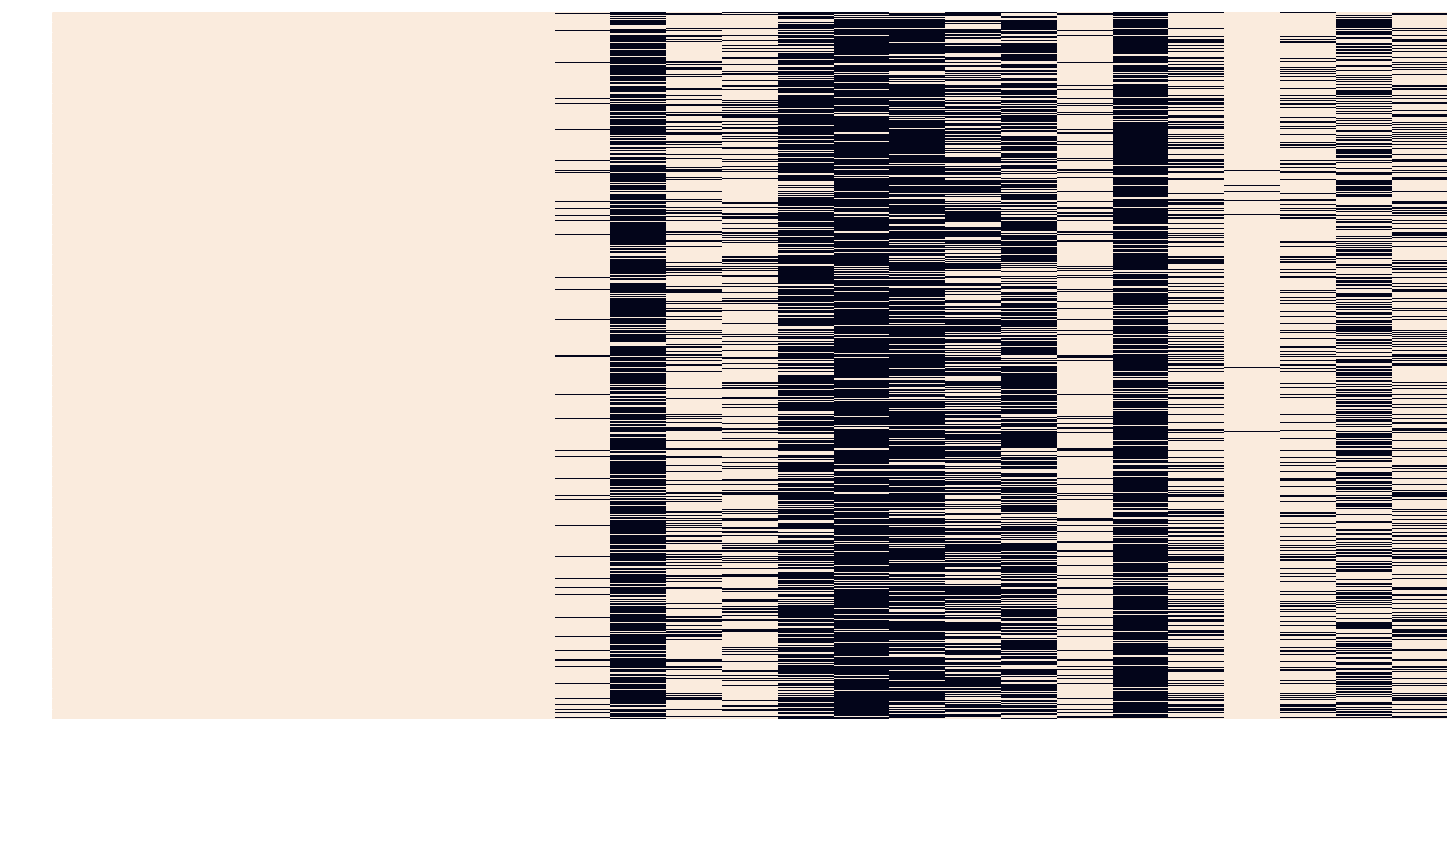

In [11]:
plt.figure(figsize=(25,13))
sns.heatmap(~missing, cbar=False)
plt.show()

### Missing features

Missing report function: Count and proportion of missing data per column

In [12]:
def missing_report(df):
    area = (df.shape[0]*(df.shape[1]))
    proportion = lambda x: x.sum() / area
    missing = df.isnull().agg(['sum', 'mean', proportion]).transpose()
    missing = missing.sort_values('sum', ascending=False)
    missing.columns = ['missing', 'column proportion', 'overall proportion']
    missing['missing'] = missing.missing.astype('int')
    return missing

In [13]:
missing_report(df[FEATURES])

,missing,column proportion,overall proportion
Text_4,346531,0.865728,0.054108
Facility_or_Department,346391,0.865378,0.054086
Text_2,312060,0.779610,0.048726
Sub_Object_Description,308674,0.771151,0.048197
Text_3,291125,0.727309,0.045457
FTE,274206,0.685041,0.042815
Location_Description,238223,0.595145,0.037197
Fund_Description,197400,0.493158,0.030822
Position_Extra,135513,0.338548,0.021159
Text_1,107992,0.269793,0.016862


The numeric variable `FTE` lacks `68%` and `Total` lacks only `1%`.  The most frequent text column is `Object Description`.

### **Missing `FTE`**

Let's subtotal missing `FTE` by `Object Description`: One can see high ocurrence of 'EMPLOYEE BENEFITS', similar object descriptions and also 'SUPPLIES'.

In [14]:
df.fillna({'Object_Description':'NaN'}).loc[df.FTE.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                 47495
CONTRA BENEFITS                   19381
ADDITIONAL/EXTRA DUTY PAY/STIP    16841
SUPPLIES                          13117
RETIREMENT CONTRIB.               13073
                                  ...  
RESERVE                               1
RESIDENTIAL FACILITIES                1
Custodial  Supplies                   1
Remaining Other Vendors               1
OTHER MATERIALS AND SUPPLIES          1
Length: 555, dtype: int64

### **Missing `Total`**

Let's subtotal missing `Total` by `Object Description`:  One can see high occurrence in 'EMPLOYEE BENEFITS' and similar object descriptions.

In [15]:
df.fillna({'Object_Description':'NaN'}).loc[df.Total.isnull()].groupby('Object_Description').size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                                     1184
SALARIES OF REGULAR EMPLOYEES                          876
EMPLOYER PD MED CONTRIBUTION                           295
Salaries And Wages For Teachers And Other Professi     288
NaN                                                    261
                                                      ... 
PRINTING, BINDING, DUPLICATING                           1
POSTAGE                                                  1
PART TIME OVERTIME WAGES                                 1
FOOD SRV-NON REFRIGERATION PRT                           1
OTHER PURCHASED SERVICES                                 1
Length: 217, dtype: int64

### Missing Total and FTE relationship

Let's list `Total` related to missing `FTE`: High `Total` values, like 129,7 millions, not related to (missing) `FTE`.

In [16]:
df.loc[df.FTE.isnull(), ['Total', 'Object_Description']].sort_values('Total', ascending=False)

,Total,Object_Description
358538,1.297000e+08,Payments to a Community School*
322149,5.323797e+07,Other Purchased Services
390959,4.789057e+07,PAYMENTS TO ESCROW AGENTS
177775,3.956446e+07,INTEREST ON LEASES
331752,3.645094e+07,BUILDINGS
...,...,...
300250,NaN,EMPLOYEE BENEFITS
289753,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,EMPLOYEE BENEFITS
334668,NaN,EMPLOYEE BENEFITS


Let's list `FTE` related to missing `Total`: Highest `FTE` values, close to 1, whose missing `Total` is not clear.

In [17]:
df.loc[df.Total.isnull(), ['FTE', 'Object_Description']].sort_values('FTE', ascending=False)

,FTE,Object_Description
392540,1.127804,SALARIES OF REGULAR EMPLOYEES
147244,1.016335,SALARIES OF REGULAR EMPLOYEES
91088,1.012847,SALARIES OF REGULAR EMPLOYEES
60354,1.012223,SALARIES OF REGULAR EMPLOYEES
203019,1.009218,SALARIES OF REGULAR EMPLOYEES
...,...,...
300250,NaN,EMPLOYEE BENEFITS
289753,NaN,SALARIES OF REGULAR EMPLOYEES
438970,NaN,EMPLOYEE BENEFITS
334668,NaN,EMPLOYEE BENEFITS


### **No missing labels**

No label has missing data

In [18]:
missing[LABELS].all().all()

False

## Continuous variables: FTE and Total

`FTE`: full-time equivalent
If the budget item is associated to an employee, this number tells us the **percentage** of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

`Total`: total cost of the expenditure.
This number tells us how much the budget item cost.

In [19]:
numeric_statistics(df)

,count,mean,std,min,25%,50%,75%,max,missing,miss_ratio,sum,range,skewness,kurtosis,iqr,lo_outlier,hi_outlier
FTE,126071,0.426794,0.573576,-8.755064e-02,0.000792,0.130927,1.0000,4.680000e+01,274206,0.685041,5.380634e+04,4.688755e+01,19.273698,1172.951126,0.999208,-1.49802,2.498812
Total,395722,13105.856828,368225.392358,-8.746631e+07,73.797700,461.230000,3652.6625,1.297000e+08,4555,0.011380,5.186276e+09,2.171663e+08,100.319800,51040.801730,3578.864800,-5294.49950,9020.959700


Function to plot a panel with a scatter, density and box plots:

In [20]:
from scipy.stats import zscore
def density_plots(x, label=None, outlying = True, zthreshold = 3, bins=None, figsize=(25,5)):

    if outlying:
        x_mean = x.mean()
        x_std = x.std()
        lower_limit = x_mean - zthreshold * x_std
        upper_limit = x_mean + zthreshold * x_std
        outliers = x[(zscore(x) < -zthreshold) | (zscore(x) > zthreshold)]
    
    plt.figure(figsize=figsize)
    
    # scatter plot
    plt.subplot(1,3,1); plt.grid(False)
    plt.plot(x, marker='.', linestyle='none', color='green', label='inlier')
    plt.ylabel(label); plt.xlabel('row')
    if outlying:
        plt.plot(outliers, marker='.', linestyle='none', color='red', label='outlier')
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')
    
    # density plot
    plt.subplot(1,3,2); plt.grid(False)
    plt.hist(x, bins=bins)
    plt.xlabel(label); plt.ylabel('PDF')
    
    if outlying:
        plt.axvline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axvline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')
    
    # box plot
    plt.subplot(1,3,3); plt.grid(False)
    # sns.boxplot(y=x, orient='v')
    plt.boxplot(x)
    # plt.ylabel(label)
    # plt.xticks=False
    
    if outlying:
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')
        
    plt.tight_layout()
    plt.show()

### `FTE` univariate analysis

`FTE` contains skewed data with upper outliers

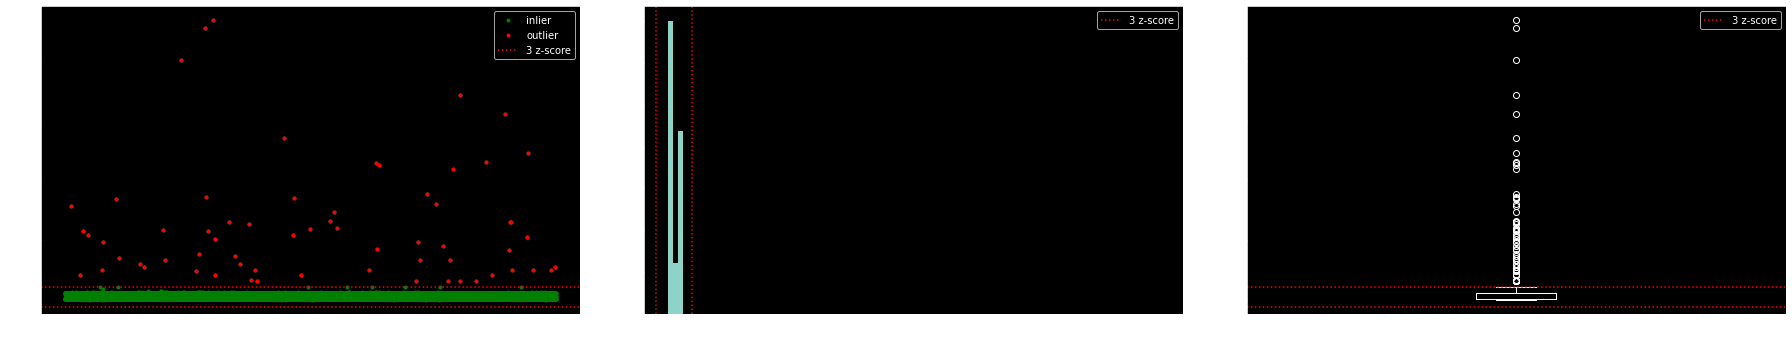

Upper outliers: 64
Lower outliers: 0


In [21]:
fte = df.FTE.dropna()
density_plots(fte, 'FTE', bins=100)
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

`FTE` ouliers hold values from `3` o `46.8`, assumed as multiple headcount.  Those values seem reasonable for the `Total` and description columns that follow:

In [22]:
relevant = ['FTE', 'Total', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[fte[(zscores < -3) | (zscores > 3)].index.values, relevant].sort_values('FTE', ascending=False)

,FTE,Total,Fund_Description,Object_Description,Job_Title_Description
135371,46.8,528191.986943,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
128399,45.6,478476.893739,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
105857,40.2,580900.061569,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
362251,34.2,484744.886261,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
404264,31.1,352252.935596,Central Cafeteria,Personal Services - Food Services - Cafeteria,NaN
...,...,...,...,...,...
362443,3.0,280332.905298,General,Regular *,"TCHR, OCC THERAPIST"
377132,3.0,149857.502317,General,Regular *,EDUCATIONAL AIDE I
351528,3.0,162472.656884,General,Regular *,MOBILE DEPUTY
176122,3.0,130486.445186,General,Regular *,PARA (MF)


What if to remove upper outliers?

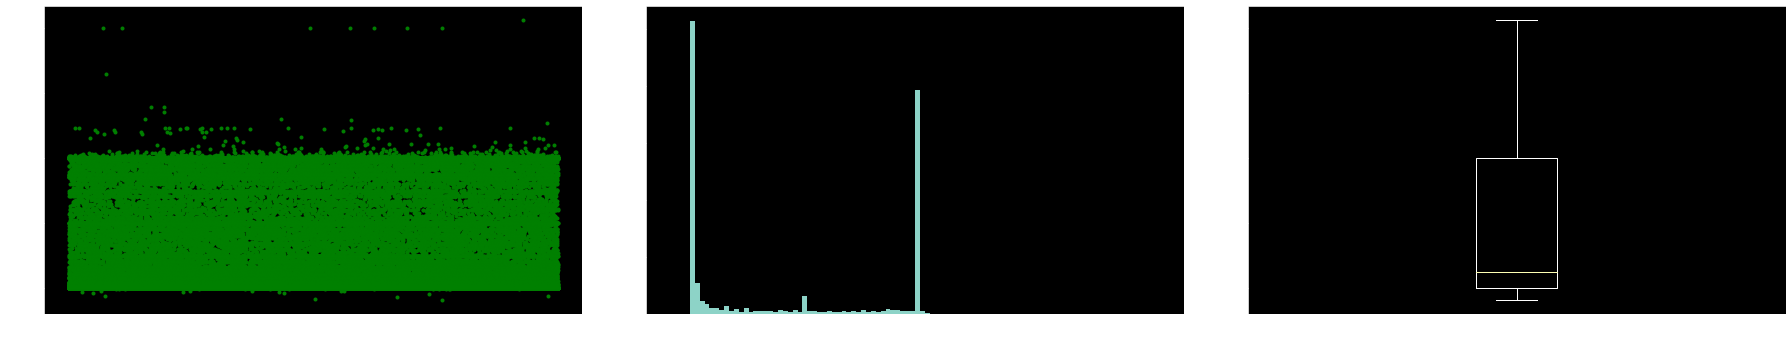

In [23]:
fte_no_outliers = fte[zscores <= 3]
density_plots(fte_no_outliers, 'FTE', outlying=False, bins=100)

### `Total` univariate analysis

`Total` contains upper and lower outliers with magnitude or +/- 100 millions.

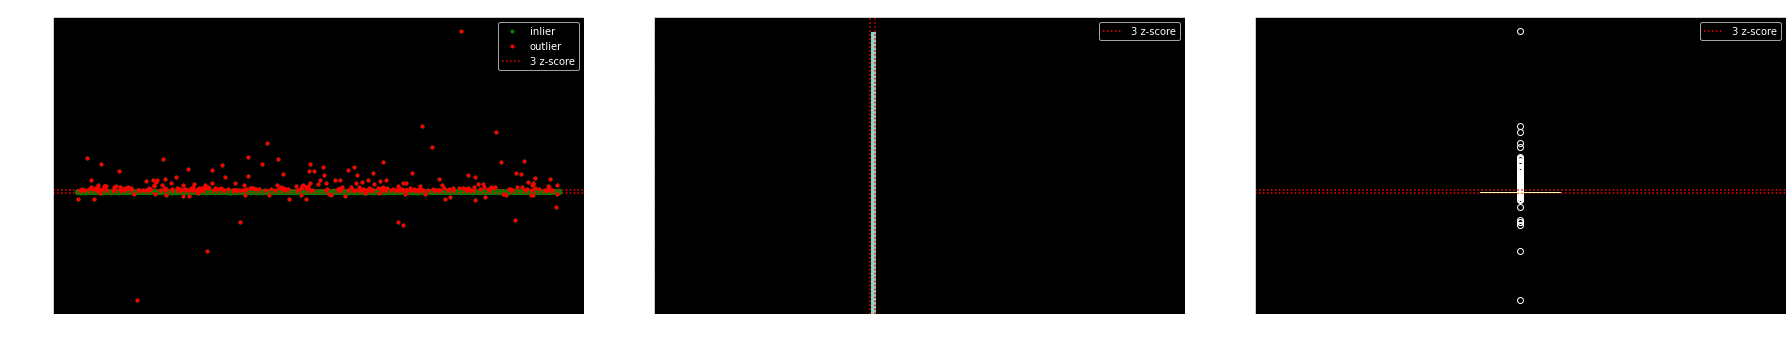

Upper outliers: 317
Lower outliers: 37


In [24]:
total = df.Total.dropna()
density_plots(total, 'Total', bins=100)
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

Those `Total` outliers are associated with null `FTE`, i.e., they are not related to headcount but to facilities, buildings, insurances, etc.

In [25]:
relevant = ['Total', 'FTE', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[total[(zscores < -3) | (zscores > 3)].index, relevant].sort_values('Total', ascending=False)

,Total,FTE,Fund_Description,Object_Description,Job_Title_Description
358538,1.297000e+08,NaN,General,Payments to a Community School*,NaN
322149,5.323797e+07,NaN,Employee Benefits Self-Insurance,Other Purchased Services,NaN
390959,4.789057e+07,NaN,NaN,PAYMENTS TO ESCROW AGENTS,(blank)
177775,3.956446e+07,NaN,NaN,INTEREST ON LEASES,(blank)
331752,3.645094e+07,NaN,NaN,BUILDINGS,(blank)
...,...,...,...,...,...
152005,-2.399966e+07,NaN,General Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
299589,-2.400000e+07,NaN,Capital Projects Fund,OPERATING TRANSFERS TO OTHER FUNDS,NaN
304649,-2.646500e+07,NaN,NaN,REDEMPTION OF PRINCIPAL,(blank)
121092,-4.789057e+07,NaN,NaN,PAYMENTS TO ESCROW AGENTS,(blank)


What if to remove all outliers?

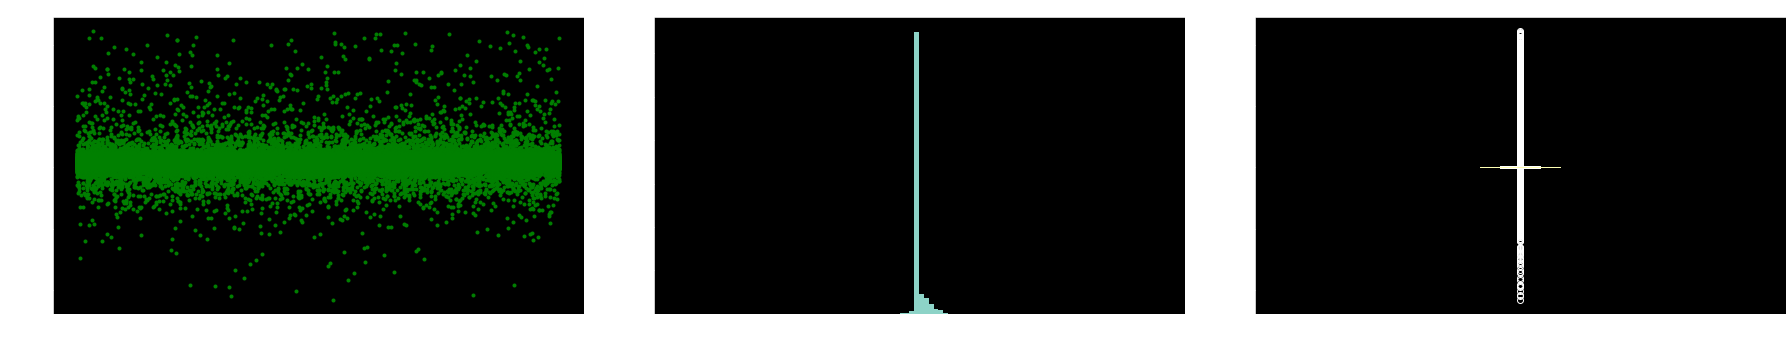

In [26]:
total_no_outliers = total[(zscores >= -3) & (zscores <= 3)]
density_plots(total_no_outliers, 'Total', outlying=False, bins=100)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

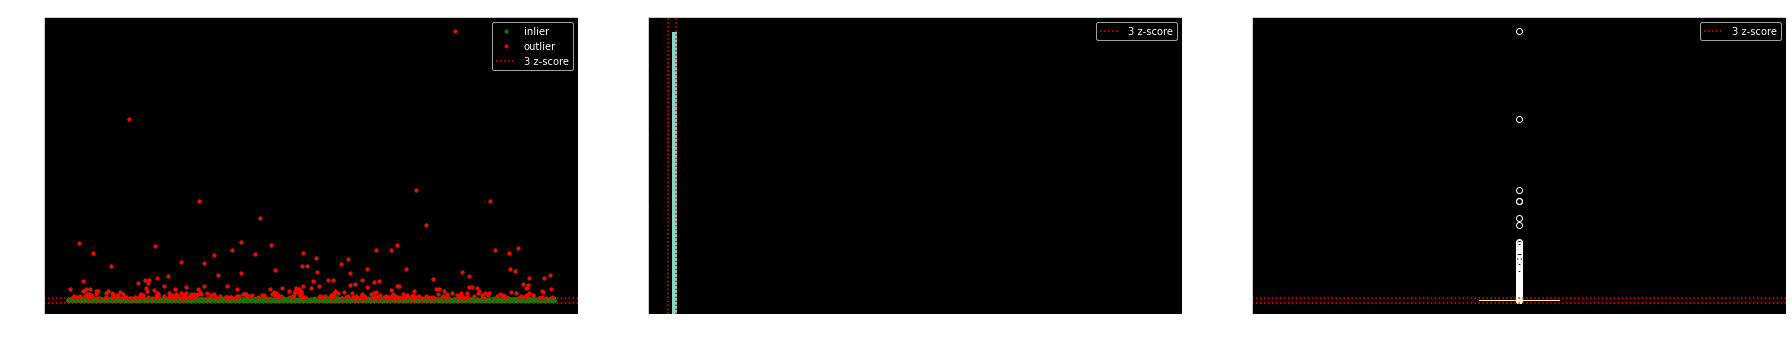

Upper outliers: 352
Lower outliers: 0


In [27]:
total_fixed = total.abs()
density_plots(total_fixed, 'Total', bins=100)
zscores_fixed = zscore(total_fixed)
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### Bivariate analysis

#### Linear regression/correlation by imputation strategy

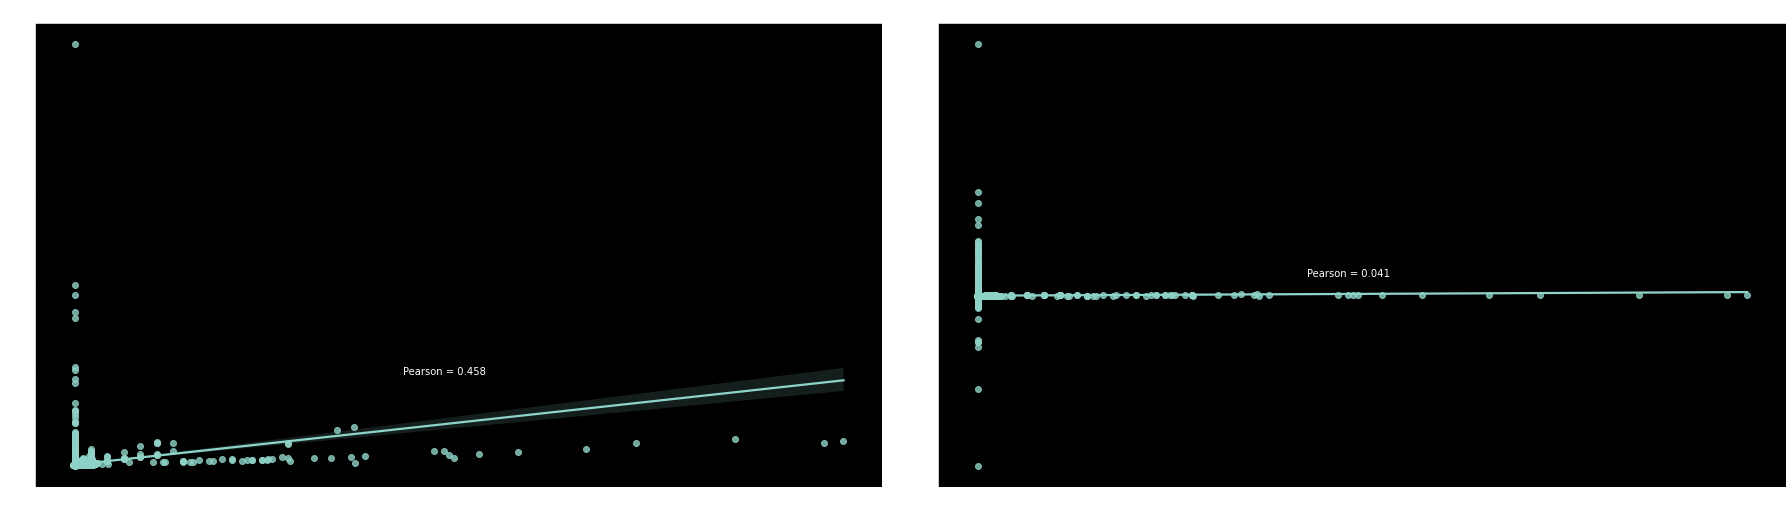

In [28]:
dropna_df = df[NUMERIC_FEATURES].dropna()
zero_imputed_df = df[NUMERIC_FEATURES].fillna(0)
# mean_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].mean())
# median_imputed_df = df[NUMERIC_FEATURES].fillna(df[NUMERIC_FEATURES].median())

plt.figure(figsize=(25,14))
plt.subplot(2,2,1)
sns.regplot(x='FTE', y='Total', data=dropna_df)
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(dropna_df.FTE, dropna_df.Total)[0,1]), (20,2000000))
plt.title('Drop missing')
plt.subplot(2,2,2)
sns.regplot(x='FTE', y='Total', data=zero_imputed_df)
plt.title('Zero imputed')
plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(zero_imputed_df.FTE, zero_imputed_df.Total)[0,1]), (20,10000000))
# plt.subplot(2,2,3)
# sns.regplot(x='FTE', y='Total', data=mean_imputed_df)
# plt.title('Mean imputed')
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(mean_imputed_df.FTE, mean_imputed_df.Total)[0,1]), (20,10000000))
# plt.subplot(2,2,4)
# sns.regplot(x='FTE', y='Total', data=mean_imputed_df)
# plt.title('Median imputed')
# plt.annotate('Pearson = {:.3f}'.format(np.corrcoef(median_imputed_df.FTE, median_imputed_df.Total)[0,1]), (20,10000000))
plt.tight_layout()
plt.show()

#### Grouped correlations before and after zero imputation

In [29]:
def grouped_corr_plot(by):
    grouped_corr = df[[by, 'FTE', 'Total']].groupby(by).corr().dropna().unstack().iloc[:,2].to_frame('raw corr')
    grouped_corr['imputed corr'] = df[[by, 'FTE', 'Total']].fillna({'FTE':0, 'Total':0}).groupby(by).corr().dropna().unstack().iloc[:,2].rename('imputed corr')
    grouped_corr.plot(kind='barh', figsize=(15,15))
    plt.title(f'FTE and Total correlation grouped by {by}')
    plt.xlabel('Correlation')
    plt.grid(axis='x')
    plt.show()

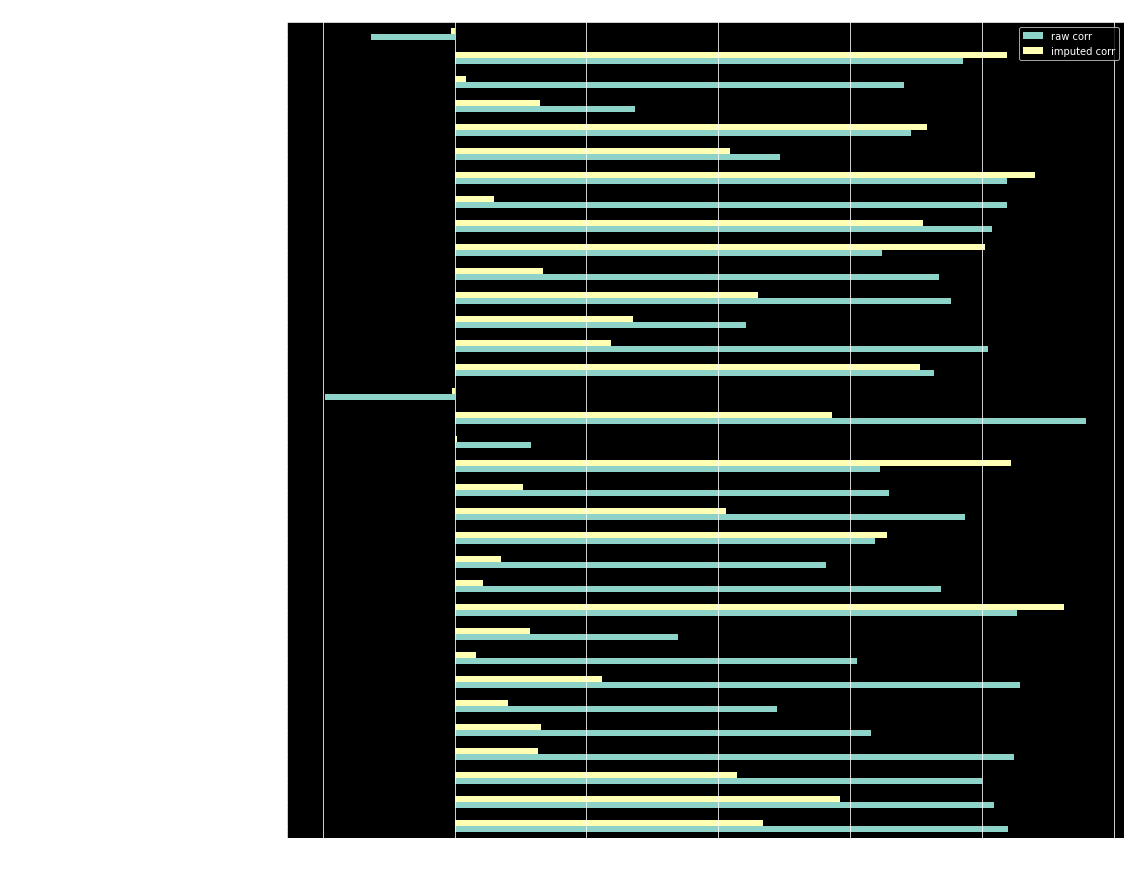

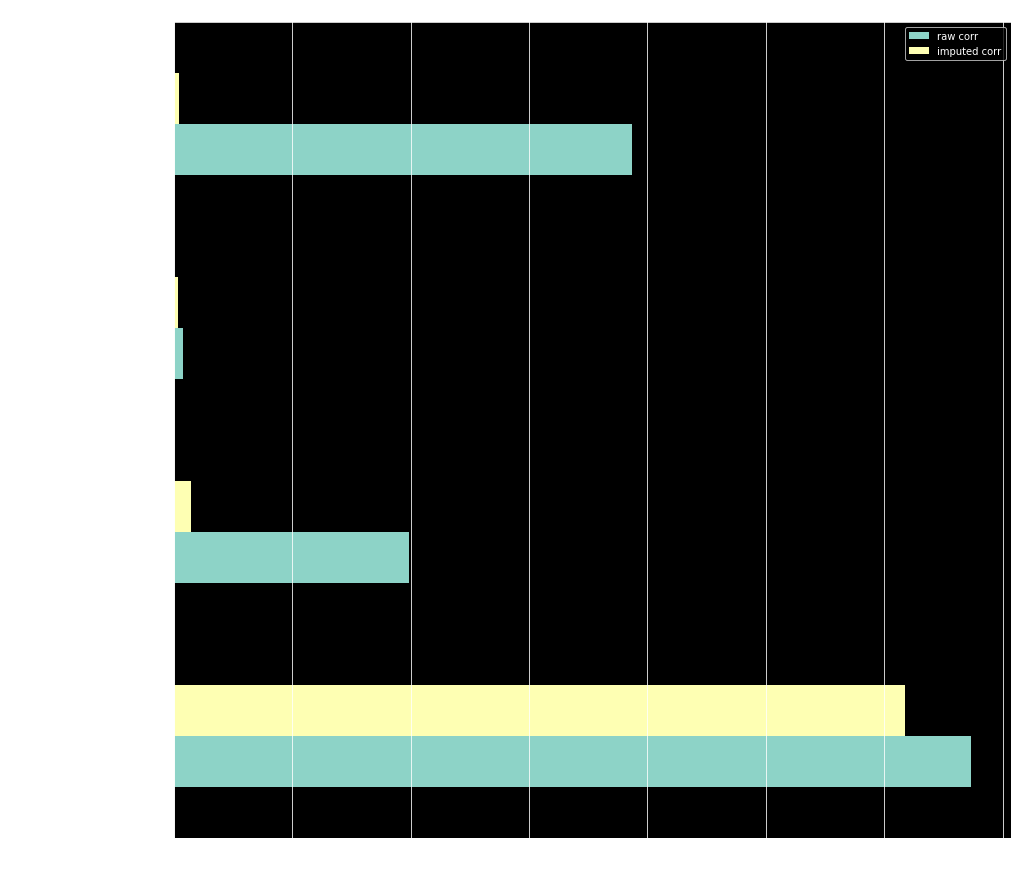

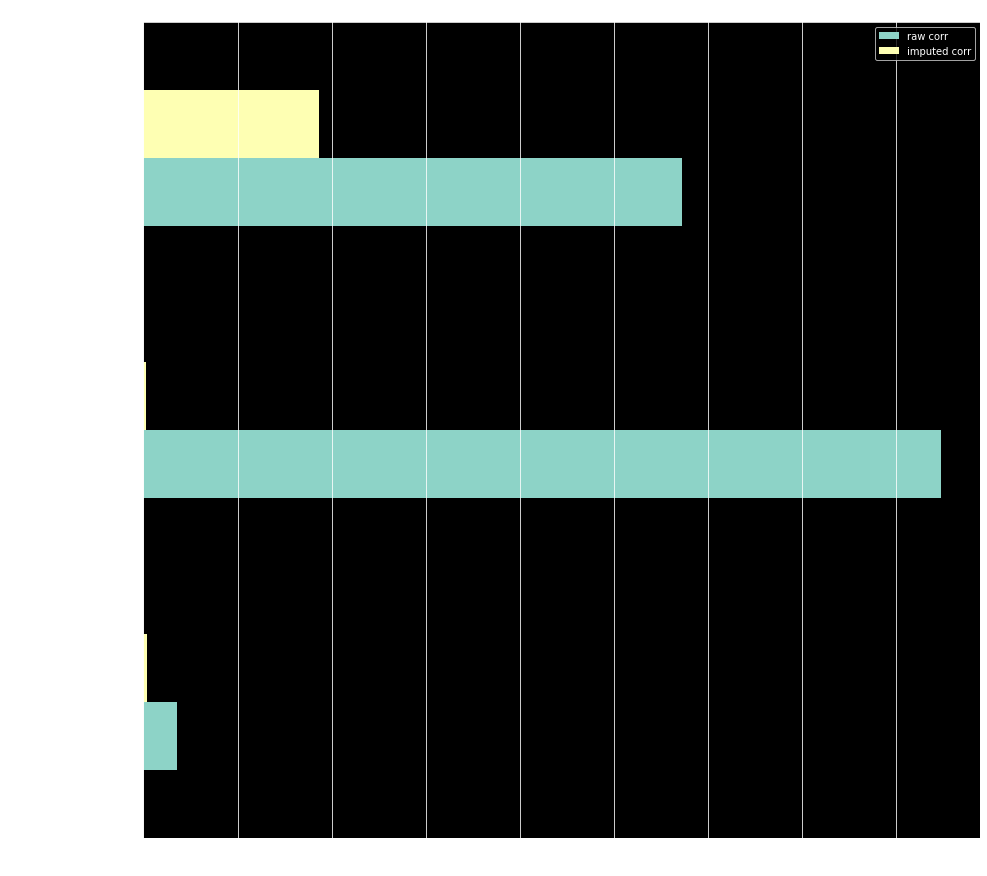

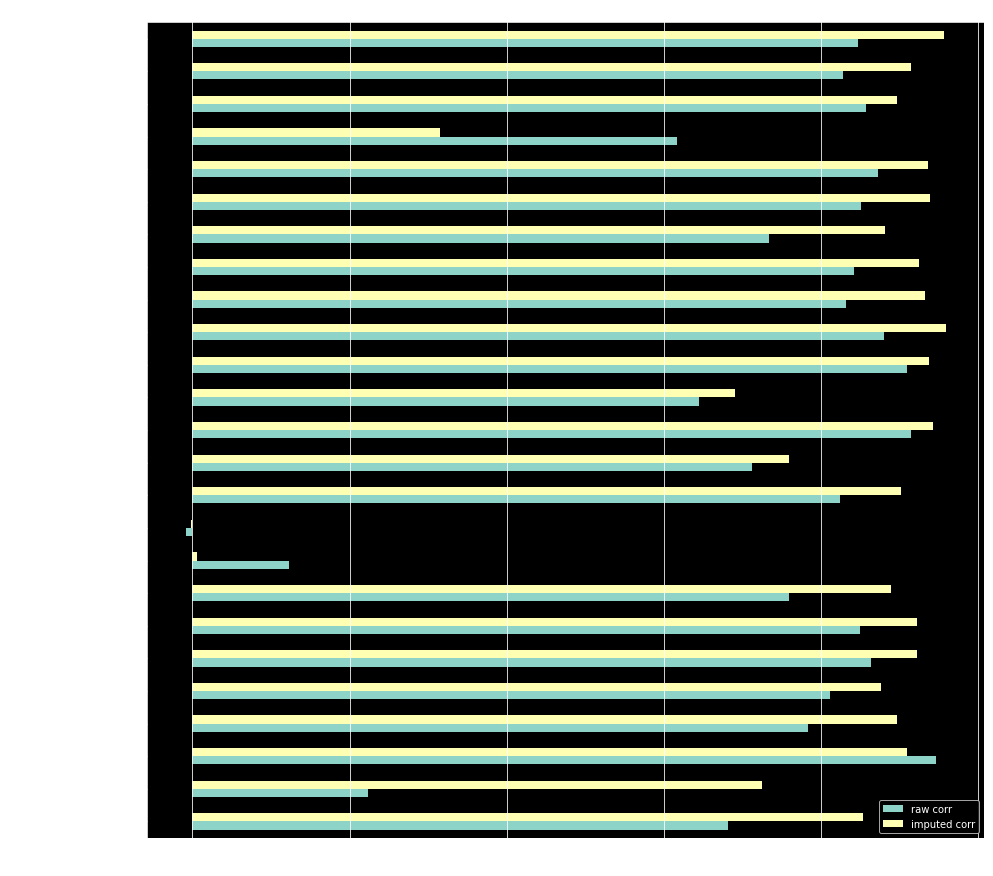

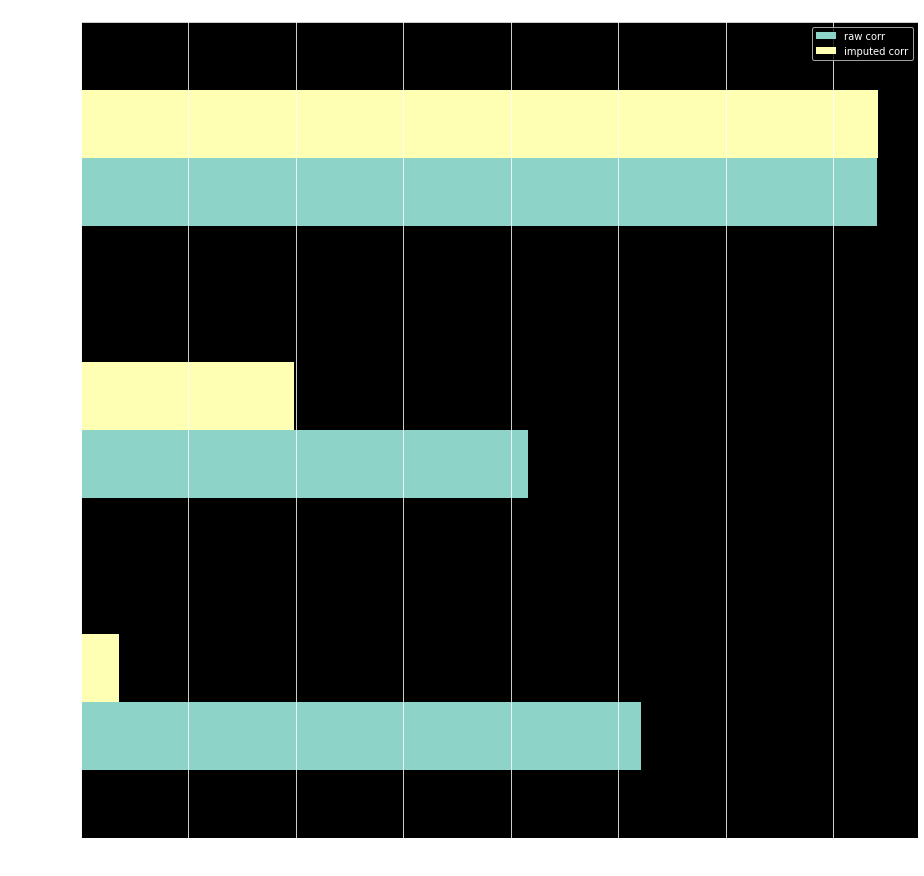

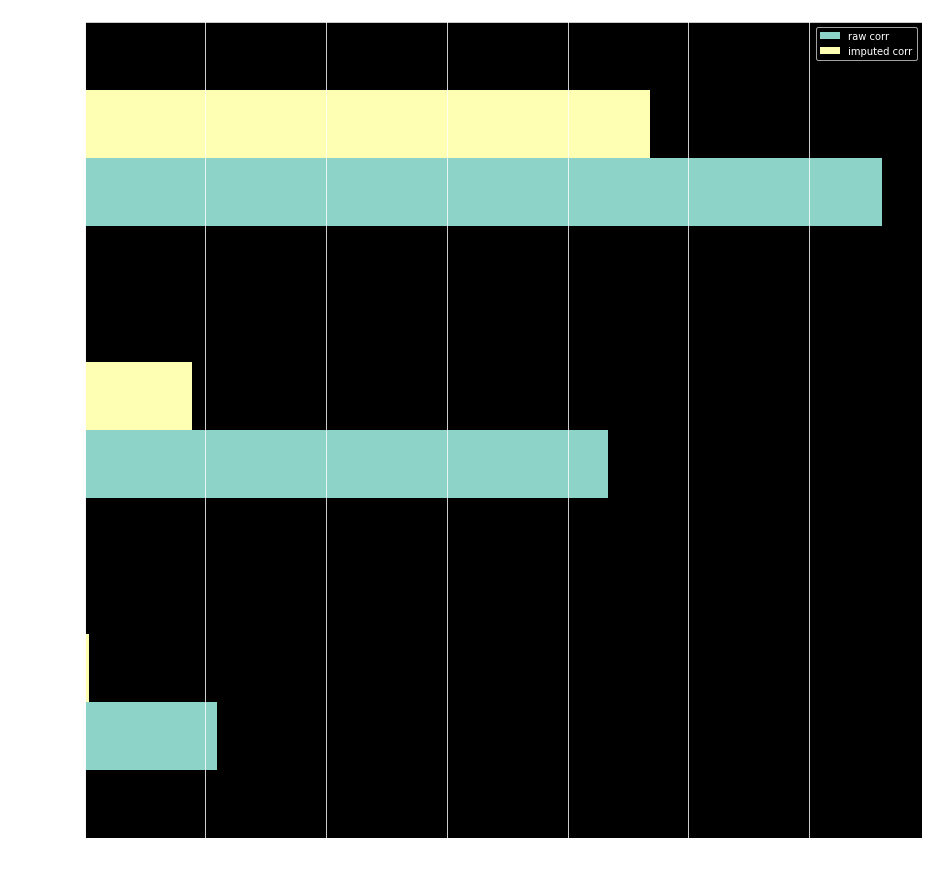

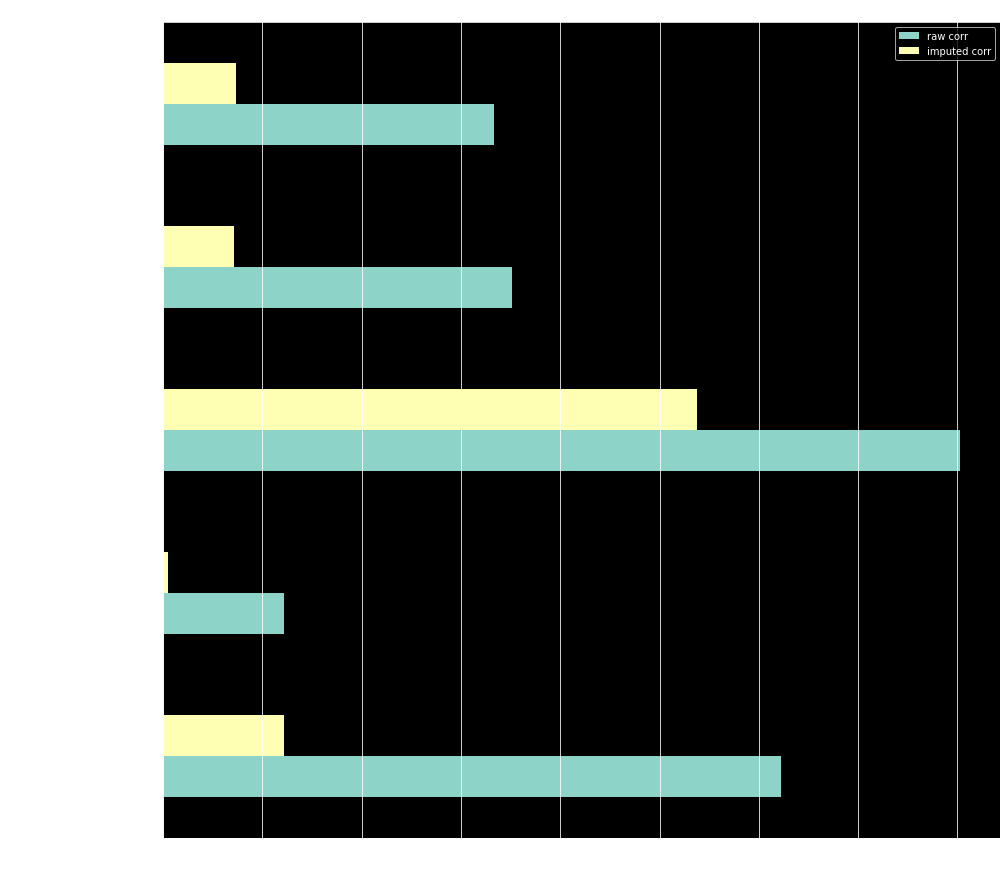

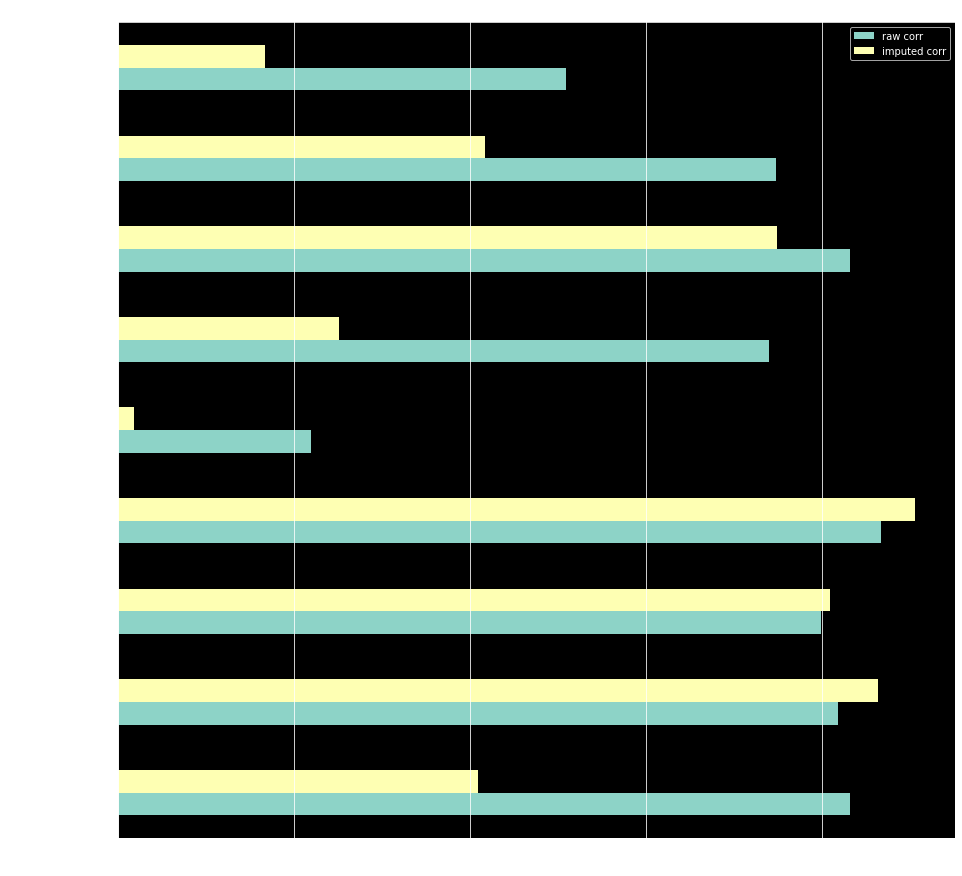

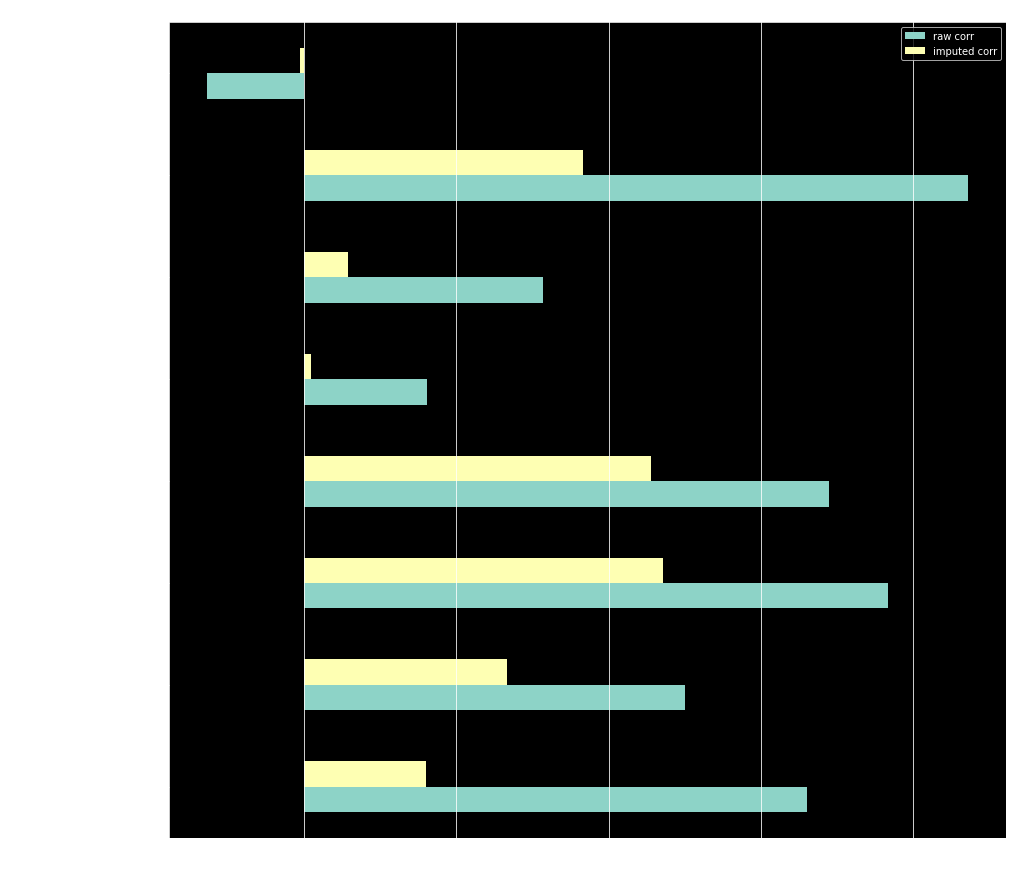

In [30]:
for x in LABELS:
    grouped_corr_plot(x)

#### Plotting numeric totals grouped by every label

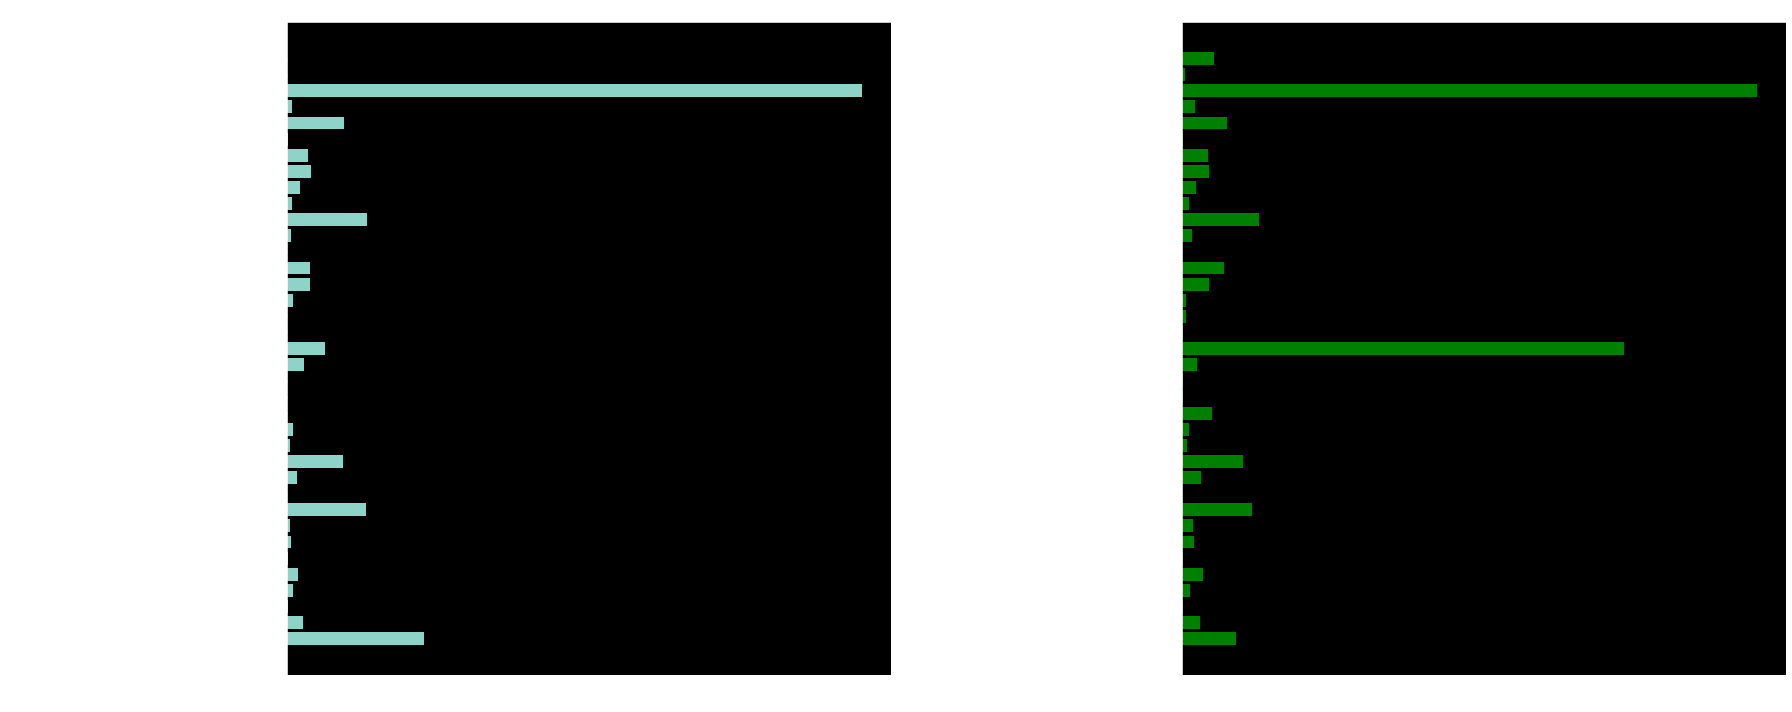

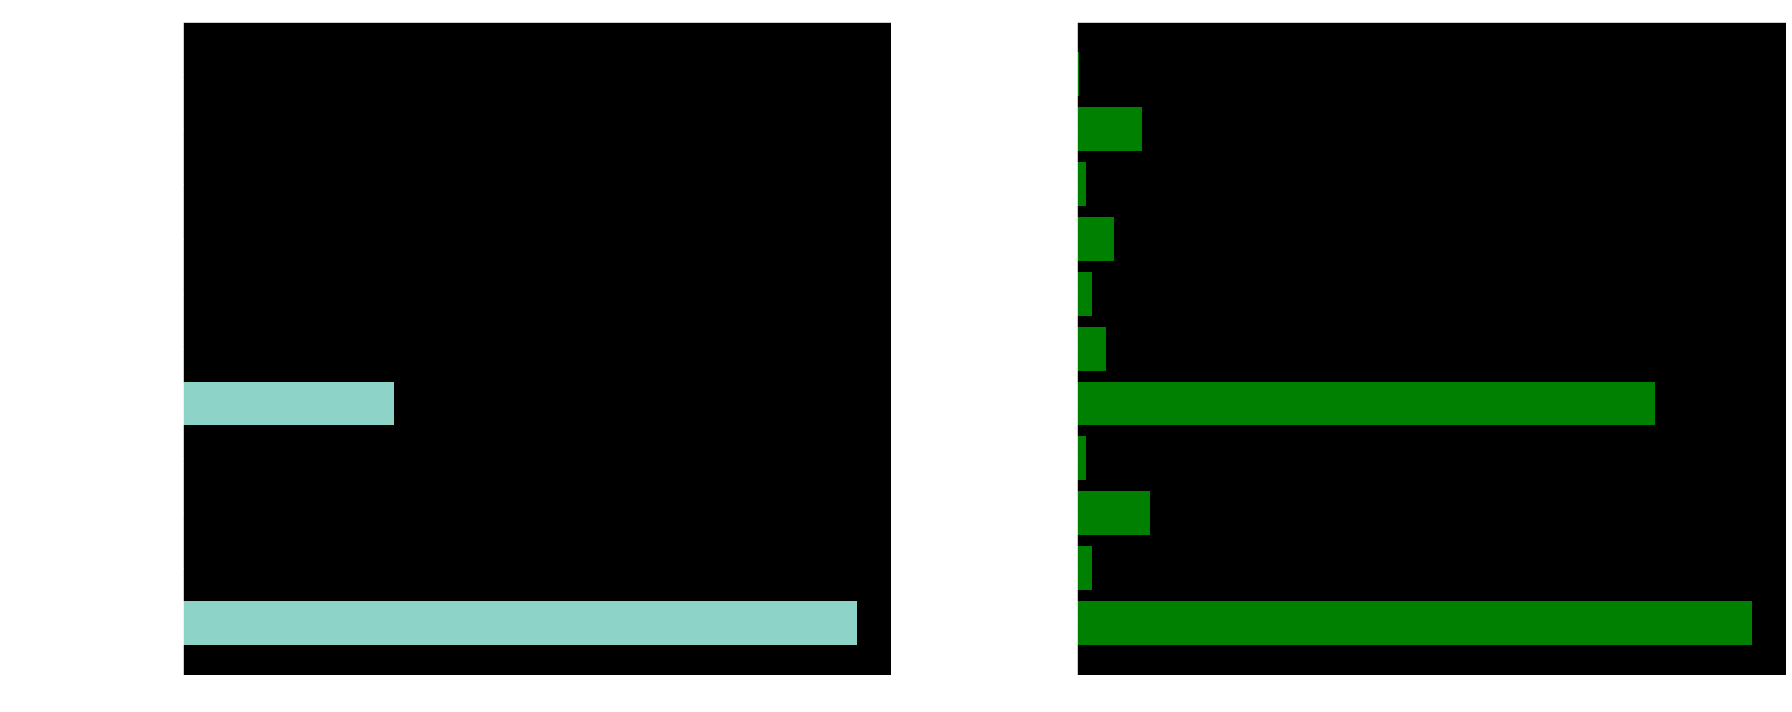

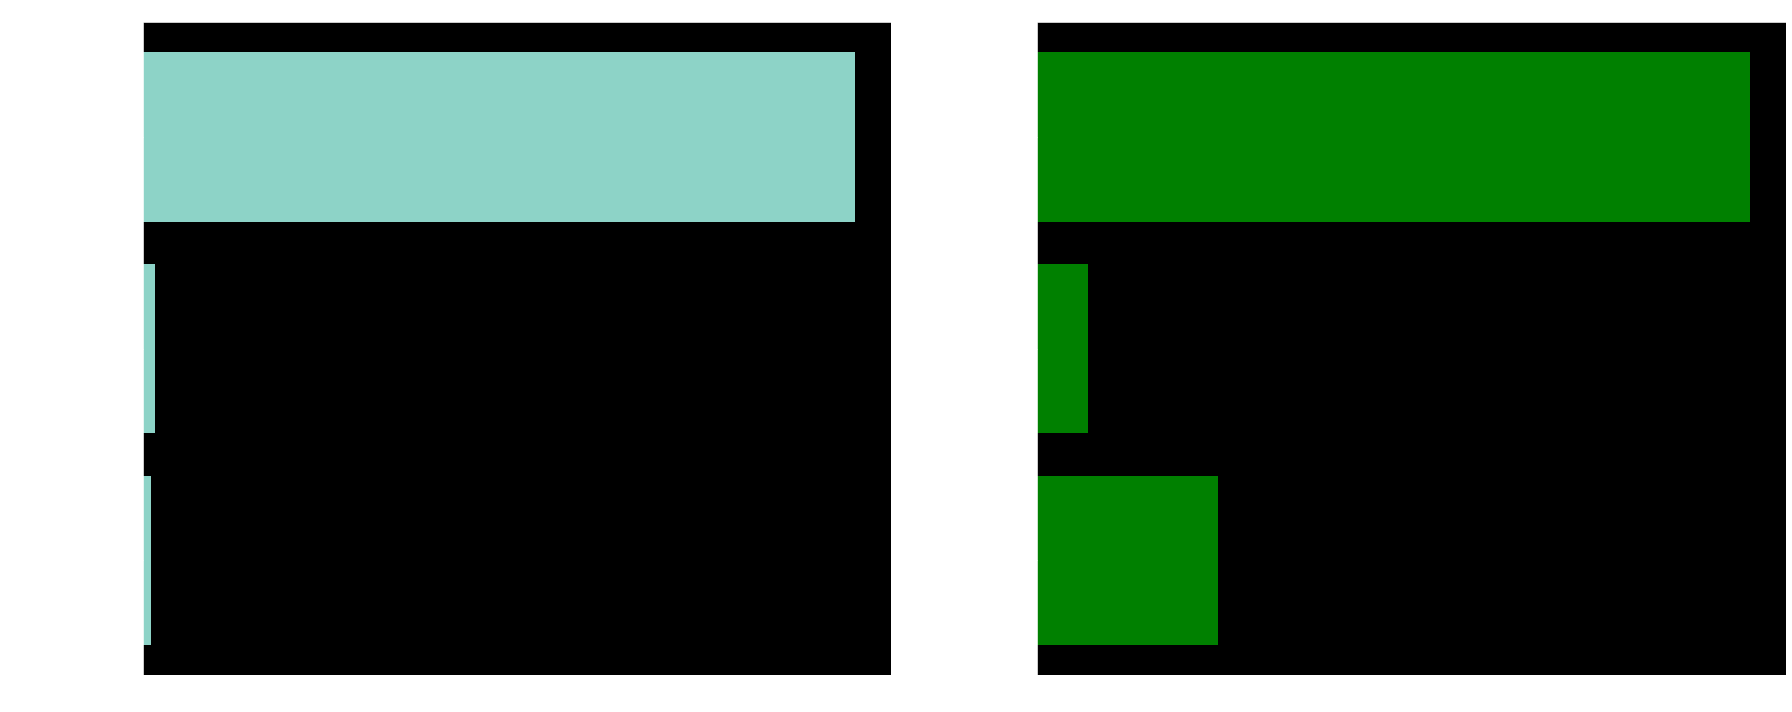

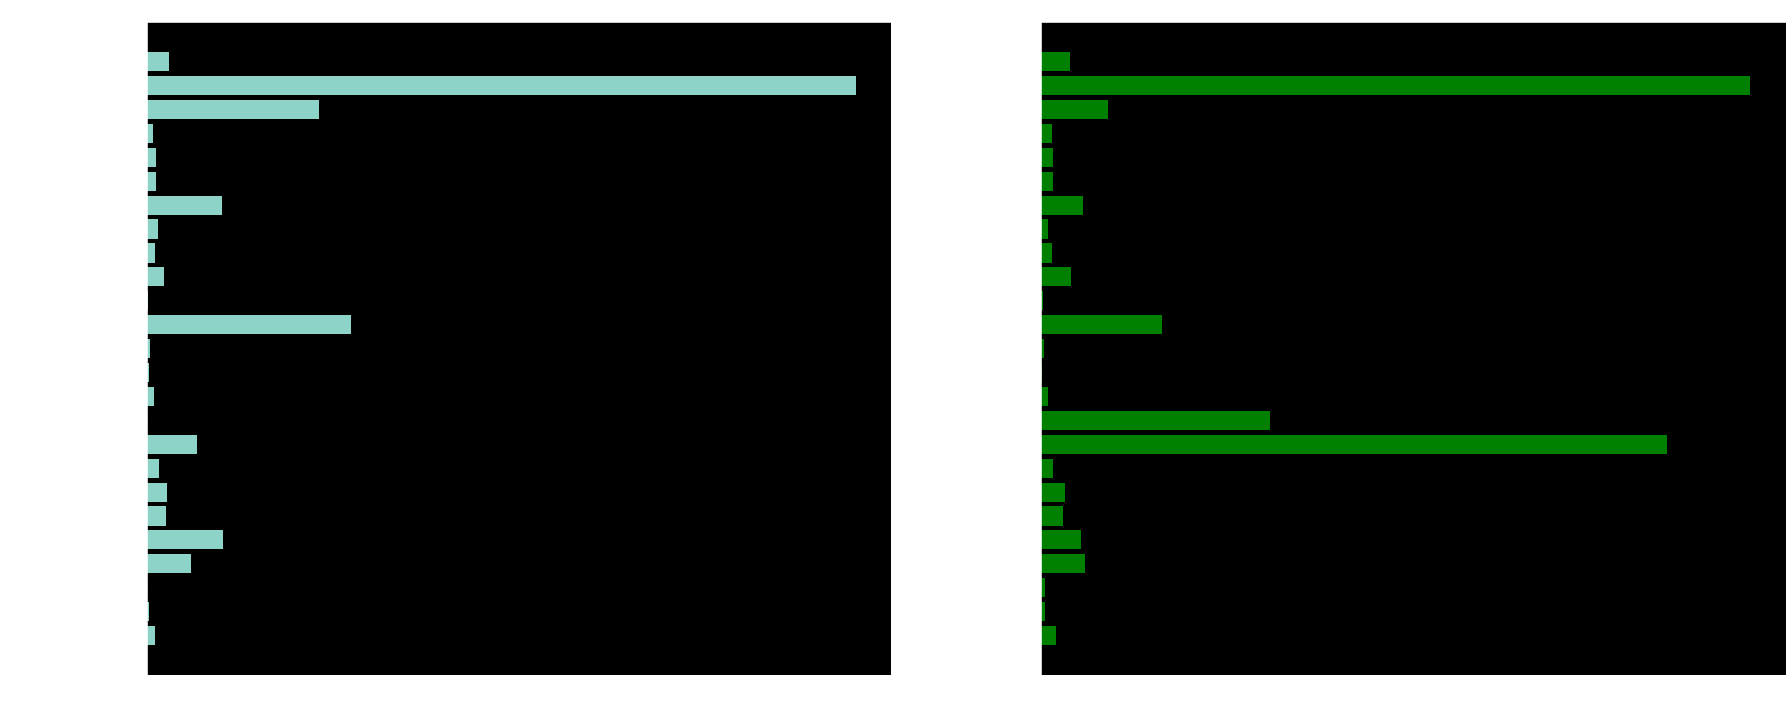

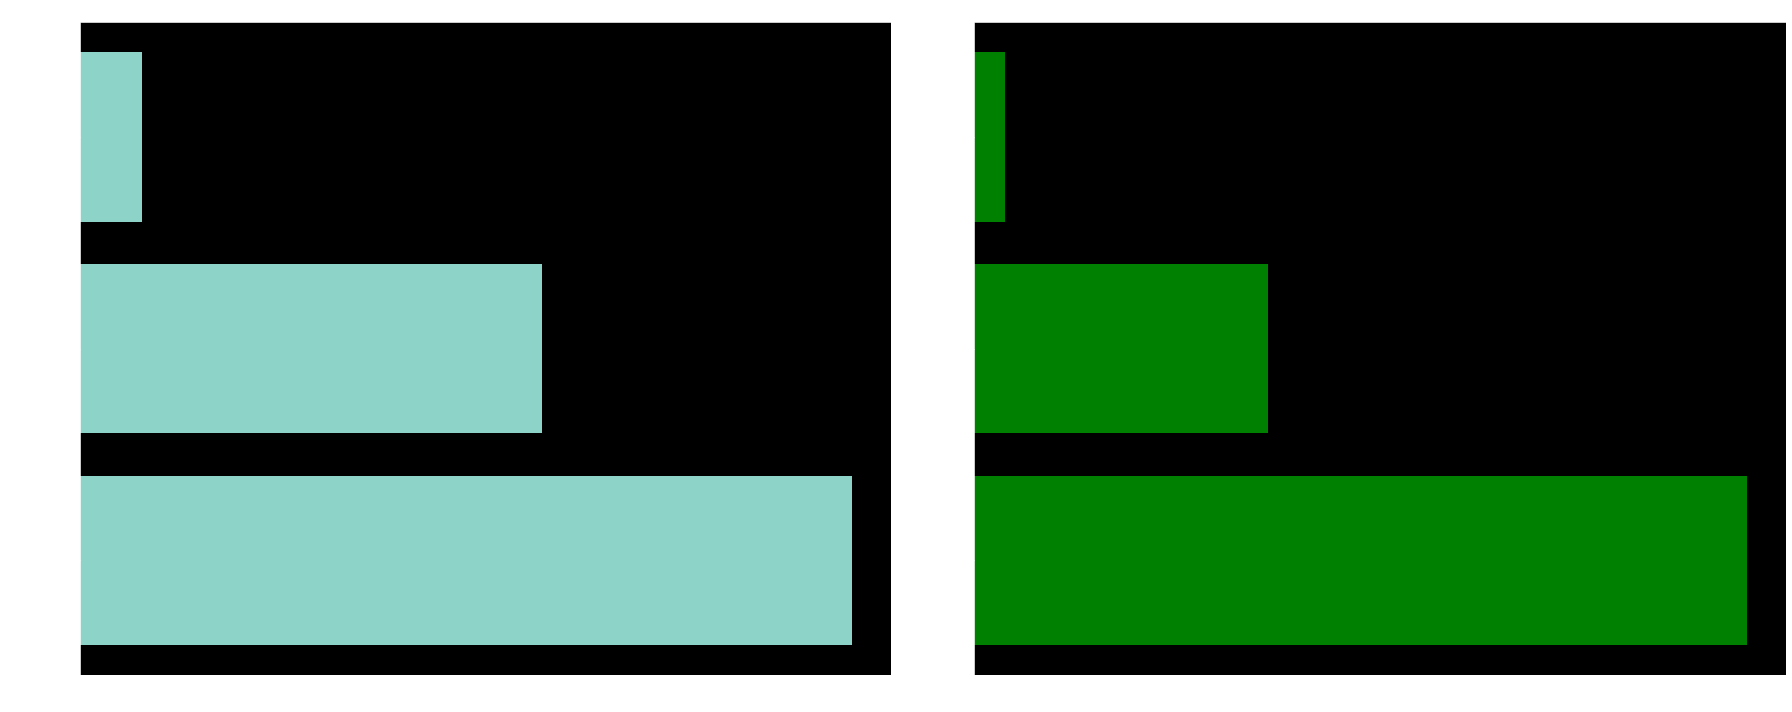

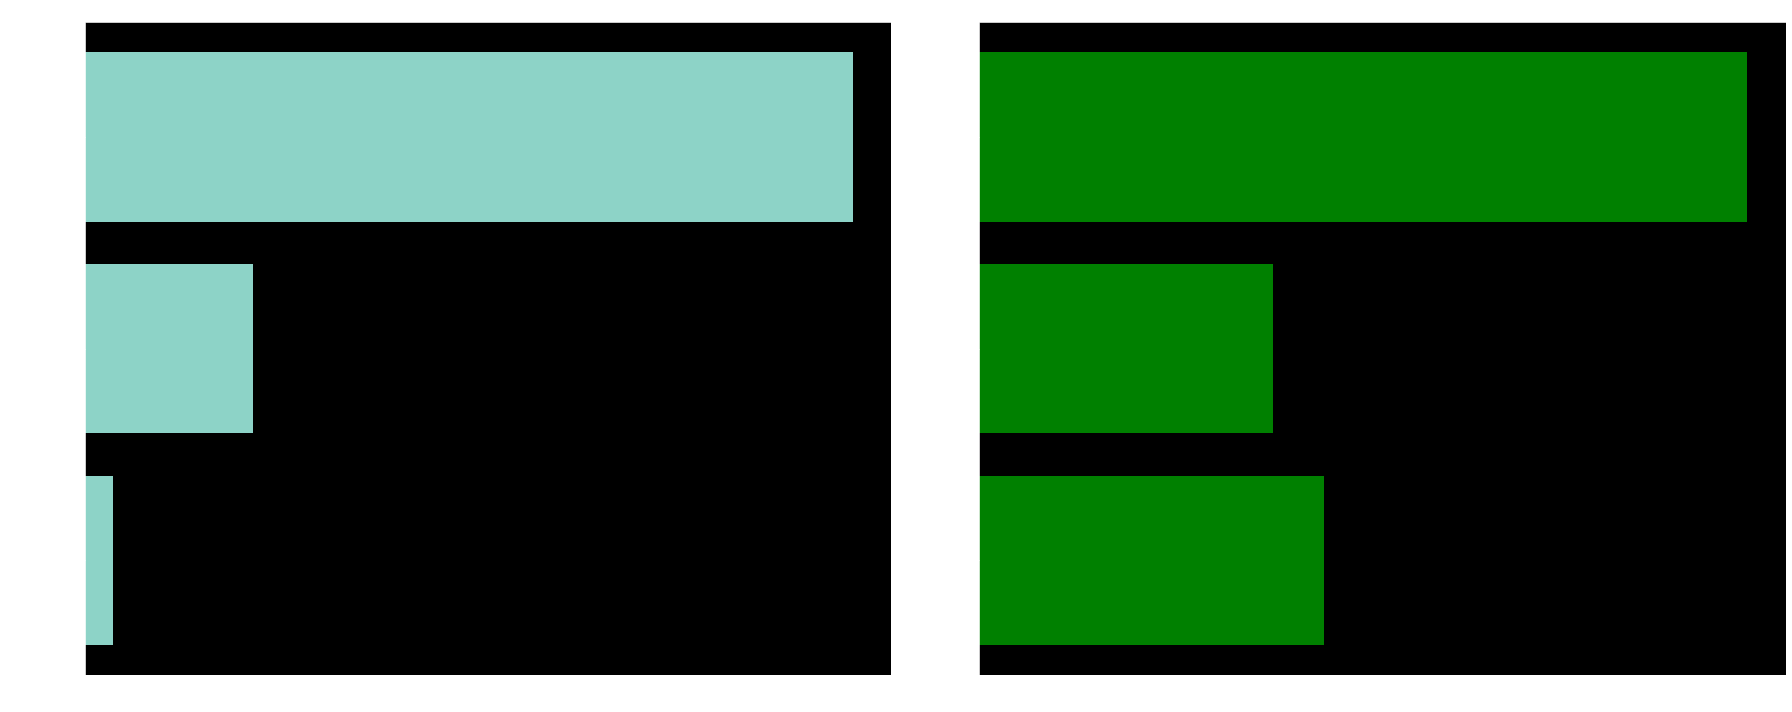

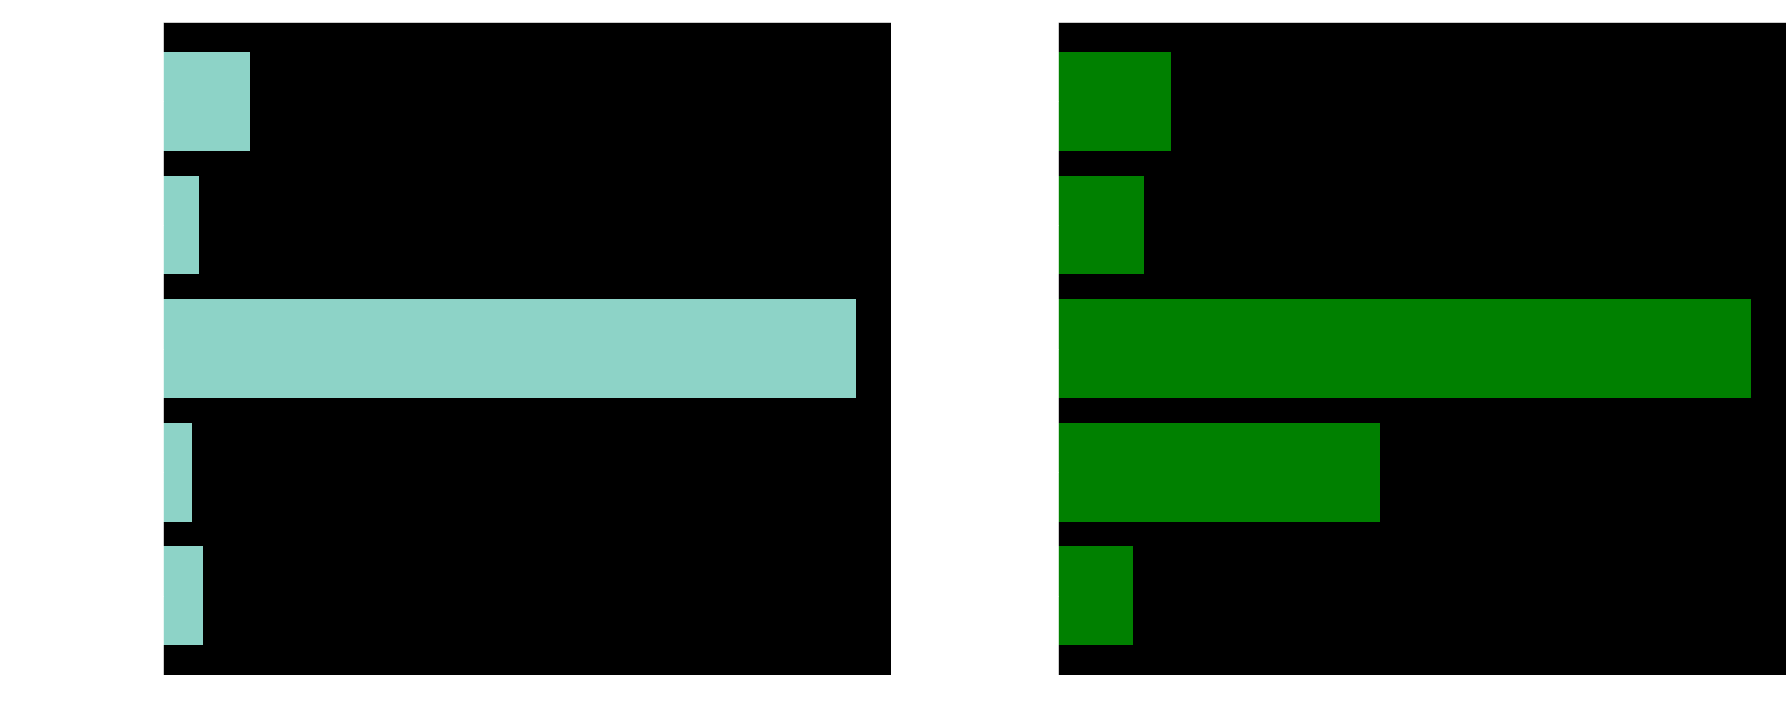

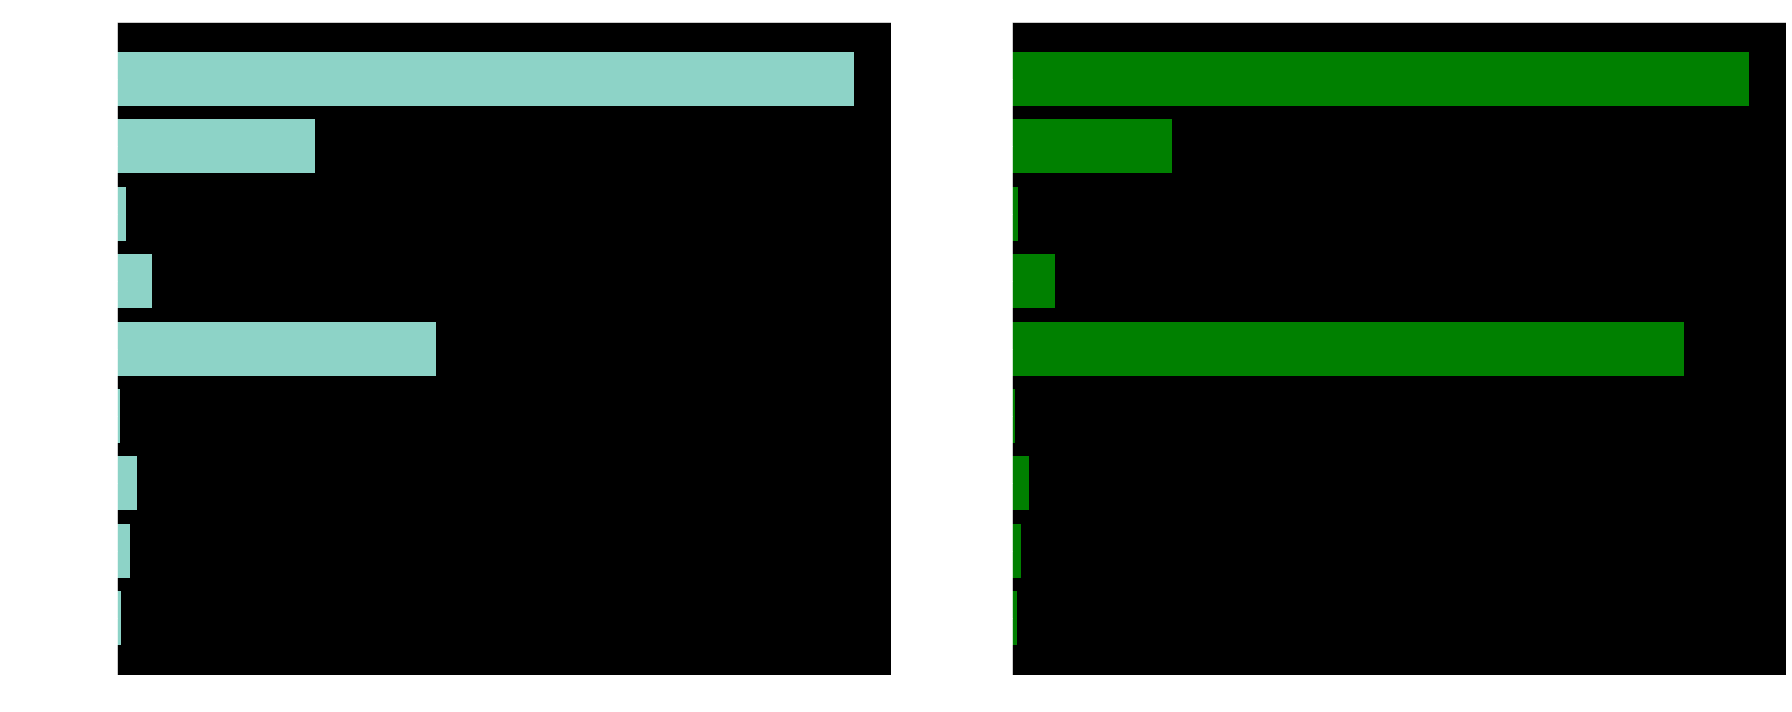

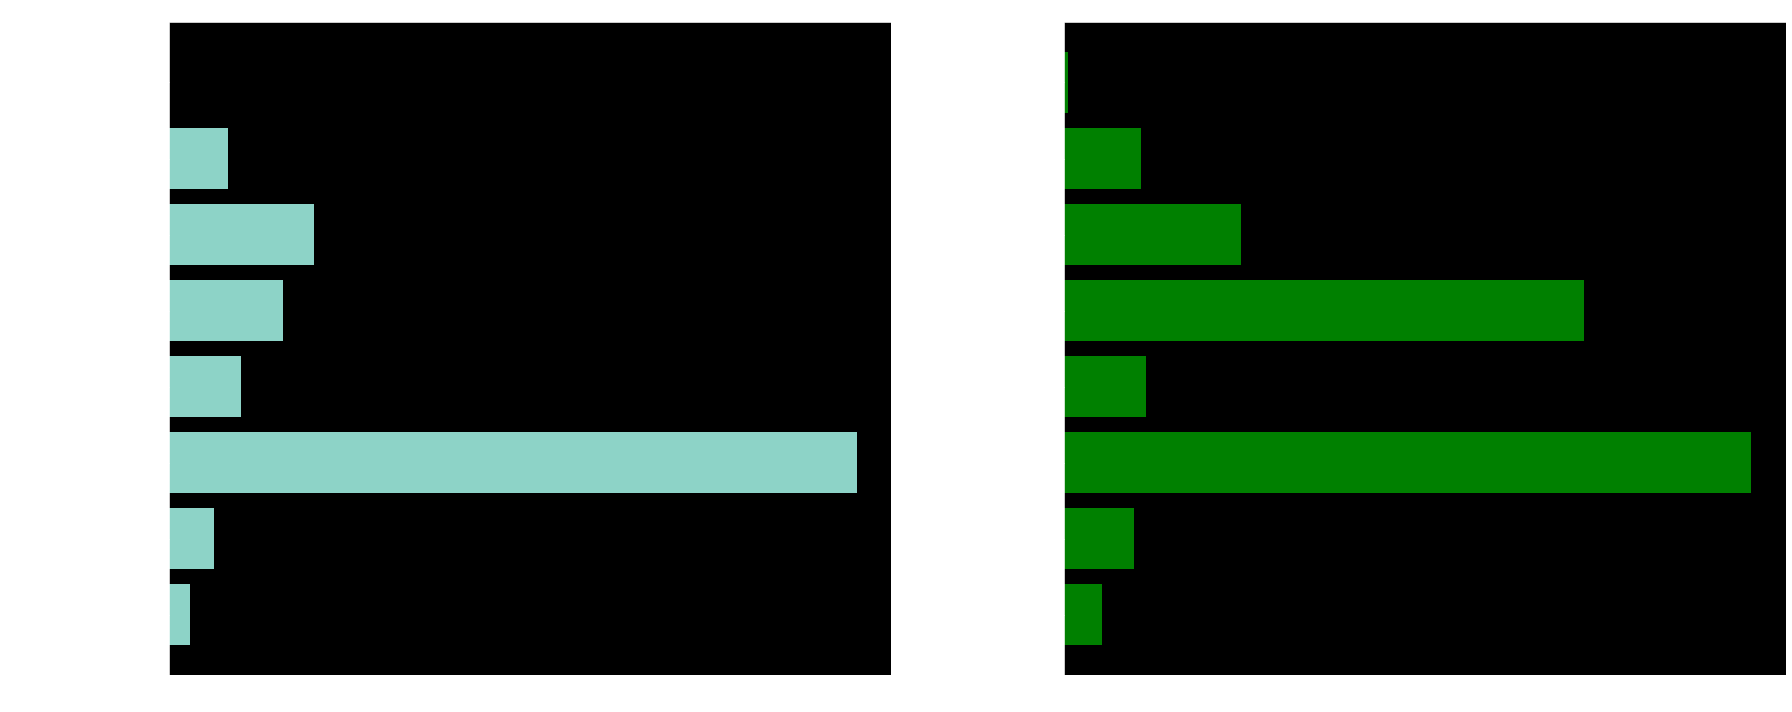

In [31]:
for label in LABELS:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

    fte = df.groupby(label).FTE.sum()
    #fte.plot(kind='bar')
    axes[0].barh(fte.index, fte)
    axes[0].set_title('Full Time Equivalent per ' + label)
    axes[0].set_ylabel('Headcount')
    
    total = df.groupby(label).Total.sum()
    #total.plot(kind='bar', color='green')
    axes[1].barh(total.index, total, color='green')
    axes[1].set_title('Total cost of the expenditure per ' + label)
    axes[1].set_ylabel('Cost')
    # axes[1].set_yticks([])
    plt.tight_layout()
    plt.show()    

## Free text form variables

Cross value counts helper function

In [32]:
def cross_value_counts(df):
    #cvc = df.replace('(\s+|[^\w+])',' ',regex=True)#.apply(lambda x: x.str.strip())
    cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.upper())
    cvc = cvc.apply(lambda x: x.value_counts(dropna=False)).fillna(0)
    cvc = cvc.apply(pd.to_numeric, downcast='unsigned')
    cvc.index.name = 'text'
    cvc.columns.name = 'columns'
    cvc.index = cvc.index.fillna('NaN')
    decreasing_row_index = cvc.sum(axis=1).sort_values(ascending=False).index
    decreasing_col_index = cvc.sum(axis=0).sort_values(ascending=False).index
    cvc = cvc.loc[decreasing_row_index, decreasing_col_index]
    return cvc

def cross_value_counts_summary(df):

    percent_with_nan = lambda x: x.sum() / (df.shape[0] * df.shape[1]) * 100
    cvc = cross_value_counts(df).replace(0, np.nan)
    cvcs = cvc.agg(['sum', 'count', percent_with_nan], axis='columns')
    cvcs.index.name = 'text'
    cvcs.columns=['Ocurrences', 'Columns', '% w/NaN']

    saved = cvcs.loc['NaN','Ocurrences']
    cvcs.loc['NaN','Ocurrences'] = np.nan
    cvcs['% wo/NaN'] = (cvcs.Ocurrences / cvcs.Ocurrences.sum() * 100).fillna(0)
    cvcs['Cumulated % wo/NaN'] = cvcs['% wo/NaN'].cumsum()
    cvcs.loc['NaN','Ocurrences'] = saved
    cvcs['words'] = cvcs.index.str.split().map(len).tolist()
    
    cvcs = cvcs.apply(pd.to_numeric, downcast='float')
    cvcs = cvcs.apply(pd.to_numeric, downcast='unsigned')

    return cvcs

### Text features frequencies

In [33]:
cross_value_counts(df[TEXT_FEATURES])

columns,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
text,,,,,,,,,,,,,,
NaN,24784,312060,93422,107534,291125,346531,308674,238223,58082,346391,135513,95617,197400,107992
GENERAL FUND,0,0,123327,0,0,0,0,0,0,0,0,0,57212,0
EMPLOYEE BENEFITS,47495,54,0,0,0,0,0,83,54,0,0,32669,0,32669
REGULAR,9270,0,0,0,94462,0,0,0,0,0,0,0,0,0
PROFESSIONAL INSTRUCTIONAL,0,0,0,0,0,0,0,0,0,0,92136,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEACHER TECHNOLOGY,0,0,0,1,0,0,0,0,0,0,0,0,0,0
TUTOR TEMPORARY,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ED PROG SPECIALIST,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Text features frequency summary

In [34]:
df_cvcs = cross_value_counts_summary(df[TEXT_FEATURES])
df_cvcs.head(60)

,Ocurrences,Columns,% w/NaN,% wo/NaN,Cumulated % wo/NaN,words
text,,,,,,
NaN,2663348,14,47.526875,0.000000,0.000000,1
GENERAL FUND,180539,2,3.221680,6.139676,6.139676,2
EMPLOYEE BENEFITS,113024,6,2.016889,3.843661,9.983336,2
REGULAR,103732,2,1.851075,3.527663,13.511000,1
PROFESSIONAL INSTRUCTIONAL,92136,1,1.644147,3.133313,16.644312,2
REGULAR INSTRUCTION,78783,4,1.405866,2.679211,19.323523,2
NON PROJECT,76890,1,1.372086,2.614835,21.938358,2
SCHOOL,65524,1,1.169262,2.228306,24.166664,1
UNDESIGNATED,49569,4,0.884548,1.685717,25.852381,1


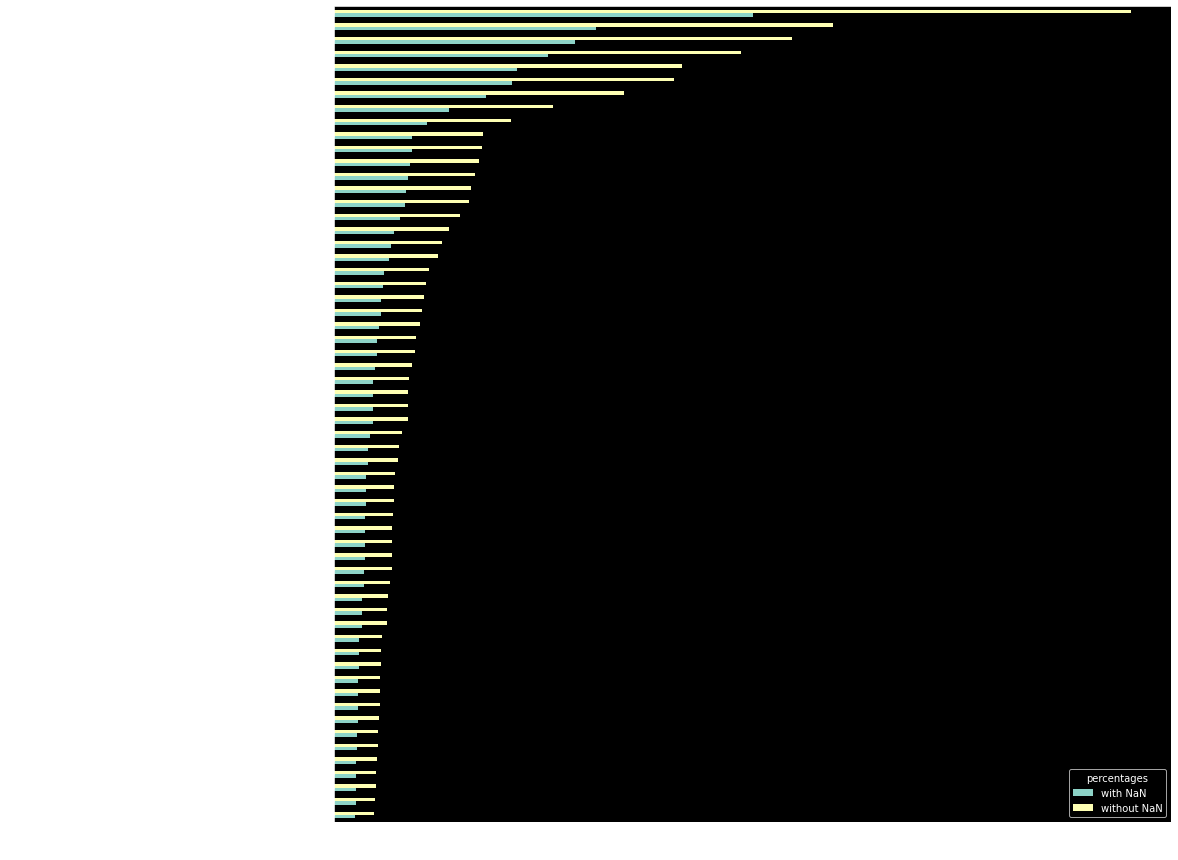

In [35]:
cvcs = pd.concat({'with NaN': df_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': df_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'
cvcs.tail(60).plot(kind='barh', stacked=False, figsize=(15, 15))
plt.xlabel('percentages (%)')
plt.show()

## Categorical variables

### Unique classes per label

In [36]:
num_unique_labels = df[LABELS].apply(pd.Series.nunique)
print(num_unique_labels)
print('            Total:',num_unique_labels.sum())

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64
            Total: 104


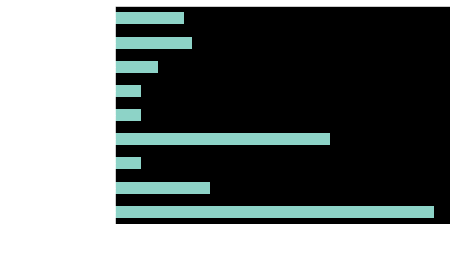

In [37]:
num_unique_labels.plot(kind='barh')
plt.xlabel('Number of unique values')
plt.ylabel('Labels')
plt.show()

### Encoding labels as categories to optimize memory and performance

In [38]:
#Converting label columns to category type
print('Memory before encoding: {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after encoding : {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))

Memory before encoding: 87.5 MB (556.6 MB deep)
Memory after encoding : 63.4 MB (321.0 MB deep)


### Observations per groups of labels

[Grouping by categoricals will show unused categories](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html?highlight=groupby%20sum#operations)

Those can avoided by using `observed=True`

In [39]:
# label_group = df.groupby(LABELS).size()[lambda x: x>0].sort_values().to_frame('observations')
label_group = df.groupby(LABELS, observed=True).size().sort_values().to_frame('observations')
label_group

observations
Function                     Object_Type              Operating_Status  Position_Type Pre_K    Reporting  Sharing                 Student_Type      Use                                      
Career & Academic Counseling Contracted Services      PreK-12 Operating NO_LABEL      Non PreK Non-School Shared Services         At Risk           Pupil Services & Enrichment             1
Student Assignment           Travel & Conferences     PreK-12 Operating NO_LABEL      NO_LABEL Non-School Leadership & Management Special Education Leadership                              1
Library & Media              Benefits                 PreK-12 Operating Other         Non PreK School     School Reported         Special Education Instruction                             1
Professional Development     Travel & Conferences     PreK-12 Operating Non-Position  NO_LABEL Non-School Shared Services         Poverty           ISPD                                    1
Curriculum Development       Base Salary/Compensation PreK-12 Operating TA            NO_LABEL Non-School Leadership & Management ELL               ISPD                                    1
...                                                                                                                                                                                       ...
Teacher Compensation         Base Salary/Compensation PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified       Instruction                         13551
Substitute Compensation      Benefits                 PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified       Instruction                         14110
                             Base Salary/Compensation PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified       Instruction                         16130
Teacher Compensation         Benefits                 PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified       Instruction                         22169
NO_LABEL                     NO_LABEL                 Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL                NO_LABEL          NO_LABEL                            48034

[5489 rows x 1 columns]

### Groups of labels with less than 2 samples (unsplittable)

In [40]:
label_group.loc[label_group.observations < 2,:]

,,,,,,,,,observations
Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use,
Career & Academic Counseling,Contracted Services,PreK-12 Operating,NO_LABEL,Non PreK,Non-School,Shared Services,At Risk,Pupil Services & Enrichment,1
Student Assignment,Travel & Conferences,PreK-12 Operating,NO_LABEL,NO_LABEL,Non-School,Leadership & Management,Special Education,Leadership,1
Library & Media,Benefits,PreK-12 Operating,Other,Non PreK,School,School Reported,Special Education,Instruction,1
Professional Development,Travel & Conferences,PreK-12 Operating,Non-Position,NO_LABEL,Non-School,Shared Services,Poverty,ISPD,1
Curriculum Development,Base Salary/Compensation,PreK-12 Operating,TA,NO_LABEL,Non-School,Leadership & Management,ELL,ISPD,1
...,...,...,...,...,...,...,...,...,...
Data Processing & Information Services,Other Compensation/Stipend,PreK-12 Operating,Instructional Coach,NO_LABEL,School,School Reported,Poverty,Business Services,1
Research & Accountability,Contracted Services,PreK-12 Operating,NO_LABEL,Non PreK,Non-School,Shared Services,Unspecified,Leadership,1
Other Non-Compensation,Equipment & Equipment Lease,PreK-12 Operating,Non-Position,NO_LABEL,Non-School,Shared Services,Special Education,Instruction,1


### Converting labels in dummy variables

Double underscore conventioned by the competition

In [41]:
# Converting labels in dummy variables
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
dummy_labels

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
364634,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109283,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
102430,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
413949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
433672,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### Class count

In [42]:
dummy_labels.sum().sort_values()

Function__Facilities Planning              29
Function__Insurance                        57
Function__Development & Fundraising        93
Position_Type__Nurse Aide                  95
Function__Legal                           117
                                        ...  
Student_Type__Unspecified              223026
Sharing__School Reported               254433
Reporting__School                      257258
Pre_K__NO_LABEL                        306425
Operating_Status__PreK-12 Operating    343578
Length: 104, dtype: int64

### Class proportions

In [43]:
dummy_labels.mean().sort_values()

Function__Facilities Planning          0.000072
Function__Insurance                    0.000142
Function__Development & Fundraising    0.000232
Position_Type__Nurse Aide              0.000237
Function__Legal                        0.000292
                                         ...   
Student_Type__Unspecified              0.557179
Sharing__School Reported               0.635642
Reporting__School                      0.642700
Pre_K__NO_LABEL                        0.765532
Operating_Status__PreK-12 Operating    0.858351
Length: 104, dtype: float64

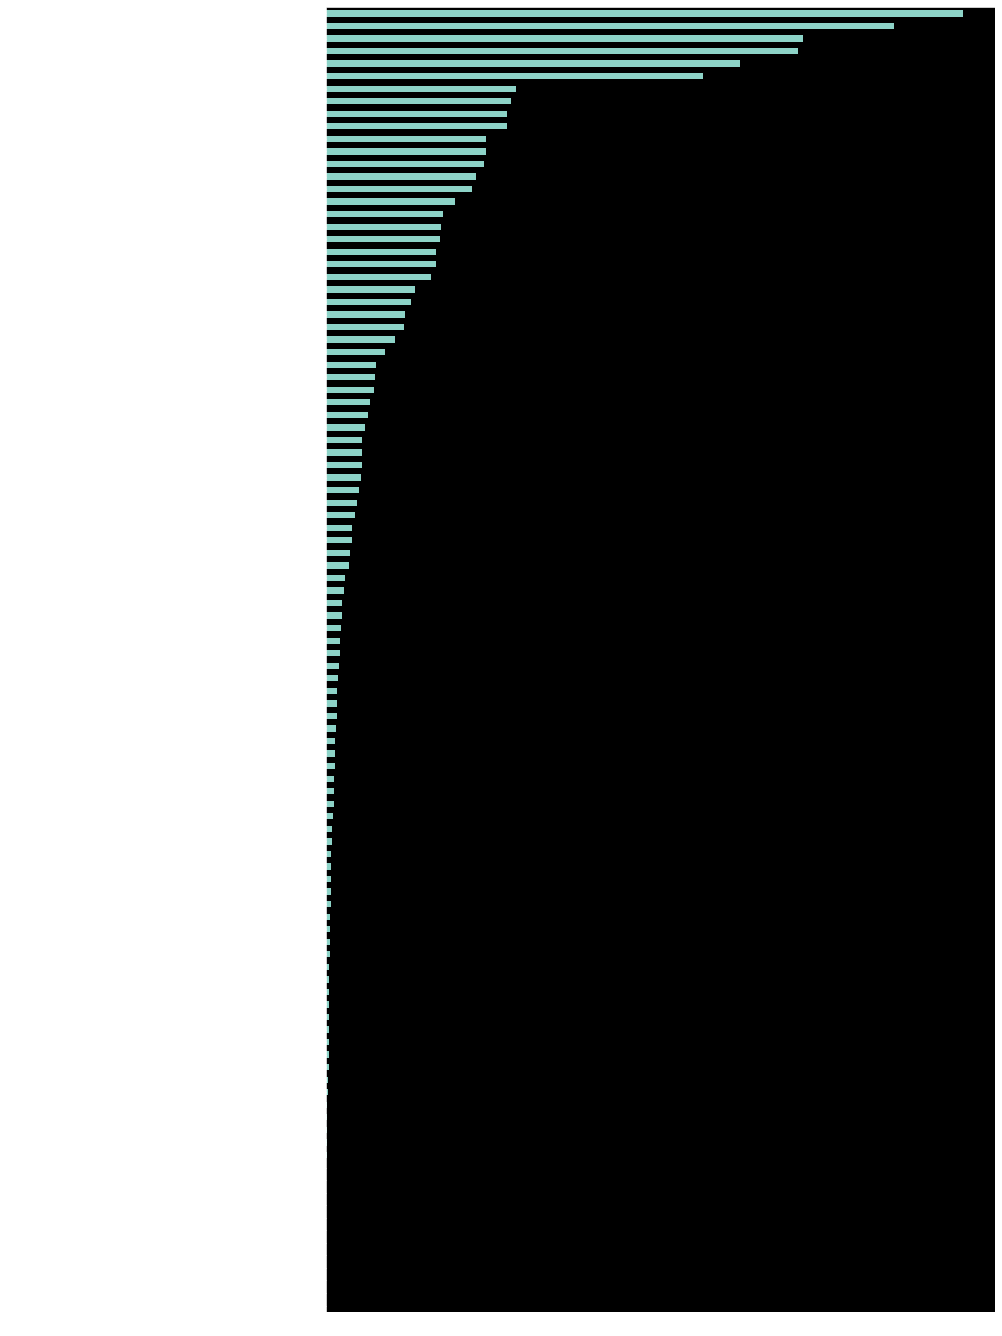

In [44]:
dummy_labels.mean().sort_values().plot(kind='barh', figsize=(12,24)); plt.show()

# Exploring holdout data

In [45]:
holdout=pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50064 entries, 180042 to 249087
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Object_Description      48330 non-null  object 
 1   Program_Description     44811 non-null  object 
 2   SubFund_Description     16111 non-null  object 
 3   Job_Title_Description   32317 non-null  object 
 4   Facility_or_Department  2839 non-null   object 
 5   Sub_Object_Description  33612 non-null  object 
 6   Location_Description    37316 non-null  object 
 7   FTE                     19605 non-null  float64
 8   Function_Description    46866 non-null  object 
 9   Position_Extra          13813 non-null  object 
 10  Text_4                  2814 non-null   object 
 11  Total                   49404 non-null  float64
 12  Text_2                  4641 non-null   object 
 13  Text_3                  5784 non-null   object 
 14  Fund_Description        39586 no

This holdout dataset has no labels due to the secrecy of the competition, but let's compare de column alignments:

In [46]:
FEATURES

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [47]:
display(list(zip(FEATURES, holdout.columns.values)))
all(FEATURES == holdout.columns.values)

[('Object_Description', 'Object_Description'),
 ('Text_2', 'Program_Description'),
 ('SubFund_Description', 'SubFund_Description'),
 ('Job_Title_Description', 'Job_Title_Description'),
 ('Text_3', 'Facility_or_Department'),
 ('Text_4', 'Sub_Object_Description'),
 ('Sub_Object_Description', 'Location_Description'),
 ('Location_Description', 'FTE'),
 ('FTE', 'Function_Description'),
 ('Function_Description', 'Position_Extra'),
 ('Facility_or_Department', 'Text_4'),
 ('Position_Extra', 'Total'),
 ('Total', 'Text_2'),
 ('Program_Description', 'Text_3'),
 ('Fund_Description', 'Fund_Description'),
 ('Text_1', 'Text_1')]

False

**Columns between these datasets were not aligned until here:**

In [48]:
holdout = holdout[FEATURES]
all(FEATURES == holdout.columns.values)

True

## Missing data **(TODO: replicate df stats)**

Overall count and proportion of missing data compared to training data:

In [49]:
missing_holdout = holdout.isnull()
pd.DataFrame({'dataset':  ['training', 'holdout'],
              'missing':    [missing.sum().sum(), missing_holdout.sum().sum()],
              'proportion': [missing.sum().sum() / (missing.shape[0] * missing.shape[1]),
                             missing_holdout.sum().sum() / (holdout.shape[0] * holdout.shape[1])]}).set_index('dataset')

,missing,proportion
dataset,,
training,2942109,0.294007
holdout,387797,0.484127


**The proportion of missing data in the holdout set is much bigger.**

Comparing missing heatmaps between datasets

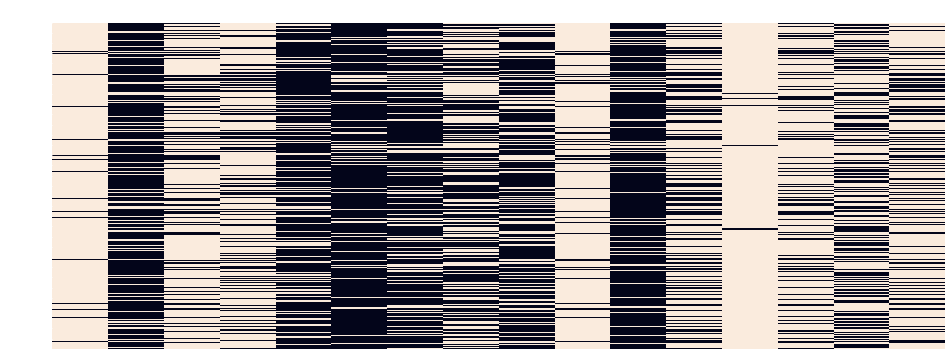

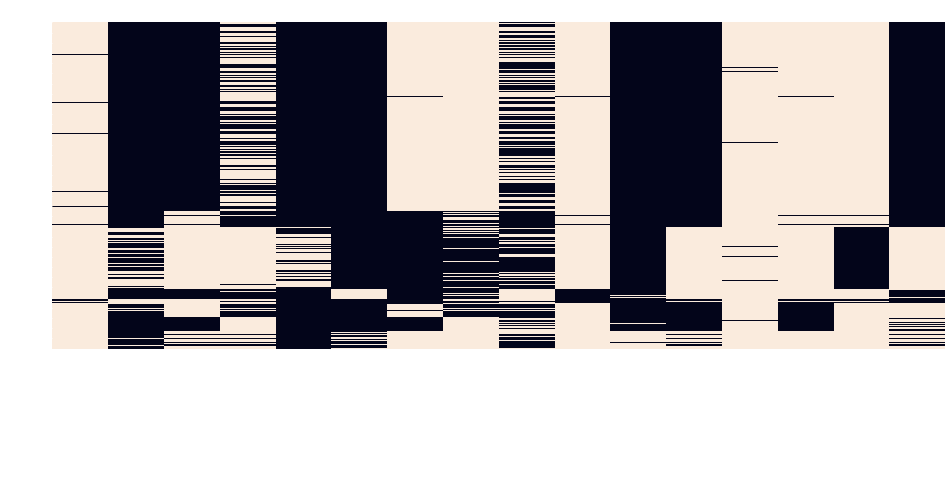

In [50]:
plt.figure(figsize=(16,6))
sns.heatmap(~missing[FEATURES], cbar=False, xticklabels=False)
plt.title('Training set')
plt.figure(figsize=(16,6))
sns.heatmap(~missing_holdout, cbar=False)
plt.title('Holdout set')
plt.show()

Comparing the heatmaps became suspect that the holdout dataset is not just a fair random sample because it's missing data pattern differs a lot from the training dataset.

Next, the columns of both datasets are ordered by the columns of training set with less missing data first. The idea is to compare some sort of missing proportion clusters.

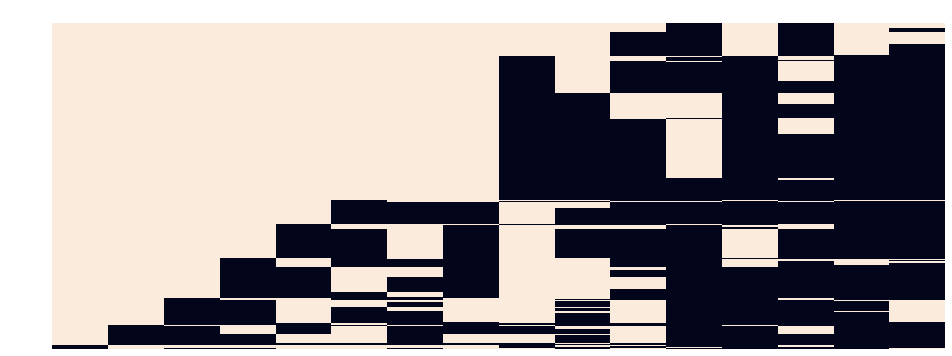

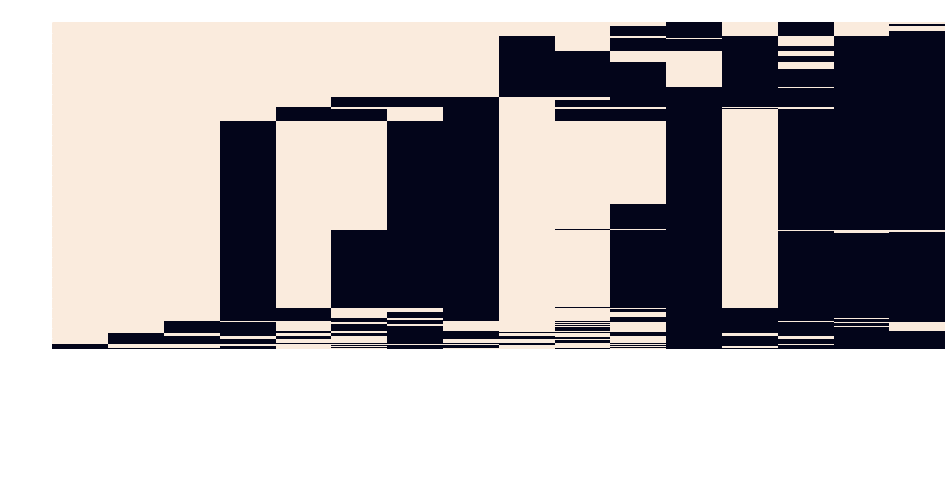

In [51]:
freq_col_order = missing[FEATURES].sum().sort_values().index.to_list()
plt.figure(figsize=(16,6))
sns.heatmap(~missing[freq_col_order].sort_values(freq_col_order), cbar=False, xticklabels=False)
plt.title('Training set')
plt.figure(figsize=(16,6))
sns.heatmap(~missing_holdout[freq_col_order].sort_values(freq_col_order), cbar=False)
plt.title('Holdout set')
plt.show()

Some missing value areas are proportionally bigger in the holdout set, which is confirmed by the missing ratio which differs a lot.

In [52]:
(missing_report(holdout)['column proportion'] / missing_report(df[FEATURES])['column proportion']).sort_values(ascending=False)

SubFund_Description       2.905789
Text_1                    2.568016
Position_Extra            2.138819
Job_Title_Description     1.319515
Text_3                    1.216083
Text_2                    1.163785
Total                     1.158486
Text_4                    1.090171
Facility_or_Department    1.090035
FTE                       0.888124
Object_Description        0.559388
Function_Description      0.440222
Program_Description       0.439246
Location_Description      0.427852
Sub_Object_Description    0.426141
Fund_Description          0.424391
Name: column proportion, dtype: float64

## FTE

In [53]:
holdout.FTE.describe()

count    1.960500e+04
mean     1.349004e+00
std      8.468634e+01
min     -1.917398e-07
25%      5.000000e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.185724e+04
Name: FTE, dtype: float64

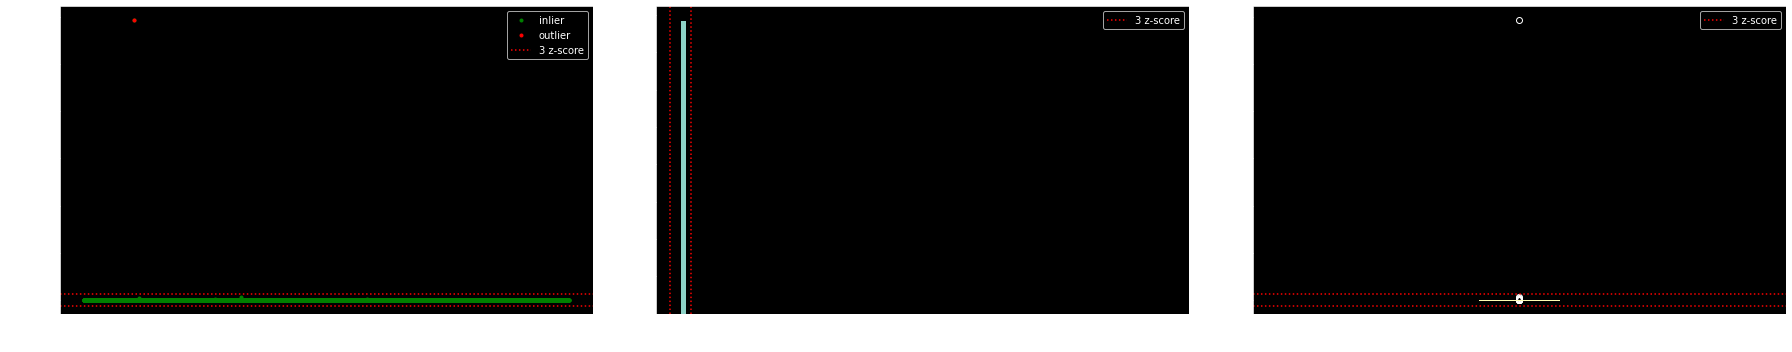

Upper outliers: 1
Lower outliers: 0


In [54]:
fte = holdout.FTE.dropna()
density_plots(fte, 'FTE', bins=100)
zscores = zscore(fte)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has only one `FTE` outlier with a value never seen so high in the whole training set: near `11857.24`, while the max `FTE` in training set is `46.8`.

This specific outlier has not textual data.

In [55]:
holdout[holdout.FTE == holdout.FTE.max()].transpose()

,46063
Object_Description,NaN
Text_2,NaN
SubFund_Description,NaN
Job_Title_Description,NaN
Text_3,NaN
Text_4,NaN
Sub_Object_Description,NaN
Location_Description,NaN
FTE,11857.24475
Function_Description,NaN


Searching for other observations with no textual data:

In [56]:
holdout[holdout[TEXT_FEATURES].isnull().all(axis=1)]

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
46063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11857.24475,NaN,NaN,NaN,1.153578e+09,NaN,NaN,NaN
71261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.398000e+01,NaN,NaN,NaN
42179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.182400e+03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.861900e+03,NaN,NaN,NaN
90738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.738370e+03,NaN,NaN,NaN
143636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.427740e+03,NaN,NaN,NaN
433295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.452000e+01,NaN,NaN,NaN


There are 116 other observations without textual data.

## Total

In [57]:
holdout.Total.describe()

count    4.940400e+04
mean     5.115880e+04
std      5.228060e+06
min     -2.370180e+06
25%      2.992925e+02
50%      2.743975e+03
75%      3.341465e+04
max      1.153578e+09
Name: Total, dtype: float64

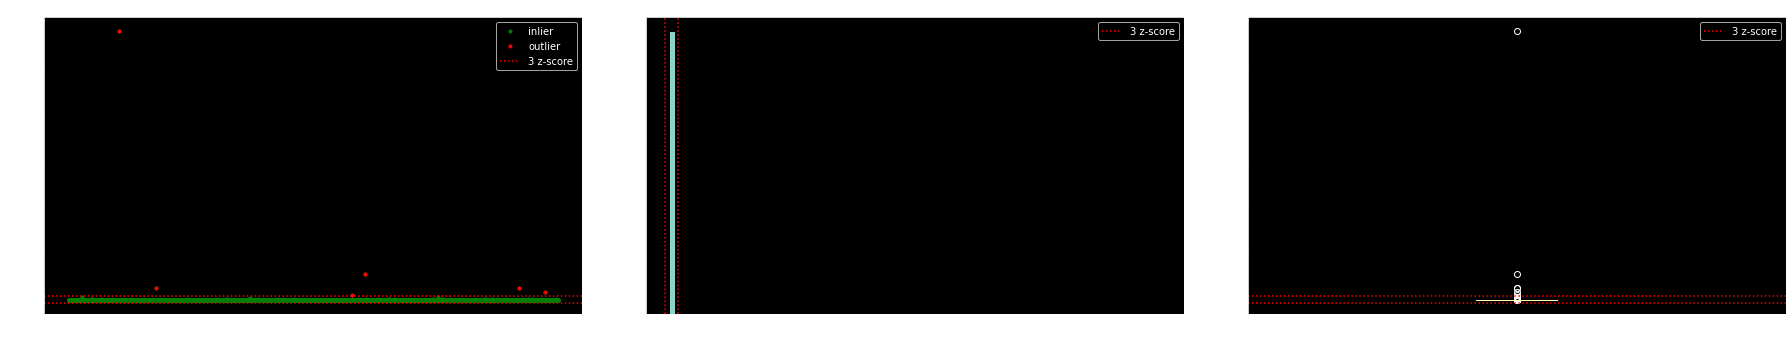

Upper outliers: 6
Lower outliers: 0


In [58]:
total = holdout.Total.dropna()
density_plots(total, 'Total', bins=100)
zscores = zscore(total)
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

In [59]:
holdout[holdout.Total == holdout.Total.max()].transpose()

,46063
Object_Description,NaN
Text_2,NaN
SubFund_Description,NaN
Job_Title_Description,NaN
Text_3,NaN
Text_4,NaN
Sub_Object_Description,NaN
Location_Description,NaN
FTE,11857.24475
Function_Description,NaN


## Free text form variables

### Text features frequencies

In [60]:
cross_value_counts(holdout[TEXT_FEATURES])

columns,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
text,,,,,,,,,,,,,,
NaN,1734,45423,33953,17747,44280,47250,16452,12748,3198,47225,36251,5253,10478,34686
GENERAL FUND,0,0,6525,0,0,0,0,0,0,0,0,0,25151,0
SCHOOL,0,0,0,0,0,0,0,25531,0,0,0,0,0,0
GENERAL,1,0,0,0,0,0,19704,0,0,0,0,0,413,0
INSTRUCTION,0,0,0,0,0,0,0,0,15655,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCHER BEHAVIOR MODIF MIDDLE,0,0,0,1,0,0,0,0,0,0,0,0,0,0
MEDIA SVCS SPEC,0,0,0,1,0,0,0,0,0,0,0,0,0,0
TCHER SPEC ED MID SATELLITE,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Text features frequency summary

In [61]:
holdout_cvcs = cross_value_counts_summary(holdout[TEXT_FEATURES])
holdout_cvcs

,Ocurrences,Columns,% w/NaN,% wo/NaN,Cumulated % wo/NaN,words
text,,,,,,
NaN,356678,14,50.888863,0.000000,0.000000,1
GENERAL FUND,31676,2,4.519358,9.202308,9.202308,2
SCHOOL,25531,1,3.642623,7.417102,16.619410,1
GENERAL,20118,3,2.870326,5.844552,22.463963,1
INSTRUCTION,15655,1,2.233570,4.547990,27.011951,1
...,...,...,...,...,...,...
TCHER BEHAVIOR MODIF MIDDLE,1,1,0.000143,0.000291,99.998840,4
MEDIA SVCS SPEC,1,1,0.000143,0.000291,99.999130,3
TCHER SPEC ED MID SATELLITE,1,1,0.000143,0.000291,99.999420,5


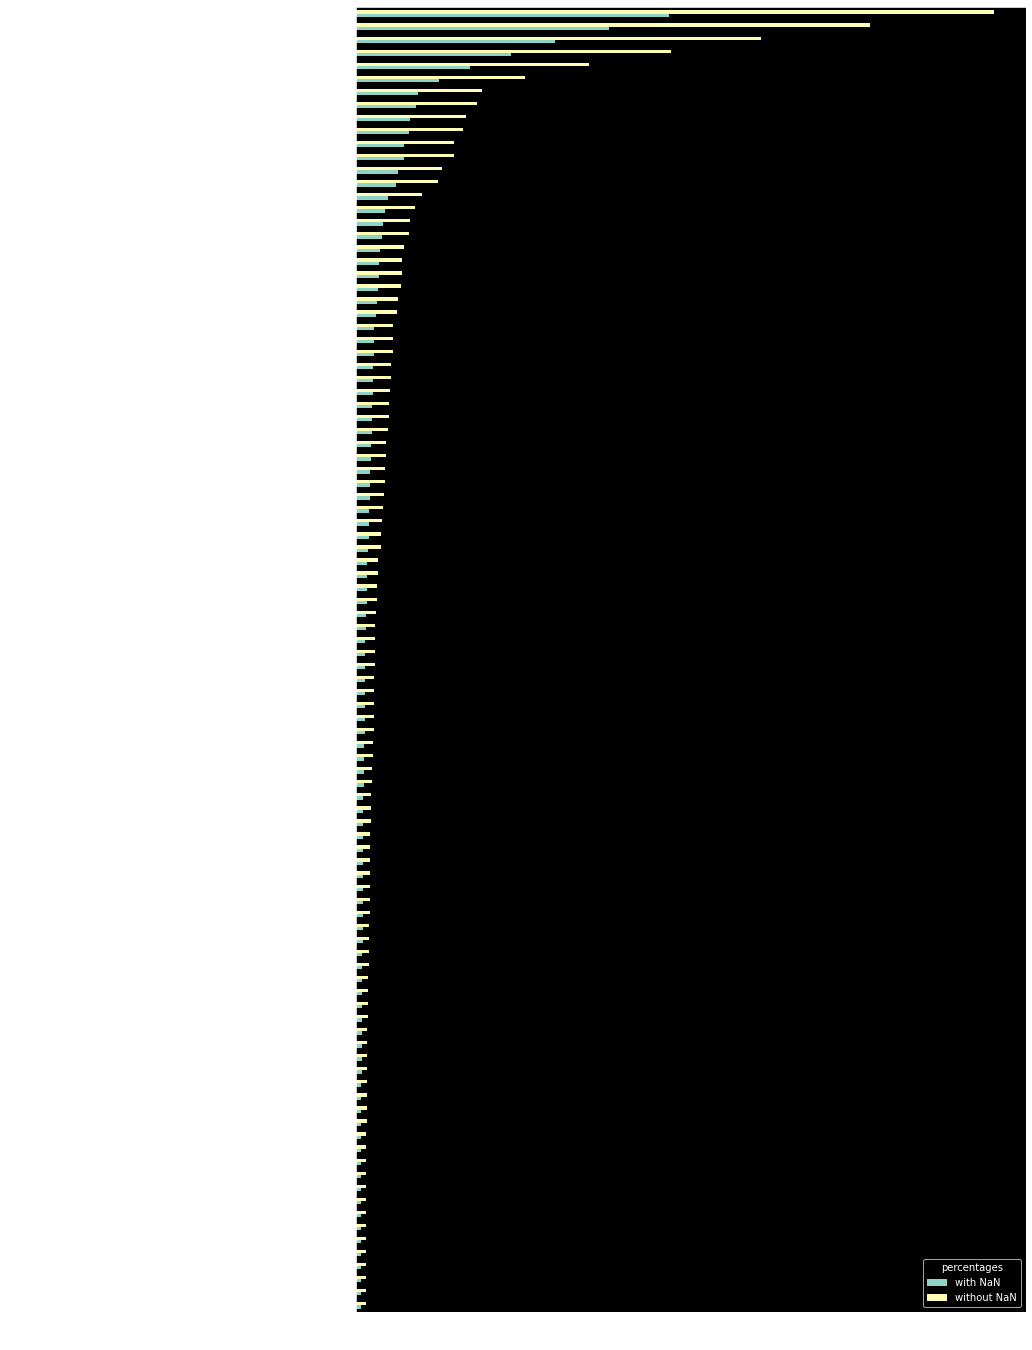

In [62]:
cvcs = pd.concat({'with NaN': holdout_cvcs['% w/NaN'].drop('NaN'),
                  'without NaN': holdout_cvcs['% wo/NaN'].drop('NaN')},
                 axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
cvcs.index.name='text'
cvcs.columns.name='percentages'

cvcs.tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

### Comparing training-holdout text frequency summaries

percentages,train,holdout
text,,
GENERAL FUND,6.139676,9.202308
EMPLOYEE BENEFITS,3.843661,1.747439
REGULAR,3.527663,1.592595
PROFESSIONAL INSTRUCTIONAL,3.133313,1.413349
REGULAR INSTRUCTION,2.679211,1.236135
...,...,...
WAN MANAGER,0.000000,0.000291
WEB MANAGER,0.000000,0.000291
WELDER,0.000000,0.000291


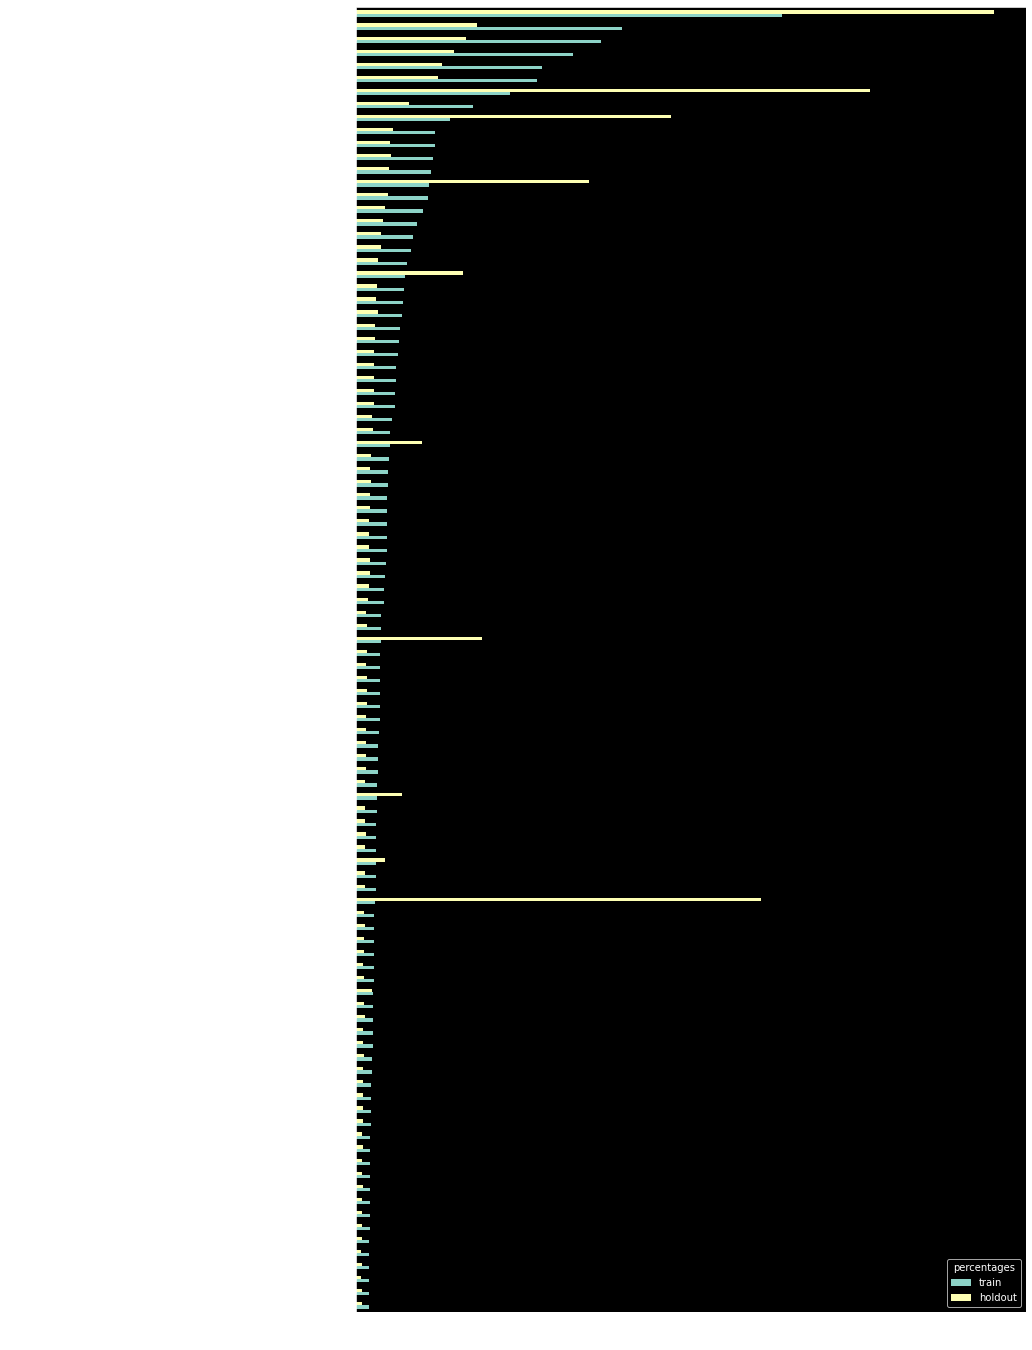

In [63]:
cvcs = pd.concat({'train': df_cvcs['% wo/NaN'],
                  'holdout': holdout_cvcs['% wo/NaN']},
                 axis=1, sort=True).fillna(0).sort_values(['train', 'holdout'], ascending=False)
cvcs.index.name='text'
cvcs.columns.name='percentages'
display(cvcs)
cvcs.sort_values(['train', 'holdout']).tail(100).plot(kind='barh', stacked=False, figsize=(12, 24))
plt.xlabel('percentages (%)')
plt.show()

# Imputation strategy

Text features will be combined, tokenized and counted in different n-gram ranges.

For numeric features:
* Generate a binary indicator for missing `FTE`
* Generate a binary indicator for missing `Total`
* Create a new numeric variable `Total_FTE` with default value `NaN`
* If `FTE` is not null and not zero, then `Total_FTE` = `Total` and `Total` = `NaN`
* TODO: Impute zero in remaining missing `FTE`, `Total`, and `Total_FTE`?

In [64]:
from preprocessing.get_normalized_total import get_normalized_total

In [65]:
df[NUMERIC_FEATURES].info()
df[NUMERIC_FEATURES].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     126071 non-null  float64
 1   Total   395722 non-null  float64
dtypes: float64(2)
memory usage: 17.2 MB


,FTE,Total
134338,1.0,50471.810
206341,NaN,3477.860
326408,1.0,62237.130
364634,NaN,22.300
47683,NaN,54.166


In [66]:
get_normalized_total(df, 'FTE', 'Total').info()
get_normalized_total(df, 'FTE', 'Total').head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FTE            126071 non-null  float32
 1   Total          302248 non-null  float32
 2   FTE_missing    400277 non-null  uint8  
 3   Total_missing  400277 non-null  uint8  
 4   Total_FTE      93474 non-null   float32
dtypes: float32(3), uint8(2)
memory usage: 16.5 MB


,FTE,Total,FTE_missing,Total_missing,Total_FTE
134338,1.0,NaN,0,0,50471.808594
206341,NaN,3477.860107,1,0,NaN
326408,1.0,NaN,0,0,62237.128906
364634,NaN,22.299999,1,0,NaN
47683,NaN,54.166000,1,0,NaN


# The log loss

Log loss for binary classification
$$logloss = - \frac{1}{N}\sum^N_{i=1}{(y_i log(p_i) + (1-y_i)log(1-p_i))}$$

>Better to be less confident than confident and wrong

In [67]:
from metrics.log_loss import log_loss

Wrong and confident       : 34.538776394910684
Wrong and not confident   : 0.916290731874155
Correct and not confident : 0.5108256237659907
Correct and confident     : 9.992007221626415e-16


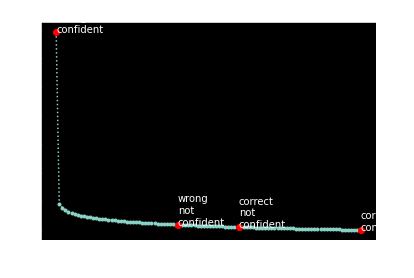

In [68]:
print('Wrong and confident       :', log_loss(actual =1, predicted=0))
print('Wrong and not confident   :', log_loss(actual=1, predicted=0.4))
print('Correct and not confident :', log_loss(actual=1, predicted=0.6))
print('Correct and confident     :', log_loss(actual=1, predicted=1))
predicts = np.linspace(0,1,100)
lloss = [log_loss(1,x) for x in predicts]
plt.plot(predicts, lloss, marker='.', linestyle='dotted')
points = [0, 0.4, 0.6, 1]
classes = ['wrong\nconfident', 'wrong\nnot\nconfident', 'correct\nnot\nconfident', 'correct\nconfident']
for i, x in enumerate(points):
    y=log_loss(actual=1, predicted=x)
    plt.plot(x, y, 'ro')
    plt.text(x, y, s=classes[i])
plt.title('Range: {0:} to {1:.2f}'.format(lloss[-1], lloss[0]))
plt.xlabel('predicted')
plt.ylabel('logloss')
plt.show()

 Log loss penalizes highly confident wrong answers much more than any other type. This is a good metric to use in this model and required by the competition.

# The multi-class multi-label log loss

In [69]:
from metrics.log_loss import multi_multi_log_loss
from dummies import get_dummies_indices
cci = get_dummies_indices(df[LABELS])

# Simple model: only numeric features

In [70]:
from model_selection.multilabel import multilabel_train_test_split

## Setting up a train-test split

* Selecting just numeric features: `df[NUMERIC_FEATURES]`

* Selecting labels as binary variables for multi-label targets: `dummy_labels`

In [71]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NUMERIC_FEATURES], dummy_labels,
                                                               size=0.2, min_count=0, seed=1)

print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     100992 non-null  float64
 1   Total   316574 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     25079 non-null  float64
 1   Total   79148 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 364634 to 375092
Columns: 104 entries, Funct

## Allways pre-process after splitting

In [72]:
from sklearn.preprocessing import maxabs_scale

X_train = get_normalized_total(X_train, 'FTE', 'Total')
X_train = X_train.fillna(0)
X_train[:] = maxabs_scale(X_train)

X_test = get_normalized_total(X_test, 'FTE', 'Total')
X_test = X_test.fillna(0)
X_test[:] = maxabs_scale(X_test)

## Training a model

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [74]:
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [75]:
t=time()
# clf.fit(X_train, y_train)
clf.fit(X_train.values, y_train)  # fit without feature names to avoid warning on predict of features that maxabs_scale removes names from
print('Elapsed:', time() - t)

Elapsed: 19.3255934715271


## Model metrics

In [76]:
# print("Training Accuracy:", clf.score(X_train, y_train))
print("Training Accuracy:", clf.score(X_train.values, y_train))  # score without feature names to avoid as train doesn't have them too

Training Accuracy: 0.04463153687129554


In [77]:
# y_pred = clf.predict_proba(X_train)
y_pred = clf.predict_proba(X_train.values)  # predict_proba without feature names to avoid as train doesn't have them too
print("Training Logloss:", multi_multi_log_loss(y_train, y_pred, class_column_indices=cci))

Training Logloss: 1.2916546628862906


In [78]:
# print("Testing Accuracy:", clf.score(X_test, y_test))
print("Testing Accuracy:", clf.score(X_test.values, y_test))  # score without feature names to avoid as train doesn't have them too

Testing Accuracy: 0.04204609331084879


In [79]:
# y_pred = clf.predict_proba(X_test)
y_pred = clf.predict_proba(X_test.values)  # predict_proba without feature names to avoid as train doesn't have them too
print("Testing Logloss:", multi_multi_log_loss(y_test, y_pred, class_column_indices=cci))

Testing Logloss: 1.2976415720423216


In [80]:
# y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test.values) # predict without feature names to avoid as train doesn't have them too
print("Testing Classification Report:\n", classification_report(y_test, y_pred))

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3892
           1       0.00      0.00      0.00       604
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00      1472
           4       0.00      0.00      0.00       678
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2152
           7       0.00      0.00      0.00      1652
           8       0.00      0.00      0.00      3969
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       470
          11       1.00      0.00      0.00      2831
          12       0.00      0.00      0.00       141
          13       0.00      0.00      0.00       240
          14       0.00      0.00      0.00      3845
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00      

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Use your model to predict values on holdout data

In [81]:
# Realigning features according to train features
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)[FEATURES]
predictions = clf.predict_proba(maxabs_scale(get_normalized_total(holdout, 'FTE', 'Total').fillna(0)))

## Writing out your results to a csv for submission
At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a .csv using the .to_csv() method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the correct format.

To do this, you'll use your predictions values to create a new DataFrame, prediction_df.

Interpreting LogLoss & Beating the Benchmark:

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

In [82]:
prediction_df = pd.DataFrame(columns=dummy_labels.columns,
                             index=holdout.index,
                             data=predictions)#.apply(lambda x: x.astype('category'), axis=0)
prediction_df.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.036536,0.006513,0.000880,0.024430,0.008810,0.000189,0.032018,0.024375,0.052467,0.000102,...,0.086929,0.519427,0.016240,0.073558,0.441159,0.038992,0.250572,0.115059,0.062636,0.001153
28872,0.036536,0.006513,0.000880,0.024430,0.008810,0.000189,0.032018,0.024375,0.052467,0.000102,...,0.086930,0.519430,0.016240,0.073559,0.441163,0.038992,0.250568,0.115059,0.062636,0.001153
186915,0.088494,0.006064,0.000581,0.008633,0.004986,0.000431,0.021121,0.019747,0.038258,0.000135,...,0.146230,0.703230,0.010684,0.047727,0.691183,0.026220,0.059500,0.134092,0.048413,0.000320
412396,0.088481,0.006064,0.000581,0.008633,0.004986,0.000431,0.021117,0.019743,0.038258,0.000135,...,0.146229,0.703220,0.010685,0.047728,0.691187,0.026223,0.059501,0.134072,0.048415,0.000320
427740,0.088513,0.006063,0.000581,0.008634,0.004985,0.000431,0.021125,0.019752,0.038258,0.000135,...,0.146231,0.703242,0.010683,0.047726,0.691178,0.026216,0.059498,0.134118,0.048411,0.000320


In [83]:
prediction_df.to_csv('/data/drivendata/predictions/2022/0.8-numeric-features-logistic-regression-C1.csv')

Your score for this submission is 1.3252 (30-6-2020)

# Improving your model: NLP

## Combining text features for tokenization

Here all text features are concatenated in each row.

Each row becomes a single document.

In [84]:
from preprocessing.combine_text_columns import combine_text_columns

In [85]:
t=time()
text_vector = combine_text_columns(df, to_drop=NUMERIC_FEATURES + LABELS)
print('Elapsed', time()-t)
text_vector

Elapsed 1.714414119720459


134338                                                                                                                                                                                                                                                                                    Teacher-Elementary        KINDERGARTEN  KINDERGARTEN General Fund 
206341                                                                                                                                                                                            CONTRACTOR SERVICES BOND EXPENDITURES BUILDING FUND (blank) Regular    RGN  GOB  UNDESIGNATED BUILDING IMPROVEMENT SERVICES  BUILDING IMPROVEMENT SERVICES
326408                                                                                                                                                                                                                         Personal Services - Teachers   TCHER 2ND GRADE  Regular Instruction     TEACHER

In [86]:
print('Memory size {}:', size(sys.getsizeof(text_vector)))

Memory size {}: 97.1 MiB


##  **[REVIEW]** Bag-of-Words

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

Unigram (word) statistics:

CountVectorizer elapsed time: 2.8807263374328613


<400277x3728 sparse matrix of type '<class 'numpy.int64'>'
	with 6290672 stored elements in Compressed Sparse Row format>

,00a,12,1st,2nd,3rd,4th,56,5th,60,60hrs,...,yr,yrbs,yrs,yth,zero,zeta,zone,zoo,zuni,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sparsity                           : 0.9957843892675138
Max term frequency in a document   : 6
Max term frequency in all documents: 331001
Max words in a document            : 49
Mean words per document            : 19.3
Median words per document          : 18.0
Sparse matrix memory usage         : 73.5 MiB
Dense matrix memory equivalence    : 11.1 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5111160,0.812498
1,2,964685,0.153352
2,3,170352,0.027080
3,4,35572,0.005655
4,5,7678,0.001221
5,6,1225,0.000195


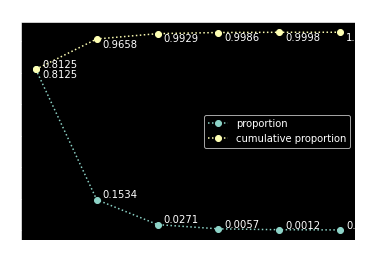

In [88]:
vec = CountVectorizer()
t=time()
tdm = vec.fit_transform(text_vector)
print('CountVectorizer elapsed time:',time()-t)
display(tdm)

# display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names())) # deprecated
display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names_out()))    

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max term frequency in a document   : {}'.format(tdm.max()))
print('Max term frequency in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max words in a document            : {}'.format(tdm.sum(axis=1).max()))
print('Mean words per document            : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median words per document          : {}'.format(np.median(np.array(tdm.sum(axis=1)))))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*np.int64().itemsize))

print('Non-zero probabilities:', end='')
nz_bin_count = [[bin, (tdm == bin).sum(), (tdm == bin).sum()/tdm.nnz] for bin in range(1, tdm.max() + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))

bin, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.plot(bin, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bin[i]+.1, count[i], '{:.4f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bin, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bin[i]+.1, cumcount[i], '{:.4f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

* **`81%` of the words appear only `1`  time in the rows of the `text_vector`**
* **`99%` of the words appear from `1` to `3` times in the rows of the `text_vector`**

## Tokenizing n-gram ranges

The `CountVectorizer` default `dtype` is `int64`.  As the maximum frequency of any token in a single observation is 6, the 8-bits unsigned integer `uint8` (0 to 255) is enough to store counts of any ngram range.

Iterating over all possible n-gram ranges: `tdm.sum(axis=1).max()`

In [89]:
# tracemalloc.start()
# msg = 'ngram:{},{} cols:{} maxtf:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for ngram_range in [(1,x) for x in range(1, 50)]: # 49 is the max number of words per document
#     t=time()
#     vec = CountVectorizer(ngram_range = ngram_range, dtype='uint8')
#     tdm = vec.fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     #tracemalloc.reset_peak()
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#     print(msg.format(ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(),
#                      tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes),
#                      size(current), size(peak), t))
# tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-20 21:46:18 in 57m 12.64s
ngram:1,1 cols:3728 maxtf:6 nnz:6290672 sparse:99.58% size:31.5 MiB cur:32.1 MiB peak:116.4 MiB 6s
ngram:1,2 cols:32572 maxtf:6 nnz:13167763 sparse:99.90% size:64.3 MiB cur:68.5 MiB peak:265.2 MiB 11s
ngram:1,3 cols:91308 maxtf:6 nnz:19888976 sparse:99.95% size:96.4 MiB cur:109.9 MiB peak:417.7 MiB 16s
ngram:1,4 cols:181493 maxtf:6 nnz:26296018 sparse:99.96% size:126.9 MiB cur:154.7 MiB peak:574.1 MiB 20s
ngram:1,5 cols:304059 maxtf:6 nnz:32351187 sparse:99.97% size:155.8 MiB cur:197.1 MiB peak:721.1 MiB 25s
ngram:1,6 cols:457658 maxtf:6 nnz:38050953 sparse:99.98% size:183.0 MiB cur:252.4 MiB peak:884.1 MiB 30s
ngram:1,7 cols:639083 maxtf:6 nnz:43383271 sparse:99.98% size:208.4 MiB cur:300.5 MiB peak:1.0 GiB 35s
ngram:1,8 cols:843382 maxtf:6 nnz:48343036 sparse:99.99% size:232.0 MiB cur:371.2 MiB peak:1.2 GiB 40s
ngram:1,9 cols:1065609 maxtf:6 nnz:52924082 sparse:99.99% size:253.9 MiB cur:424.1 MiB peak:1.3 GiB 44s
ngram:1,10 cols:1299651 maxtf:6 nnz:57123587 sparse:99.99% size:273.9 MiB cur:478.6 MiB peak:1.5 GiB 48s
ngram:1,11 cols:1538143 maxtf:6 nnz:60946572 sparse:99.99% size:292.1 MiB cur:573.7 MiB peak:1.6 GiB 52s
ngram:1,12 cols:1774565 maxtf:6 nnz:64407007 sparse:99.99% size:308.6 MiB cur:628.6 MiB peak:1.8 GiB 56s
ngram:1,13 cols:2003991 maxtf:6 nnz:67516090 sparse:99.99% size:323.5 MiB cur:682.4 MiB peak:1.9 GiB 59s
ngram:1,14 cols:2222412 maxtf:6 nnz:70289409 sparse:99.99% size:336.7 MiB cur:734.3 MiB peak:2.0 GiB 63s
ngram:1,15 cols:2426477 maxtf:6 nnz:72749237 sparse:99.99% size:348.4 MiB cur:783.7 MiB peak:2.1 GiB 65s
ngram:1,16 cols:2614225 maxtf:6 nnz:74920467 sparse:99.99% size:358.8 MiB cur:830.2 MiB peak:2.2 GiB 67s
ngram:1,17 cols:2784291 maxtf:6 nnz:76826841 sparse:99.99% size:367.9 MiB cur:873.2 MiB peak:2.3 GiB 70s
ngram:1,18 cols:2936736 maxtf:6 nnz:78490890 sparse:99.99% size:375.8 MiB cur:992.7 MiB peak:2.5 GiB 72s
ngram:1,19 cols:3071856 maxtf:6 nnz:79935242 sparse:99.99% size:382.7 MiB cur:1.0 GiB peak:2.5 GiB 74s
ngram:1,20 cols:3190500 maxtf:6 nnz:81185242 sparse:99.99% size:388.6 MiB cur:1.0 GiB peak:2.6 GiB 75s
ngram:1,21 cols:3294155 maxtf:6 nnz:82262544 sparse:99.99% size:393.8 MiB cur:1.1 GiB peak:2.6 GiB 77s
ngram:1,22 cols:3384554 maxtf:6 nnz:83193456 sparse:99.99% size:398.2 MiB cur:1.1 GiB peak:2.7 GiB 78s
ngram:1,23 cols:3463644 maxtf:6 nnz:84002266 sparse:99.99% size:402.1 MiB cur:1.1 GiB peak:2.7 GiB 79s
ngram:1,24 cols:3533189 maxtf:6 nnz:84705916 sparse:99.99% size:405.4 MiB cur:1.1 GiB peak:2.8 GiB 79s
ngram:1,25 cols:3594644 maxtf:6 nnz:85320470 sparse:99.99% size:408.4 MiB cur:1.2 GiB peak:2.8 GiB 80s
ngram:1,26 cols:3649208 maxtf:6 nnz:85859777 sparse:99.99% size:410.9 MiB cur:1.2 GiB peak:2.8 GiB 81s
ngram:1,27 cols:3697724 maxtf:6 nnz:86334041 sparse:99.99% size:413.2 MiB cur:1.2 GiB peak:2.9 GiB 81s
ngram:1,28 cols:3740841 maxtf:6 nnz:86751560 sparse:99.99% size:415.2 MiB cur:1.2 GiB peak:2.9 GiB 82s
ngram:1,29 cols:3779050 maxtf:6 nnz:87119104 sparse:99.99% size:416.9 MiB cur:1.2 GiB peak:2.9 GiB 82s
ngram:1,30 cols:3812781 maxtf:6 nnz:87440566 sparse:99.99% size:418.5 MiB cur:1.2 GiB peak:2.9 GiB 83s
ngram:1,31 cols:3842324 maxtf:6 nnz:87719094 sparse:99.99% size:419.8 MiB cur:1.2 GiB peak:3.0 GiB 83s
ngram:1,32 cols:3867878 maxtf:6 nnz:87956711 sparse:99.99% size:420.9 MiB cur:1.2 GiB peak:3.0 GiB 84s
ngram:1,33 cols:3889679 maxtf:6 nnz:88156009 sparse:99.99% size:421.9 MiB cur:1.2 GiB peak:3.0 GiB 84s
ngram:1,34 cols:3908002 maxtf:6 nnz:88319906 sparse:99.99% size:422.7 MiB cur:1.3 GiB peak:3.0 GiB 83s
ngram:1,35 cols:3923166 maxtf:6 nnz:88451032 sparse:99.99% size:423.3 MiB cur:1.3 GiB peak:3.0 GiB 83s
ngram:1,36 cols:3935535 maxtf:6 nnz:88554074 sparse:99.99% size:423.8 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,37 cols:3945420 maxtf:6 nnz:88632711 sparse:99.99% size:424.2 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,38 cols:3953125 maxtf:6 nnz:88691248 sparse:99.99% size:424.4 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,39 cols:3958926 maxtf:6 nnz:88732265 sparse:99.99% size:424.6 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,40 cols:3963114 maxtf:6 nnz:88759772 sparse:99.99% size:424.8 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,41 cols:3966091 maxtf:6 nnz:88779173 sparse:99.99% size:424.9 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,42 cols:3968183 maxtf:6 nnz:88792680 sparse:99.99% size:424.9 MiB cur:1.3 GiB peak:3.0 GiB 84s
ngram:1,43 cols:3969642 maxtf:6 nnz:88802396 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,44 cols:3970618 maxtf:6 nnz:88808964 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,45 cols:3971226 maxtf:6 nnz:88812826 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,46 cols:3971537 maxtf:6 nnz:88814674 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,47 cols:3971662 maxtf:6 nnz:88815148 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,48 cols:3971702 maxtf:6 nnz:88815248 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 85s
ngram:1,49 cols:3971712 maxtf:6 nnz:88815268 sparse:99.99% size:425.0 MiB cur:1.3 GiB peak:3.0 GiB 84s
```

## n-gram range frequency plot

In [90]:
# stop_words = CountVectorizer(stop_words='english').get_stop_words()
# for ngram_range in [(1,x) for x in range(1,4)]:
#     vec = CountVectorizer(dtype='uint8', ngram_range=ngram_range)
#     tdm = vec.fit_transform(text_vector)
#     term_freq = pd.DataFrame({'term': vec.get_feature_names_out(),
#                               'proportion': tdm.mean(axis=0).tolist()[0],
#                               #'stop_word': [True if fn in stop_words else False for fn in vec.get_feature_names()]
#                               'stop_word': [True if any([True if word in stop_words else False for word in str.split(words)]) else False for words in vec.get_feature_names_out()]
#                              }).sort_values(['proportion','term'], ascending=(False, True))
#     plt.figure(figsize=(16,15))
#     plt.grid()
#     sns.barplot(x='proportion', y='term', data=term_freq.head(100), hue='stop_word', dodge=False)
#     plt.title('n-gram range {} frequency'.format(ngram_range))
#     plt.show()

## Hashing Trick

* Adding new features (e.g. 3-grams, 4-grams) may cause enormous increase in array size
* Hashing is a way of increasing memory efficiency
* Want to make array of features as small as possible: dimensionality Reduction
* Hash functions limits possible outputs, fixing array size
* Particularly useful on large datasets: e.g. lots of text data!

In [91]:
from sklearn.feature_extraction.text import HashingVectorizer

The parameters `norm=None`, `alternate_sign=False` and `binary=False` let us drop in the `HashingVectorizer()` as a replacement for `CounterVectorizer()`

[From sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing):
> Since the hash function might cause collisions between (unrelated) features, a signed hash function is used and the sign of the hash value determines the sign of the value stored in the output matrix for a feature. This way, collisions are likely to cancel out rather than accumulate error, and the expected mean of any output feature’s value is zero. This mechanism is enabled by default with `alternate_sign=True` and is particularly useful for small hash table sizes (`n_features < 10000`). For large hash table sizes, it can be disabled, to allow the output to be passed to estimators like `sklearn.naive_bayes.MultinomialNB` or `sklearn.feature_selection.chi2` feature selectors that expect non-negative inputs.

Why is hashing a useful trick?

A hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

A familiar python datatype, a dictionary, makes this mapping concept a bit more explicit. In fact, python dictionaries ARE hash tables!

`{'petro': 354, 'vend': 785, 'fuel': 895, 'and': 780, 'fluids': 354}`

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

The default limit is `n_features=1048576` $(2^{20})$.  The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).  Enforcing a fixed length can speed up calculations drastically, especially on large datasets!

Tokenizing unigram (words)

HashingVectorizer elapsed time: 2.3788440227508545


<400277x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                    : 0.9985012248219768
Max count of a hashed token in a document   : 6.0
Max count of a hashed token in all documents: 331001.0
Max unique hashed tokens per document       : 49.0
Mean unique hashed tokens per document      : 19.3
Median unique tokens per document           : 18.0
Sparse matrix memory usage                  : 73.5 MiB
Dense matrix memory equivalence             : 390.9 GiB
Non-zero probabilities:

,bin,count,proportion
0,1,5111160,0.812498
1,2,964685,0.153352
2,3,170352,0.027080
3,4,35572,0.005655
4,5,7678,0.001221
5,6,1225,0.000195


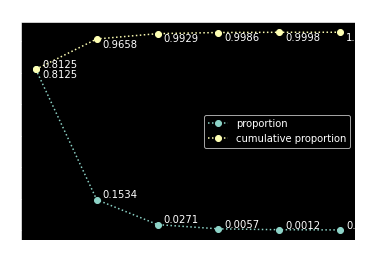

In [92]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False)
t=time()
tdm = vec.fit_transform(text_vector)
print('HashingVectorizer elapsed time:',time()-t)
display(tdm)
print('Sparsity                                    : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1]) * 100))
print('Max count of a hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document       : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document      : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document           : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                  :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence             :', size(tdm.shape[0]*tdm.shape[1]*np.uint8().itemsize))
print('Non-zero probabilities:',end='')
nz_bin_count = [[bin, (tdm == bin).sum(), (tdm == bin).sum()/tdm.nnz] for bin in range(1, int(tdm.max()) + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))

bin, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.plot(bin, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bin[i]+.1, count[i], '{:.4f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bin, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bin[i]+.1, cumcount[i], '{:.4f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

The maximum frequency of any hashed 1-gram token in a single observation is also 6. The 8-bits unsigned integer `uint8` (0 to 255) should be enough to store counts of any ngram range as long as there are sufficient `n_features`.

The hashed data, actually the non-zero values of the sparse matrix:

In [93]:
hashed_df = pd.DataFrame(tdm.data, columns=['hash_value'])
hashed_df

,hash_value
0,1.0
1,2.0
2,1.0
3,1.0
4,1.0
...,...
6290667,1.0
6290668,1.0
6290669,1.0
6290670,1.0


Evaluating the hashing collisions

In [94]:
hash_collisions = hashed_df.groupby('hash_value').size()
hash_collisions = pd.DataFrame({'collisions': hash_collisions, 'percent': (hash_collisions / hashed_df.shape[0])})
hash_collisions.sort_values('percent', ascending=False)

,collisions,percent
hash_value,,
1.0,5111160,0.812498
2.0,964685,0.153352
3.0,170352,0.027080
4.0,35572,0.005655
5.0,7678,0.001221
6.0,1225,0.000195


## Tokenizing hashed n-gram ranges

Iterating over `n_features` from the default $2^{20}$ to the maximum $2^{30}$ ([Murmurhash3 32-bit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)) and n-gram range from 1 to 3 in order to understand hashing collisions and memory usage.

In [95]:
# tracemalloc.start()
# msg = 'features:2^{}={} ngram:{},{} cols:{} maxtf:{:.0f} maxtfall:{:.0f} hashcount:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in range(1, 31): # from 1 to 2^30 (Mumuhash3 32-bit)
#     for ngram_range in [(1,x) for x in range(1, 4)]:
#         t=time()
#         vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, 
#                                 ngram_range=ngram_range, n_features=2**i, dtype='uint8')
#         tdm = vec.fit_transform(text_vector)
#         t=time()-t
#         current, peak = tracemalloc.get_traced_memory()
#         #tracemalloc.reset_peak()
#         _, hash_counts = np.unique(tdm.data, return_counts=True)
#         tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#         print(msg.format(i, 2**i, ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), tdm.sum(axis=0).max(),
#                          len(hash_counts),
#                          tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100,
#                          size(tdm_nbytes), size(current), size(peak), t))
#         #print(list(hash_counts/hash_counts.sum()),'\n')
# tracemalloc.stop()

**Saved results:**  
```
Last executed at 2022-07-23 02:48:24 in 30m 40.91s
features:2^1=2 ngram:1,1 cols:2 maxtf:36 maxtfall:4187508 hashcount:35 nnz:794417 sparse:0.77% size:5.3 MiB cur:5.3 MiB peak:13.3 MiB 9s
features:2^1=2 ngram:1,2 cols:2 maxtf:58 maxtfall:7827178 hashcount:58 nnz:796765 sparse:0.47% size:5.3 MiB cur:5.3 MiB peak:29.3 MiB 21s
features:2^1=2 ngram:1,3 cols:2 maxtf:87 maxtfall:11209240 hashcount:85 nnz:796765 sparse:0.47% size:5.3 MiB cur:5.3 MiB peak:53.3 MiB 30s
features:2^2=4 ngram:1,1 cols:4 maxtf:26 maxtfall:2453094 hashcount:26 nnz:1549832 sparse:3.20% size:8.9 MiB cur:8.9 MiB peak:53.3 MiB 10s
features:2^2=4 ngram:1,2 cols:4 maxtf:35 maxtfall:4190569 hashcount:35 nnz:1587887 sparse:0.83% size:9.1 MiB cur:9.1 MiB peak:53.3 MiB 21s
features:2^2=4 ngram:1,3 cols:4 maxtf:54 maxtfall:5784679 hashcount:54 nnz:1592212 sparse:0.56% size:9.1 MiB cur:9.1 MiB peak:57.1 MiB 30s
features:2^3=8 ngram:1,1 cols:8 maxtf:18 maxtfall:1325263 hashcount:17 nnz:2702208 sparse:15.61% size:14.4 MiB cur:14.4 MiB peak:57.1 MiB 10s
features:2^3=8 ngram:1,2 cols:8 maxtf:24 maxtfall:2217285 hashcount:24 nnz:3096045 sparse:3.32% size:16.3 MiB cur:16.3 MiB peak:57.1 MiB 21s
features:2^3=8 ngram:1,3 cols:8 maxtf:33 maxtfall:3018322 hashcount:33 nnz:3154089 sparse:1.50% size:16.6 MiB cur:16.6 MiB peak:64.9 MiB 30s
features:2^4=16 ngram:1,1 cols:16 maxtf:15 maxtfall:1034314 hashcount:14 nnz:3921702 sparse:38.77% size:20.2 MiB cur:5.3 MiB peak:64.9 MiB 10s
features:2^4=16 ngram:1,2 cols:16 maxtf:19 maxtfall:1496823 hashcount:19 nnz:5335050 sparse:16.70% size:27.0 MiB cur:27.0 MiB peak:64.9 MiB 21s
features:2^4=16 ngram:1,3 cols:16 maxtf:23 maxtfall:1890535 hashcount:23 nnz:5829836 sparse:8.97% size:29.3 MiB cur:29.3 MiB peak:88.3 MiB 30s
features:2^5=32 ngram:1,1 cols:32 maxtf:11 maxtfall:633333 hashcount:11 nnz:5022569 sparse:60.79% size:25.5 MiB cur:9.5 MiB peak:88.3 MiB 10s
features:2^5=32 ngram:1,2 cols:32 maxtf:14 maxtfall:858706 hashcount:14 nnz:7929966 sparse:38.09% size:39.3 MiB cur:9.1 MiB peak:88.3 MiB 21s
features:2^5=32 ngram:1,3 cols:32 maxtf:17 maxtfall:1113927 hashcount:17 nnz:9553383 sparse:25.42% size:47.1 MiB cur:47.1 MiB peak:88.3 MiB 30s
features:2^6=64 ngram:1,1 cols:64 maxtf:8 maxtfall:418134 hashcount:8 nnz:5619666 sparse:78.06% size:28.3 MiB cur:9.5 MiB peak:123.0 MiB 10s
features:2^6=64 ngram:1,2 cols:64 maxtf:12 maxtfall:502469 hashcount:12 nnz:10123894 sparse:60.48% size:49.8 MiB cur:17.5 MiB peak:123.0 MiB 21s
features:2^6=64 ngram:1,3 cols:64 maxtf:13 maxtfall:641202 hashcount:13 nnz:13405271 sparse:47.67% size:65.4 MiB cur:14.3 MiB peak:123.0 MiB 30s
features:2^7=128 ngram:1,1 cols:128 maxtf:8 maxtfall:358296 hashcount:8 nnz:5955794 sparse:88.38% size:29.9 MiB cur:9.5 MiB peak:123.0 MiB 10s
features:2^7=128 ngram:1,2 cols:128 maxtf:11 maxtfall:406431 hashcount:11 nnz:11450345 sparse:77.65% size:56.1 MiB cur:17.5 MiB peak:123.0 MiB 21s
features:2^7=128 ngram:1,3 cols:128 maxtf:11 maxtfall:533865 hashcount:11 nnz:16092500 sparse:68.59% size:78.3 MiB cur:16.9 MiB peak:123.0 MiB 30s
features:2^8=256 ngram:1,1 cols:256 maxtf:7 maxtfall:352774 hashcount:7 nnz:6142401 sparse:94.01% size:30.8 MiB cur:9.5 MiB peak:142.7 MiB 10s
features:2^8=256 ngram:1,2 cols:256 maxtf:10 maxtfall:358975 hashcount:10 nnz:12368980 sparse:87.93% size:60.5 MiB cur:17.5 MiB peak:142.7 MiB 21s
features:2^8=256 ngram:1,3 cols:256 maxtf:10 maxtfall:450143 hashcount:10 nnz:17932462 sparse:82.50% size:87.0 MiB cur:33.5 MiB peak:142.7 MiB 30s
features:2^9=512 ngram:1,1 cols:512 maxtf:6 maxtfall:339288 hashcount:6 nnz:6222740 sparse:96.96% size:31.2 MiB cur:9.5 MiB peak:173.4 MiB 10s
features:2^9=512 ngram:1,2 cols:512 maxtf:9 maxtfall:342549 hashcount:9 nnz:12712194 sparse:93.80% size:62.1 MiB cur:17.5 MiB peak:173.4 MiB 21s
features:2^9=512 ngram:1,3 cols:512 maxtf:9 maxtfall:350521 hashcount:9 nnz:18849729 sparse:90.80% size:91.4 MiB cur:33.5 MiB peak:173.4 MiB 30s
features:2^10=1024 ngram:1,1 cols:1024 maxtf:6 maxtfall:331003 hashcount:6 nnz:6248202 sparse:98.48% size:31.3 MiB cur:9.5 MiB peak:180.4 MiB 10s
features:2^10=1024 ngram:1,2 cols:1024 maxtf:8 maxtfall:332813 hashcount:8 nnz:12931733 sparse:96.85% size:63.2 MiB cur:17.5 MiB peak:180.4 MiB 21s
features:2^10=1024 ngram:1,3 cols:1024 maxtf:8 maxtfall:336036 hashcount:8 nnz:19316187 sparse:95.29% size:93.6 MiB cur:33.5 MiB peak:180.4 MiB 30s
features:2^11=2048 ngram:1,1 cols:2048 maxtf:6 maxtfall:331001 hashcount:6 nnz:6275510 sparse:99.23% size:31.5 MiB cur:9.5 MiB peak:184.0 MiB 10s
features:2^11=2048 ngram:1,2 cols:2048 maxtf:8 maxtfall:331441 hashcount:8 nnz:13040209 sparse:98.41% size:63.7 MiB cur:17.5 MiB peak:184.0 MiB 21s
features:2^11=2048 ngram:1,3 cols:2048 maxtf:8 maxtfall:332508 hashcount:8 nnz:19629629 sparse:97.61% size:95.1 MiB cur:33.5 MiB peak:184.0 MiB 30s
features:2^12=4096 ngram:1,1 cols:4096 maxtf:6 maxtfall:331001 hashcount:6 nnz:6285658 sparse:99.62% size:31.5 MiB cur:9.5 MiB peak:186.4 MiB 10s
features:2^12=4096 ngram:1,2 cols:4096 maxtf:6 maxtfall:331102 hashcount:6 nnz:13127198 sparse:99.20% size:64.1 MiB cur:17.5 MiB peak:186.4 MiB 21s
features:2^12=4096 ngram:1,3 cols:4096 maxtf:6 maxtfall:331628 hashcount:6 nnz:19788689 sparse:98.79% size:95.9 MiB cur:33.5 MiB peak:186.4 MiB 30s
features:2^13=8192 ngram:1,1 cols:8192 maxtf:6 maxtfall:331001 hashcount:6 nnz:6287429 sparse:99.81% size:31.5 MiB cur:9.5 MiB peak:187.6 MiB 10s
features:2^13=8192 ngram:1,2 cols:8192 maxtf:6 maxtfall:331025 hashcount:6 nnz:13154435 sparse:99.60% size:64.3 MiB cur:17.5 MiB peak:187.6 MiB 21s
features:2^13=8192 ngram:1,3 cols:8192 maxtf:6 maxtfall:331294 hashcount:6 nnz:19845205 sparse:99.39% size:96.2 MiB cur:33.5 MiB peak:187.6 MiB 30s
features:2^14=16384 ngram:1,1 cols:16384 maxtf:6 maxtfall:331001 hashcount:6 nnz:6288381 sparse:99.90% size:31.5 MiB cur:9.5 MiB peak:188.1 MiB 10s
features:2^14=16384 ngram:1,2 cols:16384 maxtf:6 maxtfall:331019 hashcount:6 nnz:13160199 sparse:99.80% size:64.3 MiB cur:17.5 MiB peak:188.1 MiB 21s
features:2^14=16384 ngram:1,3 cols:16384 maxtf:6 maxtfall:331022 hashcount:6 nnz:19872390 sparse:99.70% size:96.3 MiB cur:33.5 MiB peak:188.1 MiB 30s
features:2^15=32768 ngram:1,1 cols:32768 maxtf:6 maxtfall:331001 hashcount:6 nnz:6288404 sparse:99.95% size:31.5 MiB cur:9.5 MiB peak:188.3 MiB 10s
features:2^15=32768 ngram:1,2 cols:32768 maxtf:6 maxtfall:331019 hashcount:6 nnz:13163068 sparse:99.90% size:64.3 MiB cur:17.5 MiB peak:188.3 MiB 21s
features:2^15=32768 ngram:1,3 cols:32768 maxtf:6 maxtfall:331019 hashcount:6 nnz:19878845 sparse:99.85% size:96.3 MiB cur:33.5 MiB peak:188.3 MiB 30s
features:2^16=65536 ngram:1,1 cols:65536 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290648 sparse:99.98% size:31.5 MiB cur:9.5 MiB peak:188.5 MiB 10s
features:2^16=65536 ngram:1,2 cols:65536 maxtf:6 maxtfall:331019 hashcount:6 nnz:13166487 sparse:99.95% size:64.3 MiB cur:17.5 MiB peak:188.5 MiB 21s
features:2^16=65536 ngram:1,3 cols:65536 maxtf:6 maxtfall:331019 hashcount:6 nnz:19885933 sparse:99.92% size:96.4 MiB cur:33.5 MiB peak:188.5 MiB 30s
features:2^17=131072 ngram:1,1 cols:131072 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290665 sparse:99.99% size:31.5 MiB cur:9.5 MiB peak:188.8 MiB 10s
features:2^17=131072 ngram:1,2 cols:131072 maxtf:6 maxtfall:331019 hashcount:6 nnz:13166891 sparse:99.97% size:64.3 MiB cur:17.5 MiB peak:188.8 MiB 21s
features:2^17=131072 ngram:1,3 cols:131072 maxtf:6 maxtfall:331019 hashcount:6 nnz:19886655 sparse:99.96% size:96.4 MiB cur:33.5 MiB peak:188.8 MiB 30s
features:2^18=262144 ngram:1,1 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290666 sparse:99.99% size:31.5 MiB cur:9.5 MiB peak:189.3 MiB 10s
features:2^18=262144 ngram:1,2 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:13166930 sparse:99.99% size:64.3 MiB cur:17.5 MiB peak:189.3 MiB 21s
features:2^18=262144 ngram:1,3 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:19887537 sparse:99.98% size:96.4 MiB cur:33.5 MiB peak:189.3 MiB 30s
features:2^19=524288 ngram:1,1 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290671 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:190.3 MiB 10s
features:2^19=524288 ngram:1,2 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167710 sparse:99.99% size:64.3 MiB cur:17.5 MiB peak:190.3 MiB 21s
features:2^19=524288 ngram:1,3 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888512 sparse:99.99% size:96.4 MiB cur:33.5 MiB peak:190.3 MiB 30s
features:2^20=1048576 ngram:1,1 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:192.3 MiB 10s
features:2^20=1048576 ngram:1,2 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167719 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:192.3 MiB 21s
features:2^20=1048576 ngram:1,3 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888542 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:192.3 MiB 30s
features:2^21=2097152 ngram:1,1 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:196.3 MiB 10s
features:2^21=2097152 ngram:1,2 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167721 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:196.3 MiB 21s
features:2^21=2097152 ngram:1,3 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888922 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:196.3 MiB 30s
features:2^22=4194304 ngram:1,1 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:204.3 MiB 10s
features:2^22=4194304 ngram:1,2 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:204.3 MiB 21s
features:2^22=4194304 ngram:1,3 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888965 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:204.3 MiB 30s
features:2^23=8388608 ngram:1,1 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:220.3 MiB 10s
features:2^23=8388608 ngram:1,2 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:220.3 MiB 21s
features:2^23=8388608 ngram:1,3 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888965 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:220.3 MiB 30s
features:2^24=16777216 ngram:1,1 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:252.3 MiB 10s
features:2^24=16777216 ngram:1,2 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:265.5 MiB 21s
features:2^24=16777216 ngram:1,3 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:273.5 MiB 30s
features:2^25=33554432 ngram:1,1 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:316.3 MiB 10s
features:2^25=33554432 ngram:1,2 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:521.5 MiB 21s
features:2^25=33554432 ngram:1,3 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:529.5 MiB 30s
features:2^26=67108864 ngram:1,1 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:545.5 MiB 10s
features:2^26=67108864 ngram:1,2 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:1.0 GiB 21s
features:2^26=67108864 ngram:1,3 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:1.0 GiB 30s
features:2^27=134217728 ngram:1,1 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:1.0 GiB 10s
features:2^27=134217728 ngram:1,2 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:2.0 GiB 21s
features:2^27=134217728 ngram:1,3 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:2.0 GiB 30s
features:2^28=268435456 ngram:1,1 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:2.0 GiB 10s
features:2^28=268435456 ngram:1,2 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:4.0 GiB 21s
features:2^28=268435456 ngram:1,3 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:4.0 GiB 30s
features:2^29=536870912 ngram:1,1 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:4.0 GiB 10s
features:2^29=536870912 ngram:1,2 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:8.0 GiB 21s
features:2^29=536870912 ngram:1,3 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888966 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:8.0 GiB 30s
features:2^30=1073741824 ngram:1,1 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:6290672 sparse:100.00% size:31.5 MiB cur:9.5 MiB peak:8.0 GiB 10s
features:2^30=1073741824 ngram:1,2 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:13167763 sparse:100.00% size:64.3 MiB cur:17.5 MiB peak:16.0 GiB 21s
features:2^30=1073741824 ngram:1,3 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:19888976 sparse:100.00% size:96.4 MiB cur:33.5 MiB peak:16.0 GiB 30s
```

As stated in [HashVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html):
> there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

The previous experiment shows that:
* For any n-gram from 1 to 3, the max feature count in any cell as well as the hash count stabilizes from `n_features=2**12` on: `6`
* For any n-gram from 1 to 3, the max feature count in a column stabilizes from `n_features=2**18` on: `331001`.  If considering only `1-gram`, it stablizes from `2**11` on.
* The max hash value of 6 allows to downcast the hash `dtype` from the default `float64` to `uint8` (0 to 255).
* __The number of non-zero elements (NNZ) for ngram (1,1) is the same of `CountVectorizer` for `n_features=2**20`.__
* __The number of non-zero elements (NNZ) for ngram (1,2) is the same of `CountVectorizer` for `n_features=2**22`.__
* __The number of non-zero elements (NNZ) for ngram (1,3) is the same of `CountVectorizer` for `n_features=2**30`. However `2**24` achieve a stable nnz very close to `2**30`__

__In order to preserve the same number of non-zero elements as the  1-gram's `CountVectorizer`, a final hashing could be the default `HashingVectorizer` (`n_features=2**20`) except that the `dtype` paremeter was tuned to `'uint8'` to reduce the memory usage. However as `PolynomialFeatures` currently only outputs float types, by default `float64`, the best possible downcasting is to set `HashingVectorizer(dtype='float32')`__

In [96]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, dtype='uint8')
t=time()
tdm = vec.fit_transform(text_vector)
print('HashingVectorizer elapsed time:',time()-t)
display(tdm)
print('Sparsity                                            : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max count of a unigram hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*np.uint8().itemsize))

HashingVectorizer elapsed time: 2.4580190181732178


<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                            : 0.9999850122482198
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 49
Mean unique hashed tokens per document              : 19.3
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 31.5 MiB
Dense matrix memory equivalence                     : 390.9 GiB


## Dimension reduction

In [97]:
from sklearn.feature_selection import chi2, SelectKBest

`feature_selection.chi2(X, y)`: Compute chi-squared stats between each non-negative feature and class.

Among other memory allocations, `SelectKBest(chi2, k).fit_transform()` method needs to allocate an array with shape defined by the `n_features` of the previous step `HashingVectorizer` times the number of target labels `104` times the size of the data type `int32`:

$$n\_features \times 104 \times 4$$

Estimate memory allocation, just for that array, in scenarios from $2^{1}$ to $2^{30}$ `n_features`:

In [98]:
{'2**{} ({} features)'.format(str(e),str(2**e)) : size(2**e * 104 * np.int32().itemsize) for e in range(11,31)}

{'2**11 (2048 features)': '832.0 KiB',
 '2**12 (4096 features)': '1.6 MiB',
 '2**13 (8192 features)': '3.2 MiB',
 '2**14 (16384 features)': '6.5 MiB',
 '2**15 (32768 features)': '13.0 MiB',
 '2**16 (65536 features)': '26.0 MiB',
 '2**17 (131072 features)': '52.0 MiB',
 '2**18 (262144 features)': '104.0 MiB',
 '2**19 (524288 features)': '208.0 MiB',
 '2**20 (1048576 features)': '416.0 MiB',
 '2**21 (2097152 features)': '832.0 MiB',
 '2**22 (4194304 features)': '1.6 GiB',
 '2**23 (8388608 features)': '3.2 GiB',
 '2**24 (16777216 features)': '6.5 GiB',
 '2**25 (33554432 features)': '13.0 GiB',
 '2**26 (67108864 features)': '26.0 GiB',
 '2**27 (134217728 features)': '52.0 GiB',
 '2**28 (268435456 features)': '104.0 GiB',
 '2**29 (536870912 features)': '208.0 GiB',
 '2**30 (1073741824 features)': '416.0 GiB'}

The next simulation takes a `text_vector` extracted from the whole dataset and performs `HashingVectorizer` and `SelectKBest` under different parameters to understand memory usage behavior under the limits of the current system: 64GB.

In [99]:
k_space = np.array([3800,   # 2^20 features and ngram [1,1]
                    32100,  # 2^20 features and ngram [1,2]
                    87500]) # 2^20 features and ngram [1,3]
k_space

array([ 3800, 32100, 87500])

In [100]:
# tracemalloc.start()
# threshold = psutil.virtual_memory().available
# print('Available virtual memory: ', size(threshold))
# msg = '2^{} ngram:{},{} cols:{} maxtf:{} hashcnt:{} nnz:{} sparse:{:.4f}% size:{} k:{} maxtf:{} hashcnt:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in np.arange(20, 21):
#     for ngram_range in [(1,1), (1,2), (1,3)]:
#         vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False,
#                                 ngram_range=ngram_range, n_features=2**i, dtype='uint8')
#         tdm = vec.fit_transform(text_vector)
#         _, hash_counts = np.unique(tdm.data, return_counts=True)
#         tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#         for k in k_space:
#             if k > 2**i: # avoid selecting more k features than in n_features
#                 continue
#             t=time()
#             red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
#             t=time()-t
#             current, peak = tracemalloc.get_traced_memory()
#             #tracemalloc.reset_peak()
#             red_nbytes = (red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)
#             _, hash_counts2 = np.unique(red.data, return_counts=True)
#             print(msg.format(i,
#                              ngram_range[0],
#                              ngram_range[1],
#                              tdm.shape[1],
#                              tdm.max(),
#                              len(hash_counts),
#                              tdm.nnz,
#                              (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100,
#                              size(tdm_nbytes),
#                              k,
#                              red.max(),
#                              len(hash_counts2),
#                              red.nnz,
#                              (1 - red.nnz / (red.shape[0] * red.shape[1])) * 100,
#                              size(red_nbytes),
#                              size(current),
#                              size(peak),
#                              t))
#             if peak >= threshold:
#                 print('Threshold reached:', size(threshold))
#                 break
#         else:
#             continue  # only executed if the inner loop did NOT break
#         break  # only executed if the inner loop DID break
#     else:
#         continue  # likewise
#     break  # likewise
# tracemalloc.stop()

**Saved results:**
```
Last executed at 2022-07-25 17:03:37 in 2m 11.12s

Available virtual memory:  57.9 GiB
2^20 ngram:1,1 cols:1048576 maxtf:6 hashcnt:6 nnz:6290672 sparse:100.00% size:31.5 MiB k:3800 maxtf:6 hashcnt:6 nnz:6290672 sparse:99.59% size:31.5 MiB cur:41.1 MiB peak:1.8 GiB 7s
2^20 ngram:1,1 cols:1048576 maxtf:6 hashcnt:6 nnz:6290672 sparse:100.00% size:31.5 MiB k:32100 maxtf:6 hashcnt:6 nnz:6290672 sparse:99.95% size:31.5 MiB cur:41.1 MiB peak:1.8 GiB 7s
2^20 ngram:1,1 cols:1048576 maxtf:6 hashcnt:6 nnz:6290672 sparse:100.00% size:31.5 MiB k:87500 maxtf:6 hashcnt:6 nnz:6290672 sparse:99.98% size:31.5 MiB cur:41.1 MiB peak:1.8 GiB 7s
2^20 ngram:1,2 cols:1048576 maxtf:6 hashcnt:6 nnz:13167719 sparse:100.00% size:64.3 MiB k:3800 maxtf:6 hashcnt:6 nnz:12178055 sparse:99.20% size:59.6 MiB cur:77.2 MiB peak:1.9 GiB 8s
2^20 ngram:1,2 cols:1048576 maxtf:6 hashcnt:6 nnz:13167719 sparse:100.00% size:64.3 MiB k:32100 maxtf:6 hashcnt:6 nnz:13167719 sparse:99.90% size:64.3 MiB cur:81.9 MiB peak:1.9 GiB 8s
2^20 ngram:1,2 cols:1048576 maxtf:6 hashcnt:6 nnz:13167719 sparse:100.00% size:64.3 MiB k:87500 maxtf:6 hashcnt:6 nnz:13167719 sparse:99.96% size:64.3 MiB cur:81.9 MiB peak:1.9 GiB 8s
2^20 ngram:1,3 cols:1048576 maxtf:6 hashcnt:6 nnz:19888542 sparse:100.00% size:96.4 MiB k:3800 maxtf:6 hashcnt:6 nnz:15868872 sparse:98.96% size:77.2 MiB cur:110.8 MiB peak:2.0 GiB 8s
2^20 ngram:1,3 cols:1048576 maxtf:6 hashcnt:6 nnz:19888542 sparse:100.00% size:96.4 MiB k:32100 maxtf:6 hashcnt:6 nnz:19566848 sparse:99.85% size:94.8 MiB cur:128.4 MiB peak:2.0 GiB 8s
2^20 ngram:1,3 cols:1048576 maxtf:6 hashcnt:6 nnz:19888542 sparse:100.00% size:96.4 MiB k:87500 maxtf:6 hashcnt:6 nnz:19888542 sparse:99.94% size:96.4 MiB cur:129.9 MiB peak:2.0 GiB 8s

``` 

Results show `n_features` is the cause of high memory usage, therefore, `n_features` must not be greater than $2^{24}$.

**Final proposal**

In [101]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, n_features=2**20, dtype='uint8')
tdm = vec.fit_transform(text_vector)
t=time()
red = SelectKBest(chi2, k=3800).fit_transform(tdm, dummy_labels)
print('SelectKBest elapsed time:',time()-t)
display(red)
print('Sparsity                                            : {:.3f}%'.format((1 - red.nnz / (red.shape[0]*red.shape[1])) * 100))
print('Max count of a unigram hashed token in a document   : {}'.format(red.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(red.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(red.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(red.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(red.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(red.shape[0]*red.shape[1]*np.uint8().itemsize))

SelectKBest elapsed time: 7.400114297866821


<400277x3800 sparse matrix of type '<class 'numpy.uint8'>'
	with 6290672 stored elements in Compressed Sparse Row format>

Sparsity                                            : 99.586%
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 49
Mean unique hashed tokens per document              : 19.3
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 31.5 MiB
Dense matrix memory equivalence                     : 1.4 GiB


**Cross-validation and multiprocessing considerations:**

Considering these results and as intended to perform a multi-processed k-fold cross-validation over the complete pipeline, the number of processors times the memory `n_features` must be tunned to fit within the 58GiB or less, otherwise it would be necessary to tune `n_features` and `k`.

Althought `k` hasn't very affected memory usage in the current step (`SelectKBest`) it surely will in the step (`PolynomialFeatures`).

## Feature union

In [102]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total'})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
union = FeatureUnion([
    ('numeric_features', Pipeline([
        ('numeric_selector', get_numeric_data),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    ])),
    ('text_features', Pipeline([
        ('text_selector', get_text_data),
        ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='uint8')),
        ('reduction', SelectKBest(chi2))
    ]))
])

In [103]:
# tracemalloc.start()
# threshold = psutil.virtual_memory().available
# msg = '2^{}={} ngram:{},{} k:{} cols:{} hashcount:{} maxtf:{:.0f} maxtfall:{:.0f} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
# for i in np.arange(20,21):
#     for ngram_range in [(1,1), (1,2), (1,3)]:
#         for k in k_space:
#             if k > 2**i:  # avoid selecting more k features than in n_features
#                 continue
#             union.set_params(text_features__vectorizer__ngram_range = ngram_range,
#                              text_features__vectorizer__n_features = 2**i,
#                              text_features__reduction__k = k)
#             t=time()
#             tdm = union.fit_transform(df[FEATURES], dummy_labels)
#             t=time()-t
#             current, peak = tracemalloc.get_traced_memory()
#             #tracemalloc.reset_peak()
#             _, hash_counts = np.unique(tdm.data, return_counts=True)
#             tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#             print(msg.format(i, 2**i, ngram_range[0], ngram_range[1], k,  tdm.shape[1],
#                              len(hash_counts), tdm.max(), tdm.sum(axis=0).max(), tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes),
#                              size(current), size(peak), t))
#             if peak >= threshold:
#                 print('Reached threshold:', size(threshold))
#                 break
#         else:
#             continue  # only executed if the inner loop did NOT break
#         break  # only executed if the inner loop DID break
#     else:
#         continue  # likewise
#     break  # likewise
# tracemalloc.stop()

**Saved results:**  
```
Last executed at 2022-07-25 17:15:59 in 6m 57.69s

2^20=1048576 ngram:1,1 k:3800 cols:3805 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:7059842 sparse:99.54% size:55.4 MiB cur:71.5 MiB peak:1.8 GiB 31s
2^20=1048576 ngram:1,1 k:32100 cols:32105 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:7059842 sparse:99.95% size:55.4 MiB cur:74.9 MiB peak:1.9 GiB 30s
2^20=1048576 ngram:1,1 k:87500 cols:87505 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:7059842 sparse:99.98% size:55.4 MiB cur:74.9 MiB peak:1.9 GiB 31s
2^20=1048576 ngram:1,2 k:3800 cols:3805 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:12947225 sparse:99.15% size:100.3 MiB cur:119.8 MiB peak:2.0 GiB 47s
2^20=1048576 ngram:1,2 k:32100 cols:32105 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:13936889 sparse:99.89% size:107.9 MiB cur:127.4 MiB peak:2.0 GiB 47s
2^20=1048576 ngram:1,2 k:87500 cols:87505 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:13936889 sparse:99.96% size:107.9 MiB cur:127.4 MiB peak:2.0 GiB 47s
2^20=1048576 ngram:1,3 k:3800 cols:3805 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:16638042 sparse:98.91% size:128.5 MiB cur:148.0 MiB peak:2.1 GiB 60s
2^20=1048576 ngram:1,3 k:32100 cols:32105 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:20336018 sparse:99.84% size:156.7 MiB cur:176.2 MiB peak:2.1 GiB 60s
2^20=1048576 ngram:1,3 k:87500 cols:87505 hashcount:298080 maxtf:129700000 maxtfall:2964718592 nnz:20657712 sparse:99.94% size:159.1 MiB cur:178.6 MiB peak:2.2 GiB 61s
```

`FeatureUnion` haven't increased memory usage significantly more than the previous step `SelectKBest`.

`n_features=2**20` is still the goal and `k` must be assessed in the step `PolynomialFeatures`.

## Adding interaction terms

In [104]:
from sklearn.preprocessing import PolynomialFeatures

* Interaction terms are statistical tools that lets your model express what happens if two features appear together in the same row.
* `degree` tells what polynomial degree of interactions to compute.
* Pipelines with interaction terms take a while to train because the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree. High degrees can cause overfitting.

Trying different number of features: $\beta_1x_1 + \beta_2x_2 + \beta_3(x_1x_2)$

When `interaction_only = True` only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.):

$$interactions = \frac{features \times (features + 1)}{2}$$.

In [105]:
dense_array = np.array([[0,0,1,0],[0,1,0,1],[1,0,1,0],[1,1,0,1]])
print(f'{dense_array.shape[0]}x{dense_array.shape[1]} matrix:\n', dense_array)
interacted_array = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(dense_array)
print(f'{interacted_array.shape[0]}x{interacted_array.shape[1]} interactions:\n', interacted_array)

4x4 matrix:
 [[0 0 1 0]
 [0 1 0 1]
 [1 0 1 0]
 [1 1 0 1]]
4x10 interactions:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 1. 0. 1. 0.]]


In [106]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(dense_array, dtype='float32')
print(repr(sparse_matrix), '\n', sparse_matrix)

interactor = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interactor.fit(sparse_matrix)
interactions = interactor.transform(sparse_matrix)
print('Feature names:', interactor.get_feature_names_out(), '\n',
      repr(interactions), '\n', interactions)

<4x4 sparse matrix of type '<class 'numpy.float32'>'
	with 8 stored elements in Compressed Sparse Row format> 
   (0, 2)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
  (2, 0)	1.0
  (2, 2)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 3)	1.0
Feature names: ['x0' 'x1' 'x2' 'x3' 'x0 x1' 'x0 x2' 'x0 x3' 'x1 x2' 'x1 x3' 'x2 x3'] 
 <4x10 sparse matrix of type '<class 'numpy.float32'>'
	with 13 stored elements in Compressed Sparse Row format> 
   (0, 2)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
  (1, 8)	1.0
  (2, 0)	1.0
  (2, 2)	1.0
  (2, 5)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 3)	1.0
  (3, 4)	1.0
  (3, 6)	1.0
  (3, 8)	1.0


Estimating interactions on a feature space:

In [107]:
['{} features result {:.0f} interactions'.format(x, x*(x+1)/2) for x in k_space]

['3800 features result 7221900 interactions',
 '32100 features result 515221050 interactions',
 '87500 features result 3828168750 interactions']

Plotting interactions as a function of the number of features.  The red lines show the maximum of number of features whose interactions are smaller than the dataset observations, by the formula:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

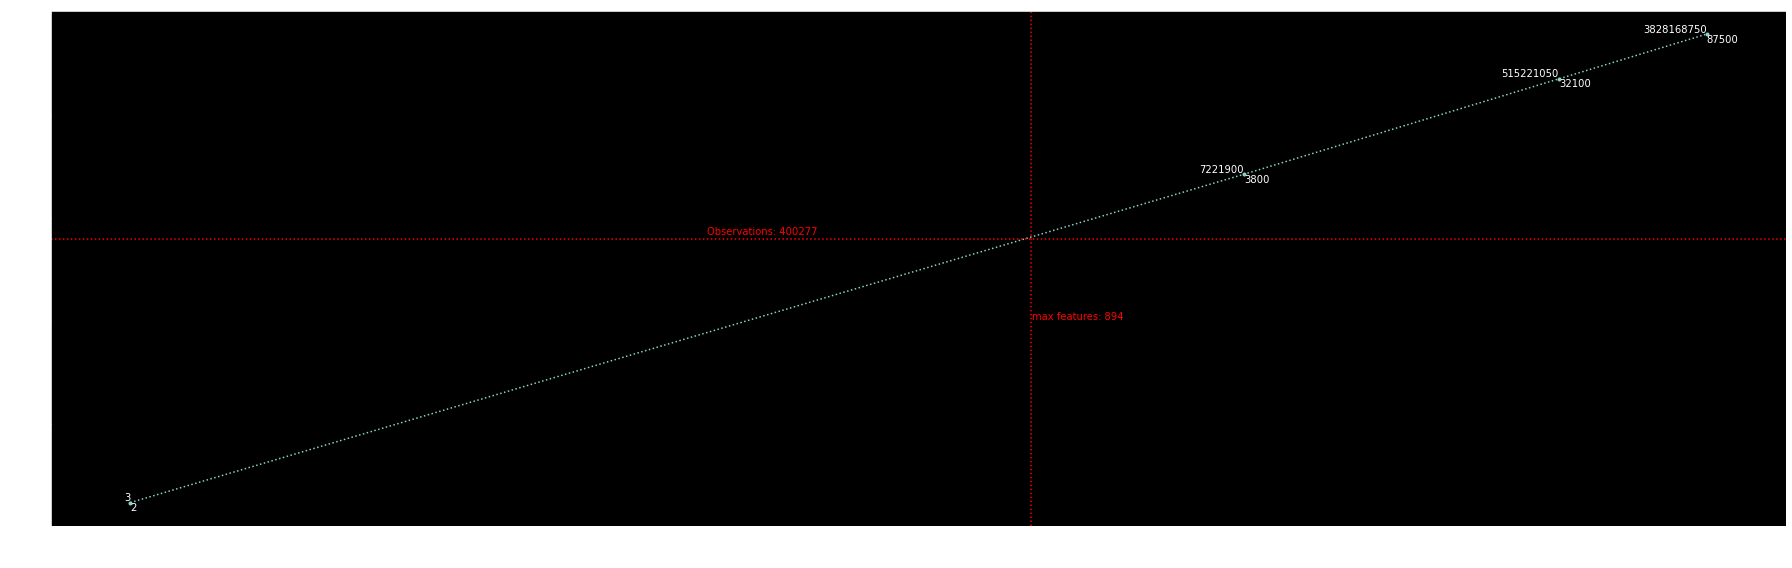

In [108]:
#feature_space = np.logspace(np.log10(2), np.log10(3800), 11)
feature_space = np.array([2, 3800, 32100, 87500])
interactions = (feature_space * (feature_space + 1) / 2).astype('int64')
max_features = int((np.sqrt(8 * df.shape[0] + 1) - 1) / 2)

plt.figure(figsize=(25,8))
plt.loglog(feature_space, interactions, marker='.', linestyle='dotted')
plt.axhline(df.shape[0] , linestyle='dotted', color='red')
plt.text(x=100, y=df.shape[0]*1.1, s='Observations: {}'.format(df.shape[0]), verticalalignment='bottom', color='red')

plt.axvline(max_features , linestyle='dotted', color='red')
plt.text(x=max_features*1.01, y=10**4, s='max features: {}'.format(max_features), verticalalignment='bottom', color='red')
for i,j in zip(feature_space, interactions):
    plt.text(i,j,j, horizontalalignment='right', verticalalignment='bottom')
    plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')
plt.xlabel('feature space')
plt.ylabel('interactions')
plt.tight_layout()
plt.show()

## Interacting different hashed n-grams from all text features

The next simulation takes all numeric and text features from the whole dataset and performs `HashingVectorizer`, `SelectKBest` and `PolynomialFeatures` under different parameters to understand memory limitations.  

For each `ngram_range` a specific parameter space is assigned.  Each space is a log space starting from $2^{2.5}$ to the limit of the `CountVectorizer` resulting features for a given `ngram_range`

In [109]:
k_space

array([ 3800, 32100, 87500])

In [110]:
# ngram_k = [len(CountVectorizer(ngram_range=(1,n), dtype='uint8').fit(text_vector).vocabulary_) for n in range(1,4)]
# ngram_k

In [111]:
# ngram1_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_k[0])), 7).round().astype('int')
# ngram1_logspace = np.hstack((ngram1_logspace[ngram1_logspace < ngram_k[0]], ngram_k[0]))
# ngram2_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_k[1])), 11).round().astype('int')
# ngram2_logspace = np.hstack((ngram2_logspace[ngram2_logspace < ngram_k[1]], ngram_k[1]))
# ngram3_logspace = np.logspace(2.5, np.ceil(np.log10(ngram_k[2])), 11).round().astype('int')
# ngram3_logspace = np.hstack((ngram3_logspace[ngram3_logspace < ngram_k[2]], ngram_k[2]))
# logspaces = list((ngram1_logspace, ngram2_logspace, ngram3_logspace))
# logspaces

In [112]:
tracemalloc.start()
threshold = psutil.virtual_memory().available
print('Threshold/Free mem.: ', size(threshold))
msg = '2^{}={} ngram:{},{} k:{} union:{} nnz:{} sparse:{:.4f}% size:{} peak:{} {:.0f}s iact:{} nnz:{} sparse:{:.4f}% size:{} peak:{} {:.0f}s'

for i in np.arange(20, 21):
    for ngram_range in [(1,1), (1,2), (1,3)]:
        # for k in logspaces[ngram_range[1]-1]:
        for k in [k_space[ngram_range[1]-1]]:
            if k > 2**i:
                continue
            union.set_params(text_features__vectorizer__n_features = 2**i,
                             text_features__vectorizer__ngram_range = ngram_range,
                             text_features__reduction__k = k)
            t1=time()
            un = union.fit_transform(df[FEATURES], dummy_labels)
            t1=time()-t1
            current, un_peak = tracemalloc.get_traced_memory()
            un_nbytes = (un.data.nbytes + un.indptr.nbytes + un.indices.nbytes)

            t2=time()
            iact = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(un)
            t2=time()-t2
            current, peak = tracemalloc.get_traced_memory()
            # tracemalloc.reset_peak()
            current, iact_peak = tracemalloc.get_traced_memory()

            iact_nbytes = (iact.data.nbytes + iact.indptr.nbytes + iact.indices.nbytes)

            print(msg.format(i, 2**i, ngram_range[0], ngram_range[1],
                             k, un.shape[1], un.nnz, (1 - un.nnz / (un.shape[0] * un.shape[1])) * 100,
                             size(un_nbytes), size(un_peak), t1,
                             iact.shape[1], iact.nnz, (1-iact.nnz/(iact.shape[0] * iact.shape[1])) * 100,
                             size(iact_nbytes), size(iact_peak), t2))
            if iact_peak >= threshold:
                print('\tReached threshold: {}'.format(size(threshold)))
                break
        else:
            continue  # only executed if the inner loop did NOT break
        break  # only executed if the inner loop DID break
    else:
        continue  # likewise
    break  # likewise
tracemalloc.stop()

Threshold/Free mem.:  58.7 GiB
2^20=1048576 ngram:1,1 k:3800 union:3805 nnz:7059842 sparse:99.5365% size:55.4 MiB peak:1.8 GiB 30s iact:7240915 nnz:72479455 sparse:99.9975% size:554.5 MiB peak:1.8 GiB 0s
2^20=1048576 ngram:1,2 k:32100 union:32105 nnz:13936889 sparse:99.8915% size:107.9 MiB peak:2.5 GiB 47s iact:515381565 nnz:280886208 sparse:99.9999% size:2.1 GiB peak:6.8 GiB 2s
2^20=1048576 ngram:1,3 k:87500 union:87505 nnz:20657712 sparse:99.9410% size:159.1 MiB peak:6.8 GiB 60s iact:3828606265 nnz:619522148 sparse:100.0000% size:6.9 GiB peak:22.8 GiB 6s


**Saved results:**  
Initial memory peak:  744.2 MiB  
Threshold/Free mem.:  13.4 GiB  
^20=1048576 g11 k316u321 nz6109914:0.9524 48.1 MiB 2.6 GiB 42s i51681 nz56116616:0.9973 429.7 MiB 2.6 GiB 3s  
^20=1048576 g11 k562u567 nz6693933:0.9705 52.6 MiB 2.6 GiB 42s i161028 nz65954678:0.9990 504.7 MiB 2.8 GiB 4s  
^20=1048576 g11 k1000u1005 nz6939969:0.9827 54.5 MiB 2.8 GiB 41s i505515 nz70322636:0.9997 538.0 MiB 3.0 GiB 4s  
^20=1048576 g11 k1778u1783 nz7038491:0.9901 55.2 MiB 3.0 GiB 41s i1590436 nz72101374:0.9999 551.6 MiB 3.0 GiB 4s  
^20=1048576 g11 k3162u3167 nz7058681:0.9944 55.4 MiB 3.0 GiB 40s i5016528 nz72460105:1.0000 554.4 MiB 3.1 GiB 4s  
**^20=1048576 g11 k3728u3733 nz7059842:0.9953 55.4 MiB 3.1 GiB 41s i6969511 nz72479455:1.0000 554.5 MiB 3.1 GiB 5s**  
^20=1048576 g12 k316u321 nz6656526:0.9482 52.3 MiB 3.1 GiB 47s i51681 nz73212731:0.9965 560.1 MiB 3.1 GiB 4s  
^20=1048576 g12 k562u567 nz8862243:0.9610 69.1 MiB 3.1 GiB 47s i161028 nz127138113:0.9980 971.5 MiB 5.1 GiB 7s  
^20=1048576 g12 k1000u1005 nz10406048:0.9741 80.9 MiB 5.1 GiB 47s i505515 nz171108479:0.9992 1.3 GiB 6.7 GiB 11s  
^20=1048576 g12 k1778u1783 nz11811944:0.9834 91.6 MiB 6.7 GiB 52s i1590436 nz211619361:0.9997 1.6 GiB 8.2 GiB 14s  
^20=1048576 g12 k3162u3167 nz12753603:0.9899 98.8 MiB 8.2 GiB 50s i5016528 nz241119979:0.9999 1.8 GiB 9.3 GiB 17s  
^20=1048576 g12 k5623u5628 nz13322747:0.9941 103.2 MiB 9.3 GiB 50s i15840006 nz259901287:1.0000 1.9 GiB 10.0 GiB 20s  
^20=1048576 g12 k10000u10005 nz13718410:0.9966 106.2 MiB 10.0 GiB 52s i50055015 nz273400373:1.0000 2.0 GiB 10.5 GiB 23s  
^20=1048576 g12 k17783u17788 nz13883931:0.9981 107.5 MiB 10.5 GiB 50s i158215366 nz279082583:1.0000 2.1 GiB 10.8 GiB 34s  
^20=1048576 g12 k31623u31628 nz13936444:0.9989 107.9 MiB 10.8 GiB 52s i500181006 nz280871385:1.0000 2.1 GiB 10.8 GiB 67s  
**^20=1048576 g12 k32572u32577 nz13936889:0.9989 107.9 MiB 10.8 GiB 50s i530646753 nz280886208:1.0000 2.1 GiB 10.8 GiB 72s**  
^20=1048576 g13 k316u321 nz5925341:0.9539 46.7 MiB 10.8 GiB 57s i51681 nz63378767:0.9969 485.1 MiB 10.8 GiB 3s  
^20=1048576 g13 k562u567 nz8496521:0.9626 66.4 MiB 10.8 GiB 56s i161028 nz127797664:0.9980 976.5 MiB 10.8 GiB 7s  
^20=1048576 g13 k1000u1005 nz11550202:0.9713 89.6 MiB 10.8 GiB 56s i505515 nz229482412:0.9989 1.7 GiB 10.8 GiB 14s  
^20=1048576 g13 k1778u1783 nz13819732:0.9806 107.0 MiB 10.8 GiB 58s i1590436 nz318995602:0.9995 2.4 GiB 12.2 GiB 23s  
**^20=1048576 g13 k3162u3167 nz16010582:0.9874 123.7 MiB 12.2 GiB 57s i5016528 nz404813138:0.9998 3.0 GiB 13.4 GiB 751s**  
	Reached threshold: 13.4 GiB available: 13.8 GiB

**The memory threshold is reached when `ngram_range=(1,3)` and `k=3162`.**

In [ ]:
k = (np.logspace(2, 3.5, 13, dtype='int'))[:-1]
# [100,133,177,237,316,421,562,749,1000,1333,1778,2371]
i = (k * (k + 1) / 2).astype('int64')
p = [2.2, 2.4, 2.4, 2.4, 2.4, 2.6, 3.4, 4.5, 6.2, 8.1, 9.8, 11.3]
t = [1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.semilogx(k, i, 'o--')
plt.axvline(x=10**3, linestyle='dotted')
plt.xlabel('k-best')
plt.ylabel('interactions')

plt.subplot(1,3,2)
plt.semilogx(k, p, 'o--')
plt.xlabel('k-best')
plt.ylabel('memory peak (GB)')

plt.subplot(1,3,3)
plt.semilogx(k, t, 'o--')
plt.xlabel('k-best')
plt.ylabel('interaction time (seconds)')
plt.tight_layout()
plt.show()

## Feature scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), also known as data normalization, is a method used to normalize the range of independent variables or features of data.

See [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

One can use different **scalers, transformers, and normalizers** to bring the data within a pre-defined range.

Scalers are **linear transformers** (more precisely [affine transformers](https://en.wikipedia.org/wiki/Affine_transformation)) and differ from each other in the way to estimate the parameters used to shift and scale **each feature**:
* `StandardScaler` - standardizes features by removing the mean and scaling to unit variance
* `MinMaxScaler` - transforms features by scaling each feature to a given range, default (0, 1)
* `MaxAbsScaler` - scales each feature by its maximum absolute value to a range (-1, 1)
* `RobustScaler` - scales features using statistics that are robust to outliers

Transformers provides non-linear transformations:
* `QuantileTransformer` - transforms features using quantiles information, where distances between marginal outliers and inliers are shrunk.
* `PowerTransformer` - applies a power transform featurewise to make data more Gaussian-like, where data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a **per sample** transformation instead of a **per feature** transformation:
* `Normalizer` - normalizes samples individually to unit norm
> Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

Initial considerations:
* `StandardScaler`, `MinMaxScaler` is very sensitive to the presence of outliers.
* On positive only data, `MaxAbsScaler` behaves similarly to MinMaxScaler, suffering from the presence of large outliers.
* The centering and scaling statistics of the `RobustScaler` are based on percentiles and not influenced by a few number of very large marginal outliers. The resulting range of the transformed feature values is larger than for the previous scalers and are approximately similar.
* `PowerTransformer(method='Yeo-Johnson')` can be applied to both negative and positive data.
* `PowerTransformer(method='Box-Cox')` can only be applied to strictly positive data.
* `QuantileTransformer(output_distribution='gaussian')`: Note that this non-parametetric transformer introduces saturation artifacts for outliers.
* `QuantileTransformer(output_distribution='uniform')` as `RobustScaler`, are robust to outliers but they will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

Final considerations:

For this problem, we need to scale a sparse matrix without destroying any sparsity, i.e., non-stored zero values should continue being like that.  The scalers/settings supporting that are:
* `StandardScaler(with_mean=False)`
* `MaxAbsScaler`
* `RobustScaler(with_centering=False)`
* `Normalizer(norm='l2')`
* `Normalizer(norm='l1')`

From these, the only scaler not sensible to outliers is the `RobustScaler`

In [ ]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, Normalizer

In [ ]:
scalers = [('StandardScaler(with_mean=False)   ', StandardScaler(with_mean=False)),
           ('MaxAbsScaler()                    ', MaxAbsScaler()),
           ('Normalizer(norm=\'l2\')             ', Normalizer(norm='l2')),
           ('Normalizer(norm=\'l1\')             ', Normalizer(norm='l1'))#,
           # ('RobustScaler(with_centering=False)', RobustScaler(with_centering=False)) # takes much too long for k=1778
          ]
union.set_params(text_features__reduction__k = 1778)
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
tdm = union.fit_transform(df[FEATURES], dummy_labels)
print('Union elapsed:', time()-t)
print('Memory peak after union:', size(psutil.Process().memory_info().peak_wset))
t=time()
tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(tdm)
t=time()-t
peak_wset = psutil.Process().memory_info().peak_wset
sparsity = (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100
tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
display(tdm)
msg = 'nnz: {} sparsity: {:.2f}% min: {} max: {} nbytes: {} peak_wset: {} time: {:.0f}s'
print(msg.format(tdm.nnz, sparsity, tdm.min(), tdm.max(), size(tdm_nbytes), size(peak_wset), t))

**Saved results:**  
Initial memory peak: 339.0 MiB  
Union elapsed: 42.75408911705017  
Memory peak after union: 2.6 GiB  
<400277x1590436 sparse matrix of type '<class 'numpy.float32'>'  
	with 72101374 stored elements in Compressed Sparse Column format>  
nnz: 72101374 sparsity: 99.99% min: -262398912.0 max: 259400000.0 nbytes: 556.2 MiB peak_wset: 3.1 GiB time: 762s

In [ ]:
for name, scaler in scalers:
    t=time()
    tdm2 = scaler.fit_transform(tdm, dummy_labels)
    t=time()-t
    peak_wset = psutil.Process().memory_info().peak_wset
    msg = 'min: {:>20} max: {:>20} peak_wset: {} time: {:.0f}s'
    print(name, msg.format(tdm2.min(), tdm2.max(), size(peak_wset), t))

**Saved results:**  
StandardScaler(with_mean=False)    min:     -632.67529296875 max:    632.6753540039062 peak_wset: 3.1 GiB time: 8s  
MaxAbsScaler()                     min:                 -1.0 max:                  1.0 peak_wset: 3.1 GiB time: 1s  
Normalizer(norm='l2')              min:  -0.8111070990562439 max:   0.9954653382301331 peak_wset: 3.1 GiB time: 12s  
Normalizer(norm='l1')              min: -0.27777546644210815 max:   0.8239297270774841 peak_wset: 3.1 GiB time: 12s

## Pipeline: Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures
from preprocessing.combine_text_columns import combine_text_columns
from sklearn.metrics import classification_report
from metrics.log_loss import multi_multi_log_loss
from metrics.log_loss import log_loss_report
from dummies import get_dummies_indices
from model_selection.multilabel import multilabel_train_test_split, multilabel_sample_dataframe
from preprocessing.get_normalized_total import get_normalized_total
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': NUMERIC_FEATURES + LABELS})
get_numeric_data = FunctionTransformer(get_normalized_total, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total'})
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        ], verbose=True)),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='uint8')),
            ('reducer', SelectKBest(chi2))
        ], verbose=True))
    ])), # may want n_jobs=-1 in FeatureUnion()
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
], verbose=True)

### 0.008 train

In [ ]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.01, min_count=7, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=1, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

In [ ]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1000)  # found in 1% learning curve
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.008-k1000-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

**Saved results for k=1000, C=1:  
Training logloss   : 0.0563  
Testing logloss   : 0.3097  
DrivenData logloss : 0.5983**  
Initial memory peak: 1.1 GiB  
Fitting started on 2020-06-30T17:08  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.1s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.2s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  17.9s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  18.1s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.1s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s  
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  53.4s  
Done: 1.2 minutes  
Saving cache 0.008-k1000-logistic-regression-C1 ... Done: 0.0 minutes  
Final memory peak: 2.5 GiB

In [ ]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

### 0.08 train

In [ ]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.1, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

In [ ]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778)  # found in 10% learning curve
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.08-k1778-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

**Saved results for k=1778,C=1: DrivenData logloss 0.5232**  
Initial memory peak: 2.3 GiB  
Fitting started on 2020-02-07T22:10  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.9s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.7s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  18.7s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  20.4s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.6s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.9s  
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 8.8min  
Done: 9.2 minutes  
Saving cache 0.08-k1778-logistic-regression-C1 ... Done: 0.0 minutes  
Final memory peak: 2.8 GiB

In [ ]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

### 0.16 train

In [ ]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.2, min_count=2, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'),
                                size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

In [ ]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778) # found in 20% learning curve
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.16-k1778-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

**Saved results for k=1778,C=1:  
Training log loss  : 0.0400  
Testing log loss   : 0.0892  
DrivenData logloss : 0.5083**  
Initial memory peak: 3.0 GiB  
Fitting started on 2020-06-30T17:51  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.9s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.4s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  19.3s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  21.7s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.8s  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.5s  
[Pipeline] ........ (step 4 of 4) Processing classifier, total=17.3min  
Done: 17.7 minutes  
Saving cache 0.16-k1778-logistic-regression-C1 ... Done: 0.1 minutes  
Final memory peak: 3.8 GiB

In [ ]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

### 0.8 train **(waiting 80% learning curve)**

In [ ]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)
print('Training: {}, testing: {}'.format(X_train.shape[0], X_test.shape[0]))

In [ ]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778)
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '0.8-k1778-logistic-regression-C1'
pl = fit_cache(pl, X_train, y_train, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

**Saved results for k=1800: elapsed 187 minutes peak 5.0 GiB Drivendata 0.5096**  
Initial memory peak: 572.7 MiB  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.2s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   7.8s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   7.2s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  22.1s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  37.8s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total=11.3min  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.1s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=174.6min  
Training elapsed: 11194.917178153992  
Final memory peak: 5.0 GiB

In [ ]:
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]))

In [ ]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

**Saved results for k=1000: drivendata 0.5033**  
Initial memory peak:  466.0 MiB  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   7.0s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   6.8s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  21.9s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  36.3s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total= 3.8min  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=146.2min  
Training elapsed  9038.126056909561  
Final memory peak:  3.0 GiB  
Training Accuracy: 0.9487105820337141  
Training Logloss: 0.04478573424151996  
Testing Accuracy : 0.9262507026419337  
Testing Logloss: 0.06271565328488714  
Testing Classification Report:  

                precision    recall  f1-score   support  
  
           0       0.99      0.98      0.98      3892  
           1       0.95      0.91      0.93       604  
           2       0.93      0.79      0.85        47  
           3       0.94      0.87      0.91      1472  
           4       0.96      0.87      0.91       678  
           5       0.55      0.50      0.52        12  
           6       0.92      0.90      0.91      2152  
           7       0.87      0.80      0.83      1652  
           8       0.97      0.97      0.97      3969  
           9       0.33      0.50      0.40         2  
          10       0.94      0.82      0.88       470  
          11       0.97      0.99      0.98      2831  
          12       0.86      0.62      0.72       141  
          13       0.96      0.82      0.88       240  
          14       0.94      0.98      0.96      3845  
          15       0.91      0.83      0.87        12  
          16       0.85      0.71      0.77        24  
          17       0.95      0.97      0.96       901  
          18       0.97      0.93      0.95     12014  
          19       0.96      0.84      0.89       156  
          20       0.91      0.87      0.89       349  
          21       0.95      0.89      0.92       431  
          22       0.98      0.96      0.97      1195  
          23       0.95      0.93      0.94      3931  
          24       0.93      0.98      0.95        82  
          25       0.95      0.92      0.94       247  
          26       0.97      0.96      0.96      2677  
          27       0.90      0.83      0.86       565  
          28       0.97      0.93      0.95       547  
          29       0.96      0.93      0.94      1001  
          30       0.93      0.84      0.88       867  
          31       0.97      0.85      0.91        75  
          32       0.99      0.99      0.99      2853  
          33       1.00      1.00      1.00     12362  
          34       0.98      0.99      0.98     17295  
          35       0.85      0.35      0.50        79  
          36       0.95      0.91      0.93       385  
          37       1.00      1.00      1.00     19595  
          38       1.00      1.00      1.00     17070  
          39       0.93      0.93      0.93      1490  
          40       0.95      0.96      0.95       882  
          41       0.98      0.95      0.96     14032  
          42       0.99      1.00      1.00     12401  
          43       0.96      0.96      0.96      1271  
          44       0.95      0.96      0.96       650  
          45       1.00      1.00      1.00      5367  
          46       0.96      0.98      0.97      6286  
          47       0.95      0.98      0.97      1011  
          48       0.97      0.96      0.96      9662  
          49       0.97      0.78      0.87      1762  
          50       0.99      1.00      0.99     68631  
          51       0.98      0.84      0.91       121  
          52       0.93      0.93      0.93        29  
          53       0.99      0.97      0.98       796  
          54       0.97      0.96      0.96      1434  
          55       0.99      0.99      0.99      1978  
          56       0.98      0.99      0.98       574  
          57       0.96      0.94      0.95      1058  
          58       0.99      0.97      0.98       399  
          59       0.99      0.98      0.98     19583  
          60       0.94      0.91      0.93      4122  
          61       0.99      0.99      0.99       390  
          62       0.92      0.86      0.89        14  
          63       1.00      0.95      0.97        95  
          64       0.99      0.97      0.98      7583  
          65       0.98      0.97      0.98        63  
          66       0.99      0.99      0.99       445  
          67       1.00      0.97      0.99       346  
          68       0.99      0.99      0.99       388  
          69       0.99      0.98      0.98      1785  
          70       1.00      0.98      0.99       332  
          71       0.99      0.98      0.99       407  
          72       1.00      1.00      1.00     12568  
          73       0.99      0.98      0.99      4460  
          74       0.99      1.00      0.99     20617  
          75       1.00      0.98      0.99       468  
          76       0.99      0.99      0.99     61301  
          77       0.97      0.98      0.98     16189  
          78       0.99      0.91      0.95      2565  
          79       0.97      0.94      0.95     11424  
          80       0.98      0.97      0.98     17358  
          81       0.98      1.00      0.99     51273  
          82       0.94      0.90      0.92      3465  
          83       0.97      0.93      0.95     11936  
          84       0.99      1.00      0.99     50700  
          85       0.98      0.96      0.97      5424  
          86       0.97      0.95      0.96      8530  
          87       0.93      0.69      0.79        94  
          88       0.99      0.99      0.99       629  
          89       0.95      0.89      0.92      1256  
          90       0.99      0.95      0.97       326  
          91       0.98      0.98      0.98     20025  
          92       0.99      0.99      0.99      3558  
          93       0.99      0.99      0.99      1083  
          94       0.96      0.96      0.96      8340  
          95       0.98      0.98      0.98     44744  
          96       0.96      0.91      0.93      1219  
          97       0.95      0.92      0.93      5285  
          98       0.98      0.99      0.99     40452  
          99       0.96      0.94      0.95      3204  
         100       0.98      0.96      0.97     15830  
         101       0.98      0.99      0.98      9186  
         102       0.95      0.93      0.94      4800  
         103       0.85      0.35      0.50        79  
  
   micro avg       0.98      0.98      0.98    720495  
   macro avg       0.95      0.92      0.93    720495  
weighted avg       0.98      0.98      0.98    720495  
 samples avg       0.98      0.98      0.98    720495  
  
Metrics elapsed  2097.659321784973

### 1.0 train **(waiting regularization validation curve)**

In [ ]:
print('Training: {}'. format(df.shape[0]))

In [ ]:
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
pl.set_params(union__text_features__reducer__k = 1778)
pl.set_params(classifier__n_jobs = -1)  # Experimental OneVsRestClassifier(n_jobs=-1)
modelname = '1.0-k1778-logistic-regression-C1'
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/Users/mauricio/Documents/models/', modelname)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))

In [ ]:
t=time()
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]))
print('Metrics elapsed: {:.1f} minutes'.format((time()-t)/60))

In [ ]:
to_csv_to_zip('/Users/mauricio/Documents/predictions/', modelname, pl.predict_proba(holdout),
              holdout.index, dummy_labels.columns)

**Saved results: for k=1000**  
Initial memory peak:  336.8 MiB  
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.3s  
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.1s  
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   8.5s  
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   8.3s  
[Pipeline] ........... (step 3 of 3) Processing reducer, total=  22.5s  
[Pipeline] ............. (step 1 of 4) Processing union, total=  40.1s  
[Pipeline] ........ (step 2 of 4) Processing interactor, total= 4.0min  
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.2s  
[Pipeline] ....... (step 4 of 4) Processing classifier, total=196.0min  
Training elapsed  12043.028138875961  
Final memory peak:  3.4 GiB  
Training Accuracy: 0.948698026616568  
Training Logloss: 0.04485053303479218  
Metrics Elapsed  1599.7039337158203

## Pipeline: Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl.steps[3] = ('classifier',
               OneVsRestClassifier(RandomForestClassifier(n_estimators=10,  # default 100
                                                          # default None (1)
                                                          n_jobs=-1,
                                                          # default None (leaves are pure or < min_samples_split)
                                                          max_depth=10,
                                                          min_samples_split=2,  # default 2
                                                          min_samples_leaf=1,  # default 1
                                                          # default 'auto' (sqrt(n_features))
                                                          max_features='auto',
                                                          verbose=0)))  # default 0

# n_estimators=1, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 197s
# n_estimators=1, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 215s
# n_estimators=1, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 201s
# n_estimators=10, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 274s
# n_estimators=1, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 455s
# * n_estimators=10, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 1720s
# n_estimators=10, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 289s
# n_estimators=10, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 300s
# n_estimators=10, n_jobs=-1, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 362s
# n_estimators=10, n_jobs=-1, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 22m
# n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): ~4h

In [ ]:
# Train 80% sample
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2,
                                                               min_count=0, seed=1)
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
pl.fit(X_train, y_train)
print('Training elapsed:', time()-t)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
print('Training Accuracy:', pl.score(X_train, y_train))
print('Training Logloss:', multi_multi_log_loss(y_train, pl.predict_proba(X_train), cci))
print('Testing Accuracy:', pl.score(X_test, y_test))
test_logloss = multi_multi_log_loss(y_test, pl.predict_proba(X_test), cci, averaged=False)
print('Testing Logloss:', test_logloss.mean())
display(pd.DataFrame(test_logloss, index=LABELS, columns=['log loss']))
print('Testing Classification Report:\n', classification_report(y_test, pl.predict(X_test)))
print('Metrics elapsed:', time()-t)
t=time()
prediction_df = pd.DataFrame(columns=dummy_labels.columns, index=holdout.index,
                             data=pl.predict_proba(holdout))
prediction_df.to_csv('/Users/mauricio/Documents/predictions/0.8-k1000-random-forest-estimators10-depth10.csv')
print('Predictions elapsed:', time()-t)

In [ ]:
# Train full dataset
print('Initial memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
pl.fit(df[FEATURES], dummy_labels)
print('Training elapsed:', time()-t)
print('Final memory peak:', size(psutil.Process().memory_info().peak_wset))
t=time()
print("Training Accuracy:", pl.score(df[FEATURES], dummy_labels))
train_logloss = multi_multi_log_loss(dummy_labels, pl.predict_proba(df[FEATURES]), cci, averaged=False)
print('Training Logloss:', train_logloss.mean())
display(pd.DataFrame(train_logloss, index=LABELS, columns=['log loss']))
print('Training Classification Report:\n', classification_report(dummy_labels, pl.predict(df[FEATURES])))
print('Metrics elapsed:', time()-t)
t=time()
prediction_df = pd.DataFrame(columns=dummy_labels.columns, index=holdout.index,
                             data=pl.predict_proba(holdout))
prediction_df.to_csv('/Users/mauricio/Documents/predictions/1.0-k1000-random-forest-estimators10-depth10.csv')
print('Predictions elapsed:', time()-t)

# Learning from the Experts

* NLP tricks: Range of n-grams, punctuation tokenization (regular expression)
* Stats trick: Interaction terms
* Computation trick: Hashing vectorizer
* What class of model to use?
    * Deep Convolutional Neural Network?
    * Extreme Gradient Boosted Trees
    * An ensemble of local-expert elasticnet regressions?
* **No, the winning model was the Logistic Regression and not a cutting edge algorithm**
    * Carefully create features
    * Easily implemented tricks

> Rather than reaching advanced alghoritms hard to interpret and expensive to train it's always worth it to see how far you can get with simpler methods.

# Can you do better?

Ways to improve:

* NLP: Stemming, stop-word removal
* Model: RandomForest, k-NN, Naïve Bayes
* Numeric preprocessing: Imputation strategies
* Optimization: Grid search over pipeline objects
* Experiment new scikit-learn tech docs